In [173]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 


In [174]:
Y=np.load('tomatoes.npy') # Make sure you downloaded this file from Learn!
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

Length of data: 30
Data:
[13.27597167 15.08565281 13.41061844 11.5510474  10.63232069 13.76932811
 10.31644803 14.55388057 12.57937117 14.13647951 15.37354413  9.96525246
 12.66541964 11.33164599 12.14113179 11.57753389 15.86128067 10.23999543
 16.36971379 13.96021609 17.27321719 12.23476479 17.96792692 13.92888826
 10.64602864 16.45922776 15.56009798 13.02118014 16.50556431 14.08484862]


In [175]:
def U(q,y):
    m1,m2,m3 = q 
    
    n = len(y)
    p_prior = np.exp(-(13.5-m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    log_prior = np.log(p_prior)
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    log_p_hat = np.log(p_hat)
    V = -log_prior - sum(log_p_hat)
    
    return V

In [188]:
def run_simulation_with_data( q0,p0, Nsteps, h, gamma, step_function, force_function, Y):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, h, Y)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [189]:
def force(q,y):
    m1,m2,m3 = q  
    
    n = len(y)
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    
    # Take the negative of each gradient
    grad_m1 = -(-(1/16)*(13.5 - m1) + sum(-(y - m1_vec)*np.exp(-(y - m1_vec)**2/2)/p_hat))
    grad_m2 = -(-(1/16)*(13.5 - m2) + sum(-(y - m2_vec)*np.exp(-(y - m2_vec)**2/2)/p_hat))
    grad_m3 = -(-(1/16)*(13.5 - m3) + sum(-(y - m3_vec)*np.exp(-(y - m3_vec)**2/2)/p_hat))
    
    return grad_m1,grad_m2,grad_m3
    

(-11.386420021143474, -4.188324781955538, 12.360380829908367)

In [190]:
def HMC_with_data(q0,h,y):
    q = q0
    p = np.random.randn(3)
    current_p = p
    
    p = p + h*np.asarray(force(q,y))/2
    q = q + h*p
    p = p + h*np.asarray(force(q,y))/2
    p = -p
    
    current_U = U(q0,y)
    current_K = sum(current_p**2)/2
    proposed_U = U(q, y)
    proposed_K = sum(p**2)/2
    
    accept = -1
    if np.random.uniform(0,1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        accept = 1
        return q, accept      # accept
    else:
        accept = 0
        return q0, accept     # reject
    
 

In [191]:

q0 = np.random.randn(3) + 13   # initialise q0 to be close to the mean (of tomato mass)
p0 = np.random.randn(3)

.2*np.asarray(force(q0,Y))/2


array([ 2.24520627,  0.78834393, -0.24423089])

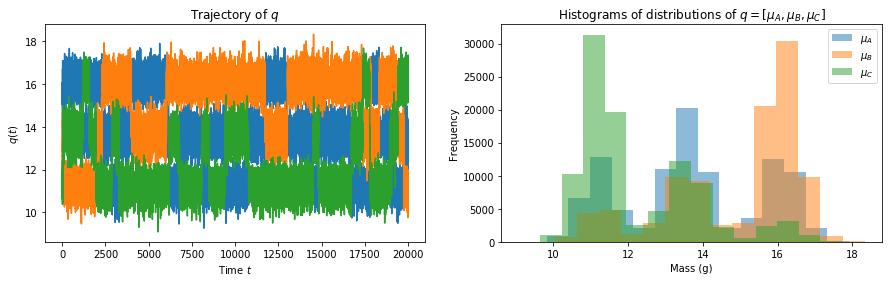

In [192]:
Nsteps = 100000
h = 0.2
gamma = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation_with_data(q0, p0, Nsteps , h, gamma, HMC_with_data, force, Y)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

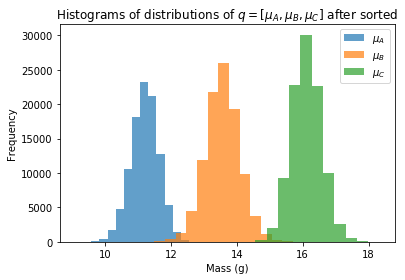

In [193]:

n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 13.5, which is roughly the middle of the data.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(13.5-\mu_A)^2/32}) \exp({-(13.5-\mu_B)^2/32}) \exp({-(13.5-\mu_B)^2/32}) $$

In [195]:
# Minibatch size: n

def get_minibatch(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n-1]
    y = y[n:]
    return batch, y
    

def force_noise(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
    
    
    # Take the negative of each gradient
    grad_m1 = -(-(1/16)*(13.5 - m1) + batch_scaling*sum(-(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat))  
    grad_m2 = -(-(1/16)*(13.5 - m2) + batch_scaling*sum(-(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat))
    grad_m3 = -(-(1/16)*(13.5 - m3) + batch_scaling*sum(-(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat))
    
    return grad_m1,grad_m2,grad_m3


def HMC_with_noise(q0,h,y,n):
    # n is the size of the batch
    batch_scaling = len(y)/n
    q = q0
    p = np.random.randn(3)
    current_p = p
    
    y_batch, y_updated = get_minibatch(y,n)
    
    p = p + h*np.asarray(force_noise(q,y_batch,batch_scaling))/2
    q = q + h*p
    p = p + h*np.asarray(force_noise(q,y_batch,batch_scaling))/2
    p = -p
    
    current_U = U(q0,y)
    current_K = sum(current_p**2)/2
    proposed_U = U(q, y)
    proposed_K = sum(p**2)/2
    
    accept = -1
    if np.random.uniform(0,1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        accept = 1
        return q, accept,y_updated      # accept
    else:
        accept = 0
        return q0, accept, y_updated     # reject
    

In [7]:
y_batch, y = get_minibatch(Y,5)
y_batch
grad1,grad2,grad3 = force_noise(q0,y_batch,1/5)
grad1,grad2,grad3

(0.17758755649329783, 0.18298424897210974, 0.9727010422216322)

In [196]:
def run_simulation_with_noise( q0,p0, Nsteps, h, step_function, Y, batch_size):
    
    num_scans = len(Y)/batch_size
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    y_updated = Y
    scans = num_scans
    for n in range(Nsteps):
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,p,y_updated = step_function(q, h, y_updated, batch_size)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        scans = scans - 1

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

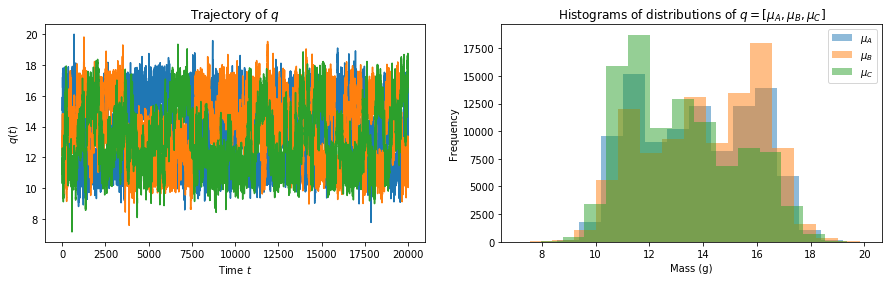

In [197]:
Nsteps = 100000
h = 0.2

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj_noise, p_traj, t_traj = run_simulation_with_noise(q0, p0, Nsteps , h, HMC_with_noise, Y, 1)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj_noise )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj_noise[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj_noise[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj_noise[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

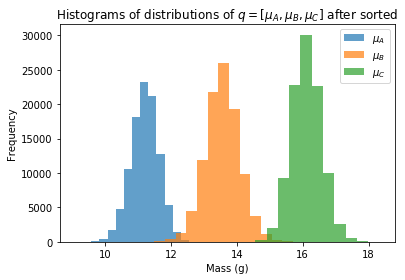

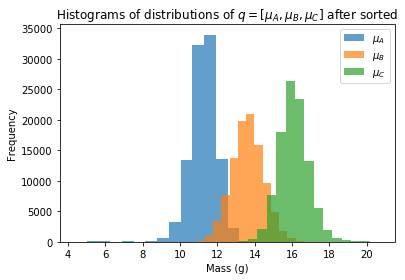

In [194]:

n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    


n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj_noise.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj_noise[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    

In [144]:
batch, updated = get_minibatch_with_cov(Y, 2)
len(updated)

x = np.array([2,3,4,5,6])
print(x[0:2])
print(x[2:])

[2 3]
[4 5 6]


In [178]:
# add in covariance term

def get_minibatch_with_cov(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n]
    y = y[n:]
    return batch, y
    

# Minibatch size: n


def force_noise_with_cov(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    
    grad_prior = np.array([[-(1/16)*(13.5 - m1)], [-(1/16)*(13.5 - m2)], [-(1/16)*(13.5 - m3)]])
    
    def likelihood_grad(y_batch):
        batch_length = len(y_batch)
        m1_vec = m1*np.ones(batch_length)
        m2_vec = m2*np.ones(batch_length)
        m3_vec = m3*np.ones(batch_length)
        p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
        
        grad1 = -(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat
        grad2 = -(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat
        grad3 = -(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat
        
        grad = np.array([grad1,grad2,grad3])
        
        return grad
    
    
    # Take the negative of each gradient
    grad_m1 = -(grad_prior[0] + batch_scaling*sum(likelihood_grad(y_batch)[0]))  
    grad_m2 = -(grad_prior[1] + batch_scaling*sum(likelihood_grad(y_batch)[1]))
    grad_m3 = -(grad_prior[2] + batch_scaling*sum(likelihood_grad(y_batch)[2]))
    
    s_ti = np.zeros([3,n])
    for i in range(n):
        s = (1/n)*grad_prior + likelihood_grad([y_batch[i]])
        s_ti[:,i] = s[:,0]
         
    B_hat = batch_scaling**2 * np.cov(s_ti)   # covariance of the scores s_ti to estimate covariance matrix
    
    grad = np.array([grad_m1, grad_m2, grad_m3])
    
    return grad, B_hat


def SGHMC(q0,h,y,n):
    # n is the size of the batch
    batch_scaling = len(y)/n
    q = q0
    p = np.random.randn(3)
    current_p = p
    M = np.eye(3)   # preconditioning matrix set to identity. can be used to precondition sampler 
    # when we have more info about target distribution
    
    (y_batch, y_updated) = get_minibatch_with_cov(y,n)
    grad, B_hat = force_noise_with_cov(q,y_batch, batch_scaling)
    # for now set C=B_hat and B=zeros(3)
    C = .5*h*B_hat
    B = np.zeros([3,3])
    added_noise = np.random.multivariate_normal(np.zeros(3), 2*h*C, 1)
    
    q = q + h*p
    p = p + h*grad - h*C*p + added_noise
    #p = p + h*grad - C*p
    
    return q, y_updated
    

In [179]:
def run_simulation_sghmc( q0,p0, Nsteps, h, step_function, Y, batch_size):
    num_scans = len(Y)/batch_size
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    y_updated = Y
    scans = num_scans
    for n in range(Nsteps):
        if n == 10000:
            print(n)
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,y_updated = step_function(q, h, y_updated, batch_size)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        scans = scans - 1

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [180]:
Nsteps = 100000
h = 0.2

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj_noise, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , h, SGHMC, Y, 2)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj_noise )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj_noise[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj_noise[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj_noise[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

[[ 0.37312077 -0.75760009 -1.42469636]
 [-0.75760009  1.53826304  2.89276333]
 [-1.42469636  2.89276333  5.43995368]]
[[ 0.00167362 -0.00289063 -0.04628783]
 [-0.00289063  0.0049926   0.07994685]
 [-0.04628783  0.07994685  1.28019437]]
[[52.48651487 17.16472806 26.67995954]
 [17.16472806  5.61340165  8.72517925]
 [26.67995954  8.72517925 13.56196431]]
[[43.1698892  10.91393058 12.18493   ]
 [10.91393058  2.75918894  3.08051474]
 [12.18493     3.08051474  3.43926106]]
[[ 0.22841415  0.06452147 -0.03910506]
 [ 0.06452147  0.01822575 -0.01104623]
 [-0.03910506 -0.01104623  0.00669488]]
[[7.9914888  4.64707926 4.13316821]
 [4.64707926 2.70229318 2.40345207]
 [4.13316821 2.40345207 2.13765919]]
[[42.23760923 -3.68731354 -3.49577919]
 [-3.68731354  0.32189988  0.30517906]
 [-3.49577919  0.30517906  0.2893268 ]]
[[0.76056748 2.04701789 2.70791076]
 [2.04701789 5.50941543 7.28816559]
 [2.70791076 7.28816559 9.64119666]]
[[ 0.03670272 -0.2421799  -0.30985657]
 [-0.2421799   1.59800425  2.044563

[[ 8.34659279e-07 -3.08368723e-03  2.95788133e-04]
 [-3.08368723e-03  1.13928248e+01 -1.09280291e+00]
 [ 2.95788133e-04 -1.09280291e+00  1.04821958e-01]]
[[ 7.91321137e-04 -1.53179023e-01  1.86104498e-02]
 [-1.53179023e-01  2.96514424e+01 -3.60249510e+00]
 [ 1.86104498e-02 -3.60249510e+00  4.37684306e-01]]
[[ 2.74714581e-05 -4.31082346e-02 -4.66532016e-03]
 [-4.31082346e-02  6.76454770e+01  7.32082421e+00]
 [-4.66532016e-03  7.32082421e+00  7.92284561e-01]]
[[ 1.00086716 -8.05652802 -1.54765981]
 [-8.05652802 64.85140721 12.45796155]
 [-1.54765981 12.45796155  2.39317561]]
[[ 1.33635544  0.20466995 -0.88716068]
 [ 0.20466995  0.03134629 -0.13587338]
 [-0.88716068 -0.13587338  0.58895564]]
[[ 1.69147484  4.30531657  1.25180073]
 [ 4.30531657 10.95833665  3.18621258]
 [ 1.25180073  3.18621258  0.92641347]]
[[ 1.15974861e-04 -8.89123534e-03 -6.10624184e-04]
 [-8.89123534e-03  6.81648293e-01  4.68136222e-02]
 [-6.10624184e-04  4.68136222e-02  3.21502342e-03]]
[[ 4.52782323e-04 -3.80938220e

[[ 0.00357462  0.00485833 -0.01141793]
 [ 0.00485833  0.00660305 -0.01551833]
 [-0.01141793 -0.01551833  0.0364708 ]]
[[ 1.39296684e-03  9.25742575e-06 -8.62232266e-02]
 [ 9.25742575e-06  6.15233106e-08 -5.73025212e-04]
 [-8.62232266e-02 -5.73025212e-04  5.33712979e+00]]
[[ 1.91228030e-03  1.07022618e-05 -1.74009100e-01]
 [ 1.07022618e-05  5.98962440e-08 -9.73858768e-04]
 [-1.74009100e-01 -9.73858768e-04  1.58340630e+01]]
[[ 1.03352362e-01 -1.11823357e-02  8.58024662e-01]
 [-1.11823357e-02  1.20988654e-03 -9.28350319e-02]
 [ 8.58024662e-01 -9.28350319e-02  7.12326558e+00]]
[[ 0.16513096 -0.20919086  1.28234063]
 [-0.20919086  0.26500672 -1.62449203]
 [ 1.28234063 -1.62449203  9.95814134]]
[[ 0.05024268 -0.06036706  0.4047717 ]
 [-0.06036706  0.07253159 -0.48633703]
 [ 0.4047717  -0.48633703  3.26097506]]
[[ 3.73126129e-07  5.75432758e-13 -1.82462515e-04]
 [ 5.75432758e-13  8.87428765e-19 -2.81392538e-10]
 [-1.82462515e-04 -2.81392538e-10  8.92260466e-02]]
[[ 2.35665327e-03  1.94777939e

[[ 7.22718787e-03  8.35232552e-12 -2.68166980e-02]
 [ 8.35232552e-12  9.65262601e-21 -3.09915551e-11]
 [-2.68166980e-02 -3.09915551e-11  9.95041648e-02]]
[[ 5.03861446e-03  1.86137174e-06 -3.54280729e-01]
 [ 1.86137174e-06  6.87630453e-10 -1.30878864e-04]
 [-3.54280729e-01 -1.30878864e-04  2.49105853e+01]]
[[ 8.56447590e-02  1.83099556e-06 -1.26362504e+00]
 [ 1.83099556e-06  3.91447739e-11 -2.70149845e-05]
 [-1.26362504e+00 -2.70149845e-05  1.86438524e+01]]
[[ 1.87022479e+00 -2.63220528e-02  1.54314096e+00]
 [-2.63220528e-02  3.70463736e-04 -2.17185860e-02]
 [ 1.54314096e+00 -2.17185860e-02  1.27326086e+00]]
[[ 8.12208167e-02  1.16124087e-07 -8.43067430e-01]
 [ 1.16124087e-07  1.66026446e-13 -1.20536138e-06]
 [-8.43067430e-01 -1.20536138e-06  8.75099169e+00]]
[[ 1.33400997e+00 -4.74765298e-02  3.35306794e+00]
 [-4.74765298e-02  1.68965819e-03 -1.19333463e-01]
 [ 3.35306794e+00 -1.19333463e-01  8.42802140e+00]]
[[ 4.44632310e-03 -2.48983836e-06  1.34630921e-01]
 [-2.48983836e-06  1.3942

 [-3.56726657e-01 -2.65239347e-04  9.98325725e+01]]
[[ 3.47911769e-06  2.47650381e-10 -4.03887554e-03]
 [ 2.47650381e-10  1.76282371e-14 -2.87495037e-07]
 [-4.03887554e-03 -2.87495037e-07  4.68869326e+00]]
[[ 0.50518447 -0.65787044  6.89628395]
 [-0.65787044  0.85670391 -8.98060332]
 [ 6.89628395 -8.98060332 94.14131836]]
[[ 1.66573062 -0.37007221 -0.64407957]
 [-0.37007221  0.08221824  0.14309393]
 [-0.64407957  0.14309393  0.24904297]]
[[ 2.59148154e-07  1.54596821e-10 -1.07083803e-03]
 [ 1.54596821e-10  9.22259203e-14 -6.38816647e-07]
 [-1.07083803e-03 -6.38816647e-07  4.42485916e+00]]
[[ 7.14412199e-02  9.03673787e-04 -1.64590682e+00]
 [ 9.03673787e-04  1.14307442e-05 -2.08193932e-02]
 [-1.64590682e+00 -2.08193932e-02  3.79194148e+01]]
[[ 1.13981851e-01  1.57661770e-03 -2.92489629e-01]
 [ 1.57661770e-03  2.18080628e-05 -4.04576975e-03]
 [-2.92489629e-01 -4.04576975e-03  7.50559691e-01]]
[[ 4.49691646e-05  1.59516377e-09 -2.57938560e-02]
 [ 1.59516377e-09  5.65842724e-14 -9.14969735

 [  3.32523637 -10.0223068   56.71211763]]
[[  8.03662004   1.67352001 -44.02348753]
 [  1.67352001   0.34848845  -9.16731002]
 [-44.02348753  -9.16731002 241.15454563]]
[[ 1.36701686e-10  8.67806403e-14 -2.33022789e-05]
 [ 8.67806403e-14  5.50898804e-17 -1.47926974e-08]
 [-2.33022789e-05 -1.47926974e-08  3.97212512e+00]]
[[ 0.07779685  0.06807378 -1.98269122]
 [ 0.06807378  0.0595659  -1.73489393]
 [-1.98269122 -1.73489393 50.52986849]]
[[ 4.06473755e-05  2.56839551e-05 -1.47379903e-02]
 [ 2.56839551e-05  1.62289826e-05 -9.31252944e-03]
 [-1.47379903e-02 -9.31252944e-03  5.34372404e+00]]
[[ 0.15529604  0.22556076 -0.33308886]
 [ 0.22556076  0.32761723 -0.48379713]
 [-0.33308886 -0.48379713  0.71443026]]
[[ 2.48460944e-05  5.80783510e-06 -1.35446076e-02]
 [ 5.80783510e-06  1.35759561e-06 -3.16608503e-03]
 [-1.35446076e-02 -3.16608503e-03  7.38371162e+00]]
[[ 0.29774287  0.2422204  -3.92498989]
 [ 0.2422204   0.19705165 -3.19306603]
 [-3.92498989 -3.19306603 51.74110738]]
[[ 0.42679562 

[[ 9.27857527e+01 -2.51194165e-01 -6.40951648e+00]
 [-2.51194165e-01  6.80045232e-04  1.73521591e-02]
 [-6.40951648e+00  1.73521591e-02  4.42760880e-01]]
[[ 1.56093082e+00 -4.43999026e-05 -3.59574717e-02]
 [-4.43999026e-05  1.26293320e-09  1.02279244e-06]
 [-3.59574717e-02  1.02279244e-06  8.28313312e-04]]
[[ 0.0036771  -0.00166139  0.00379222]
 [-0.00166139  0.00075065 -0.0017134 ]
 [ 0.00379222 -0.0017134   0.00391095]]
[[ 5.04408231e-02 -1.88293151e-05 -5.12831448e-03]
 [-1.88293151e-05  7.02889215e-09  1.91437497e-06]
 [-5.12831448e-03  1.91437497e-06  5.21395327e-04]]
[[ 5.93921584e-04 -3.41004187e-10 -2.14850091e-05]
 [-3.41004187e-10  1.95789913e-16  1.23357666e-11]
 [-2.14850091e-05  1.23357666e-11  7.77216434e-07]]
[[ 3.52998311 -0.40421389  0.32096884]
 [-0.40421389  0.04628602 -0.03675373]
 [ 0.32096884 -0.03675373  0.02918456]]
[[ 2.90422239e+00 -2.36658096e-04 -7.14809280e-02]
 [-2.36658096e-04  1.92846990e-08  5.82480889e-06]
 [-7.14809280e-02  5.82480889e-06  1.75934291e

[[ 5.22782200e-01 -8.54930357e-11  9.73611942e-02]
 [-8.54930357e-11  1.39810789e-20 -1.59219347e-11]
 [ 9.73611942e-02 -1.59219347e-11  1.81322205e-02]]
[[ 4.63303869e+01 -2.63107511e-03  7.93473291e+00]
 [-2.63107511e-03  1.49417190e-07 -4.50608761e-04]
 [ 7.93473291e+00 -4.50608761e-04  1.35893504e+00]]
[[ 2.12195051e+00 -1.54482573e-06  7.88296839e-01]
 [-1.54482573e-06  1.12466645e-12 -5.73897100e-07]
 [ 7.88296839e-01 -5.73897100e-07  2.92849388e-01]]
[[ 2.91591468e+00 -2.20205279e-07 -1.96771421e-01]
 [-2.20205279e-07  1.66295554e-14  1.48598674e-08]
 [-1.96771421e-01  1.48598674e-08  1.32785065e-02]]
[[ 1.20151666e+02 -1.54001233e-01  5.36920258e+00]
 [-1.54001233e-01  1.97387025e-04 -6.88183398e-03]
 [ 5.36920258e+00 -6.88183398e-03  2.39932889e-01]]
[[ 9.41420225e+01 -5.24804766e-01 -2.89849535e+00]
 [-5.24804766e-01  2.92558026e-03  1.61579721e-02]
 [-2.89849535e+00  1.61579721e-02  8.92404379e-02]]
[[ 1.45909415e+01 -1.87810476e-04 -1.41521783e+00]
 [-1.87810476e-04  2.4174

[[ 2.10852940e+00  0.00000000e+00 -1.82239695e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.82239695e-03  0.00000000e+00  1.57509336e-06]]
[[ 1.19893506e+01 -3.02018134e-12 -3.50202290e-01]
 [-3.02018134e-12  7.60799798e-25  8.82178241e-14]
 [-3.50202290e-01  8.82178241e-14  1.02292149e-02]]
[[ 9.29561998e+01 -4.34922790e-09 -5.96064598e+00]
 [-4.34922790e-09  2.03491358e-19  2.78886270e-10]
 [-5.96064598e+00  2.78886270e-10  3.82215502e-01]]
[[ 2.86252819e+00  0.00000000e+00 -2.93722086e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.93722086e-03  0.00000000e+00  3.01386250e-06]]
[[ 1.96636566e+01 -1.64332944e-11 -6.54621251e-01]
 [-1.64332944e-11  1.37336188e-23  5.47079515e-13]
 [-6.54621251e-01  5.47079515e-13  2.17929447e-02]]
[[ 7.18158816e+00 -1.54168368e-05 -2.00594331e+00]
 [-1.54168368e-05  3.30955844e-11  4.30619243e-06]
 [-2.00594331e+00  4.30619243e-06  5.60295085e-01]]
[[ 1.13745679e-01  3.08405778e-03 -5.13834719e-01]
 [ 3.08405778e-03  8.3619

[[ 9.87894997e-06  0.00000000e+00 -1.02617402e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.02617402e-06  0.00000000e+00  1.06593628e-07]]
[[ 2.27036929e+00  1.56476301e-02 -1.43870180e+01]
 [ 1.56476301e-02  1.07845154e-04 -9.91568801e-02]
 [-1.43870180e+01 -9.91568801e-02  9.11685550e+01]]
[[ 6.65245434e-01  7.94586444e-04 -5.02315157e+00]
 [ 7.94586444e-04  9.49074709e-07 -5.99978285e-03]
 [-5.02315157e+00 -5.99978285e-03  3.79289363e+01]]
[[ 1.22108230e-02  2.11015621e-08 -3.26798426e-01]
 [ 2.11015621e-08  3.64656768e-14 -5.64741403e-07]
 [-3.26798426e-01 -5.64741403e-07  8.74611086e+00]]
[[ 5.65632204e-02  1.19709830e-05 -3.86858763e-01]
 [ 1.19709830e-05  2.53352678e-09 -8.18743989e-05]
 [-3.86858763e-01 -8.18743989e-05  2.64588370e+00]]
[[ 6.00411464e+00 -2.09104041e-13 -7.17338622e-01]
 [-2.09104041e-13  7.28242260e-27  2.49826018e-14]
 [-7.17338622e-01  2.49826018e-14  8.57036765e-02]]
[[ 0.22475205  2.15691816 -0.1801033 ]
 [ 2.15691816 20.69968216 -1.72842952

 [-0.54222916  3.28109762  0.59382232]]
[[ 2.13414303e+00 -9.53844466e-06  1.25874499e+00]
 [-9.53844466e-06  4.26315974e-11 -5.62589724e-06]
 [ 1.25874499e+00 -5.62589724e-06  7.42423969e-01]]
[[ 4.16132038e-01 -2.54838139e-05  2.16198246e-01]
 [-2.54838139e-05  1.56062190e-09 -1.32399224e-05]
 [ 2.16198246e-01 -1.32399224e-05  1.12324160e-01]]
[[ 0.30709306 -0.88321001  1.03976226]
 [-0.88321001  2.54014178 -2.99039133]
 [ 1.03976226 -2.99039133  3.52044927]]
[[ 2.32930474e+00 -8.45776037e-04  1.77565445e+00]
 [-8.45776037e-04  3.07103271e-07 -6.44744311e-04]
 [ 1.77565445e+00 -6.44744311e-04  1.35360078e+00]]
[[ 8.43277933e-01 -4.57997261e-02 -1.60050504e-02]
 [-4.57997261e-02  2.48745381e-03  8.69258988e-04]
 [-1.60050504e-02  8.69258988e-04  3.03768933e-04]]
[[ 1.33496856 -0.89786886  0.74707493]
 [-0.89786886  0.60388575 -0.50246525]
 [ 0.74707493 -0.50246525  0.41807798]]
[[ 2.98888024e-06 -2.25199424e-09  2.06269810e-03]
 [-2.25199424e-09  1.69678196e-12 -1.55415536e-06]
 [ 2.0

[[ 5.03101728e+01 -4.71975208e-04  3.49232454e+01]
 [-4.71975208e-04  4.42774462e-09 -3.27625708e-04]
 [ 3.49232454e+01 -3.27625708e-04  2.42422755e+01]]
[[ 2.20053080e-01 -9.29053539e-13  1.12694619e-01]
 [-9.29053539e-13  3.92241943e-24 -4.75791270e-13]
 [ 1.12694619e-01 -4.75791270e-13  5.77136986e-02]]
[[ 8.68091370e+00 -8.70923855e-07  4.59166632e+00]
 [-8.70923855e-07  8.73765582e-14 -4.60664842e-07]
 [ 4.59166632e+00 -4.60664842e-07  2.42870743e+00]]
[[ 29.49676603 -26.8252482   10.97428897]
 [-26.8252482   24.39568936  -9.9803492 ]
 [ 10.97428897  -9.9803492    4.0829906 ]]
[[ 1.35678113e-03 -1.48790882e-07  2.60476094e-03]
 [-1.48790882e-07  1.63170950e-11 -2.85650109e-07]
 [ 2.60476094e-03 -2.85650109e-07  5.00064409e-03]]
[[ 0.07341128 -1.00439724  0.09279232]
 [-1.00439724 13.74194504 -1.26956442]
 [ 0.09279232 -1.26956442  0.11729008]]
[[ 6.42033106e+00 -4.51217378e-03  6.49595567e+00]
 [-4.51217378e-03  3.17113121e-06 -4.56532235e-03]
 [ 6.49595567e+00 -4.56532235e-03  6.

[[ 2.03083501e-02 -5.29505367e-07  1.93517836e-02]
 [-5.29505367e-07  1.38059435e-11 -5.04564536e-07]
 [ 1.93517836e-02 -5.04564536e-07  1.84402733e-02]]
[[ 0.2909784  -0.94309368  2.2056718 ]
 [-0.94309368  3.0566726  -7.14883019]
 [ 2.2056718  -7.14883019 16.71941348]]
[[ 0.17632531 -0.9867785   1.78034057]
 [-0.9867785   5.52235989 -9.96341257]
 [ 1.78034057 -9.96341257 17.97593636]]
[[ 5.80856657e-02  1.41377074e-10 -5.39385931e-01]
 [ 1.41377074e-10  3.44103433e-19 -1.31283344e-09]
 [-5.39385931e-01 -1.31283344e-09  5.00876040e+00]]
[[ 6.96676332e-05  3.62826349e-08 -1.81554904e-03]
 [ 3.62826349e-08  1.88958565e-11 -9.45530945e-07]
 [-1.81554904e-03 -9.45530945e-07  4.73134822e-02]]
[[ 3.60686860e-02  2.02258624e-08 -2.12264568e-01]
 [ 2.02258624e-08  1.13418468e-14 -1.19029397e-07]
 [-2.12264568e-01 -1.19029397e-07  1.24917905e+00]]
[[ 5.65289311e-02 -1.05411517e-03  1.83307093e-02]
 [-1.05411517e-03  1.96564621e-05 -3.41819284e-04]
 [ 1.83307093e-02 -3.41819284e-04  5.94412274e

 [-11.94933429  -5.97909668  81.21150936]]
[[ 9.68114092e-05  2.47054388e-06 -2.94564266e-02]
 [ 2.47054388e-06  6.30461544e-08 -7.51702666e-04]
 [-2.94564266e-02 -7.51702666e-04  8.96259104e+00]]
[[  2.11655001   0.73149754 -14.18679039]
 [  0.73149754   0.25281172  -4.90307444]
 [-14.18679039  -4.90307444  95.09107766]]
[[0.93543062 0.78712607 2.95740096]
 [0.78712607 0.66233394 2.48853024]
 [2.95740096 2.48853024 9.34994028]]
[[ 0.07449089  0.21046258 -0.38646724]
 [ 0.21046258  0.59462969 -1.09190383]
 [-0.38646724 -1.09190383  2.00503609]]
[[ 4.61549878e-04  4.19104221e-05 -6.10867630e-03]
 [ 4.19104221e-05  3.80562008e-06 -5.54690218e-04]
 [-6.10867630e-03 -5.54690218e-04  8.08491735e-02]]
[[ 3.22806189e-02  9.08842585e-03 -6.71109113e-01]
 [ 9.08842585e-03  2.55879495e-03 -1.88946979e-01]
 [-6.71109113e-01 -1.88946979e-01  1.39522555e+01]]
[[ 0.37188081  0.37181132 -3.2463226 ]
 [ 0.37181132  0.37174183 -3.24571592]
 [-3.2463226  -3.24571592 28.33867749]]
[[ 8.44129005e-04  1.15

[[ 5.65002214e-05  8.83460132e-07 -2.53243274e-02]
 [ 8.83460132e-07  1.38141371e-08 -3.95981345e-04]
 [-2.53243274e-02 -3.95981345e-04  1.13507796e+01]]
[[ 0.58476358  0.10371376 -0.79563606]
 [ 0.10371376  0.01839469 -0.14111414]
 [-0.79563606 -0.14111414  1.08255159]]
[[ 0.4579945   0.11606277 -0.33086496]
 [ 0.11606277  0.02941207 -0.08384621]
 [-0.33086496 -0.08384621  0.23902388]]
[[ 1.66933704e-18  5.29060754e-20 -2.69117739e-10]
 [ 5.29060754e-20  1.67674517e-21 -8.52911248e-12]
 [-2.69117739e-10 -8.52911248e-12  4.33851018e-02]]
[[  0.10868287   0.43578287  -3.12478012]
 [  0.43578287   1.74734722 -12.52934944]
 [ -3.12478012 -12.52934944  89.84167309]]
[[5.78818198 3.14338398 5.30527152]
 [3.14338398 1.70707536 2.88113013]
 [5.30527152 2.88113013 4.86265049]]
[[ 5.26604900e-05  1.46845265e-07 -2.24276002e-02]
 [ 1.46845265e-07  4.09482171e-10 -6.25399969e-05]
 [-2.24276002e-02 -6.25399969e-05  9.55170088e+00]]
[[ 19.58409609   4.35164337 -20.71658464]
 [  4.35164337   0.96694

[[ 8.80990100e-06  1.09571696e-05 -1.11602301e-02]
 [ 1.09571696e-05  1.36277995e-05 -1.38803527e-02]
 [-1.11602301e-02 -1.38803527e-02  1.41375863e+01]]
[[ 1.37963818e-24  2.45636685e-22 -3.47825903e-14]
 [ 2.45636685e-22  4.37342065e-20 -6.19284121e-12]
 [-3.47825903e-14 -6.19284121e-12  8.76917299e-04]]
[[ 0.05283076  0.3144317  -0.32060098]
 [ 0.3144317   1.87139623 -1.90811384]
 [-0.32060098 -1.90811384  1.94555187]]
[[ 8.47453834e-15  3.53660636e-13 -5.43463392e-08]
 [ 3.53660636e-13  1.47590159e-11 -2.26798914e-06]
 [-5.43463392e-08 -2.26798914e-06  3.48517460e-01]]
[[0.07767311 0.24948332 0.15971587]
 [0.24948332 0.80133171 0.51300178]
 [0.15971587 0.51300178 0.32841684]]
[[0.00758662 0.01645915 0.03968731]
 [0.01645915 0.03570807 0.08610148]
 [0.03968731 0.08610148 0.20761317]]
[[ 2.45037418e-09  1.76303202e-07 -6.12395050e-04]
 [ 1.76303202e-07  1.26849277e-05 -4.40615190e-02]
 [-6.12395050e-04 -4.40615190e-02  1.53049155e+02]]
[[ 1.95411301e-02  1.05124629e+00 -7.65803409e-0

[[ 1.04770589e-31 -1.15972032e-16  2.86223228e-18]
 [-1.15972032e-16  1.29130659e-01 -3.18699201e-03]
 [ 2.86223228e-18 -3.18699201e-03  7.86561316e-05]]
[[ 1.40073723e-21 -3.97054852e-12  6.10893820e-17]
 [-3.97054852e-12  1.12549700e-02 -1.73164781e-07]
 [ 6.10893820e-17 -1.73164781e-07  2.66424888e-12]]
[[ 1.28973790e-22 -4.81076011e-11  4.89681366e-11]
 [-4.81076011e-11  1.79442760e+01 -1.82652582e+01]
 [ 4.89681366e-11 -1.82652582e+01  1.85919821e+01]]
[[ 1.91720901e-17 -2.43498490e-08  2.59667786e-11]
 [-2.43498490e-08  3.09259525e+01 -3.29795623e-02]
 [ 2.59667786e-11 -3.29795623e-02  3.51695401e-05]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.62644327e+00 3.25249177e-02]
 [0.00000000e+00 3.25249177e-02 2.91710139e-04]]
[[ 0.          0.          0.        ]
 [ 0.          5.17976715 -2.43798934]
 [ 0.         -2.43798934  1.14750178]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.76639327e-04 -1.14783848e-02]
 [ 0.00000000e+00 -

[[ 2.28717785e-12 -6.84404394e-06 -1.13932642e-05]
 [-6.84404394e-06  2.04797967e+01  3.40926703e+01]
 [-1.13932642e-05  3.40926703e+01  5.67539897e+01]]
[[113.39518267  15.1359772   23.43702576]
 [ 15.1359772    2.02034866   3.12837176]
 [ 23.43702576   3.12837176   4.84406977]]
[[73.60206543  9.39454071  8.42315803]
 [ 9.39454071  1.19911574  1.07512881]
 [ 8.42315803  1.07512881  0.96396196]]
[[ 1.19510358e-06 -1.25428754e-03 -3.82525674e-03]
 [-1.25428754e-03  1.31640241e+00  4.01469123e+00]
 [-3.82525674e-03  4.01469123e+00  1.22437832e+01]]
[[0.         0.         0.        ]
 [0.         2.55264138 1.66269831]
 [0.         1.66269831 1.08302157]]
[[ 1.97215226e-32 -1.79025500e-16 -1.79773548e-16]
 [-1.79025500e-16  3.25026927e+00  3.26385035e+00]
 [-1.79773548e-16  3.26385035e+00  3.27748817e+00]]
[[ 0.07016603 -0.27715632 -0.58375913]
 [-0.27715632  1.09476941  2.30585269]
 [-0.58375913  2.30585269  4.85669089]]
[[ 6.05033040e-03 -1.54525908e-03 -2.48050243e-01]
 [-1.54525908e-

[[ 5.54667824e-31 -4.49705426e-15  4.23691157e-16]
 [-4.49705426e-15  3.64605556e+01 -3.43514089e+00]
 [ 4.23691157e-16 -3.43514089e+00  3.23642708e-01]]
[[ 0.          0.          0.        ]
 [ 0.         37.93486785 -1.85561236]
 [ 0.         -1.85561236  0.09076866]]
[[ 0.          0.          0.        ]
 [ 0.         18.44491712 -1.46789014]
 [ 0.         -1.46789014  0.11681817]]
[[ 0.          0.          0.        ]
 [ 0.          0.1762573  -0.01882353]
 [ 0.         -0.01882353  0.00201027]]
[[ 5.40687172e-22 -9.96508904e-11  2.50582830e-12]
 [-9.96508904e-11  1.83660728e+01 -4.61834557e-01]
 [ 2.50582830e-12 -4.61834557e-01  1.16133243e-02]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.33379271e-02 -1.39239378e-03]
 [ 0.00000000e+00 -1.39239378e-03  5.81547985e-05]]
[[ 0.          0.          0.        ]
 [ 0.          0.23347697 -0.05661506]
 [ 0.         -0.05661506  0.0137284 ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+

[[ 1.00148357e-31 -1.67370547e-15  8.12527878e-17]
 [-1.67370547e-15  2.90902586e+01 -1.41223450e+00]
 [ 8.12527878e-17 -1.41223450e+00  6.85592490e-02]]
[[0.         0.         0.        ]
 [0.         8.78331656 1.48397947]
 [0.         1.48397947 0.25072477]]
[[ 1.38666956e-32 -2.94905422e-16 -1.15752408e-17]
 [-2.94905422e-16  6.96867202e+00  2.73525173e-01]
 [-1.15752408e-17  2.73525173e-01  1.07360513e-02]]
[[0.         0.         0.        ]
 [0.         1.058796   0.51677638]
 [0.         0.51677638 0.25222784]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.18026969e-03 4.10093343e-04]
 [0.00000000e+00 4.10093343e-04 5.28812228e-05]]
[[ 1.00533543e-29 -3.63233058e-14 -4.24193258e-15]
 [-3.63233058e-14  1.31692153e+02  1.53793611e+01]
 [-4.24193258e-15  1.53793611e+01  1.79604283e+00]]
[[ 0.          0.          0.        ]
 [ 0.          4.79691249 -0.56069525]
 [ 0.         -0.56069525  0.06553781]]
[[ 1.14731592e-19 -4.85167711e-09 -4.74868711e-10]
 [-4.8

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.32878628e-01 -2.46311899e-12]
 [ 0.00000000e+00 -2.46311899e-12  4.56578701e-23]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.08174350e-05 -1.28884088e-02]
 [ 0.00000000e+00 -1.28884088e-02  5.39016569e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.94661112e+01 -8.27740351e-01]
 [ 0.00000000e+00 -8.27740351e-01  1.38509794e-02]]
[[ 0.          0.          0.        ]
 [ 0.          0.05325706 -0.65385754]
 [ 0.         -0.65385754  8.02766224]]
[[ 0.          0.          0.        ]
 [ 0.         28.58790152 20.58113372]
 [ 0.         20.58113372 14.81686457]]
[[ 0.          0.          0.        ]
 [ 0.         10.14618753 -4.16648073]
 [ 0.         -4.16648073  1.71094429]]
[[0.         0.         0.        ]
 [0.         6.83598399 5.16183181]
 [0.         5.16183181 3.89768431]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.718

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.25929999e-27 -3.31187979e-14]
 [ 0.00000000e+00 -3.31187979e-14  2.08555292e-01]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.47895653e+00 -1.37778401e-06]
 [ 0.00000000e+00 -1.37778401e-06  1.28353251e-12]]
[[0.         0.         0.        ]
 [0.         0.58852973 0.50535267]
 [0.         0.50535267 0.43393105]]
[[  0.           0.           0.        ]
 [  0.          90.8066017   98.0880243 ]
 [  0.          98.0880243  105.95331541]]
[[ 0.          0.          0.        ]
 [ 0.         95.21243082 -6.57319142]
 [ 0.         -6.57319142  0.45379416]]
[[  0.           0.           0.        ]
 [  0.         183.94557212 119.81084931]
 [  0.         119.81084931  78.03742948]]
[[  0.           0.           0.        ]
 [  0.         153.47927226 180.78383382]
 [  0.         180.78383382 212.94598344]]
[[  0.           0.           0.        ]
 [  0.         105.08619792 107.75413921]


[[  0.           0.           0.        ]
 [  0.          84.76777774 103.03064157]
 [  0.         103.03064157 125.22816318]]
[[ 0.          0.          0.        ]
 [ 0.         21.83298445  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.          88.64418109 119.26412963]
 [  0.         119.26412963 160.46098506]]
[[  0.           0.           0.        ]
 [  0.           9.10581443  30.65992576]
 [  0.          30.65992576 103.23415385]]
[[  0.           0.           0.        ]
 [  0.         111.25353012  96.30769197]
 [  0.          96.30769197  83.36968294]]
[[ 0.          0.          0.        ]
 [ 0.         39.51195758 57.49734704]
 [ 0.         57.49734704 83.66947929]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.12962268e+01 -6.38388583e-03]
 [ 0.00000000e+00 -6.38388583e-03  3.60775318e-06]]
[[ 7.70371978e-33 -3.43249169e-16  4.87570575e-22]
 [-3.43249169e-16  3.05878188e+01 -4.34486715e-05]


[[0.        0.        0.       ]
 [0.        0.0181422 0.       ]
 [0.        0.        0.       ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.75975821e-03 -4.31571398e-12]
 [ 0.00000000e+00 -4.31571398e-12  1.90838613e-21]]
[[ 0.          0.          0.        ]
 [ 0.         37.09406556  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.          11.12546105  69.87829712]
 [  0.          69.87829712 438.90103863]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.33968690e+02 -3.27327197e-02]
 [ 0.00000000e+00 -3.27327197e-02  7.99762196e-06]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.65630770e-08 -2.24074828e-04]
 [ 0.00000000e+00 -2.24074828e-04  8.87673213e-01]]
[[ 0.          0.          0.        ]
 [ 0.         33.95600487  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.863

[[  0.           0.           0.        ]
 [  0.         215.98659186 321.93481354]
 [  0.         321.93481354 479.85397276]]
[[ 0.          0.          0.        ]
 [ 0.         21.41956118  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.53585315e+02 -1.63728859e-07]
 [ 0.00000000e+00 -1.63728859e-07  1.74542333e-16]]
[[  0.           0.           0.        ]
 [  0.         202.12130687 227.81443808]
 [  0.         227.81443808 256.77361283]]
[[0.         0.         0.        ]
 [0.         8.45247381 0.        ]
 [0.         0.         0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.89565959e-16 -1.08744470e-08]
 [ 0.00000000e+00 -1.08744470e-08  2.41547836e-01]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.85679898e+00 -1.92403598e-13]
 [ 0.00000000e+00 -1.92403598e-13  4.71173368e-27]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.0

[[0.         0.         0.        ]
 [0.         4.93538631 0.        ]
 [0.         0.         0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.09869307e+02 -1.01515124e-09]
 [ 0.00000000e+00 -1.01515124e-09  9.37961719e-21]]
[[0.         0.         0.        ]
 [0.         8.07826317 0.        ]
 [0.         0.         0.        ]]
[[ 2.05112223e-24 -1.48489341e-11  2.83920140e-19]
 [-1.48489341e-11  1.07497662e+02 -2.05541697e-06]
 [ 2.83920140e-19 -2.05541697e-06  3.93007518e-14]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.13331184e+00 -7.19792175e-09]
 [ 0.00000000e+00 -7.19792175e-09  7.26311687e-18]]
[[ 2.21867130e-30 -1.88107732e-15  0.00000000e+00]
 [-1.88107732e-15  1.59485179e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         0.21068569 0.        ]
 [0.         0.         0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.0

[[0.        0.        0.       ]
 [0.        0.0438357 0.       ]
 [0.        0.        0.       ]]
[[ 1.10273510e-28 -5.78251404e-14  0.00000000e+00]
 [-5.78251404e-14  3.03223037e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.98838208e+01 -4.84974868e-12]
 [ 0.00000000e+00 -4.84974868e-12  7.87050036e-25]]
[[0.         0.         0.        ]
 [0.         1.18886803 0.        ]
 [0.         0.         0.        ]]
[[ 4.59375892e-29 -2.27228298e-14  0.00000000e+00]
 [-2.27228298e-14  1.12411067e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.84686909e-22 -8.69224871e-11  0.00000000e+00]
 [-8.69224871e-11  2.65397479e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.74221665e-15 -1.59906193e-07  0.00000000e+00]
 [-1.59906193e-07  9.32456979e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.      

 [ 0.00000000e+00 -1.82066203e-11  4.27190462e-24]]
[[ 1.03767749e-10 -1.60780214e-04  1.39087826e-21]
 [-1.60780214e-04  2.49116681e+02 -2.15505980e-15]
 [ 1.39087826e-21 -2.15505980e-15  3.72860037e-32]]
[[ 5.42111761e-23 -6.46399596e-11  0.00000000e+00]
 [-6.46399596e-11  7.70749627e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         8.44066377 0.        ]
 [0.         0.         0.        ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.14906097e+01 -8.37653213e-10]
 [ 0.00000000e+00 -8.37653213e-10  2.22816551e-20]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.16615457e+01 -1.71618993e-05]
 [ 0.00000000e+00 -1.71618993e-05  4.11002563e-12]]
[[ 1.83706128e-25 -2.92369384e-13  0.00000000e+00]
 [-2.92369384e-13  4.65307612e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 

 [ 1.04360954e-08 -6.70748675e-10  1.70808629e-18]]
[[ 2.98288030e-31 -2.97996484e-15  5.34113487e-20]
 [-2.97996484e-15  2.97705223e+01 -5.33591446e-04]
 [ 5.34113487e-20 -5.33591446e-04  9.56381715e-09]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.62110029e+01 -3.88381142e-01]
 [ 0.00000000e+00 -3.88381142e-01  9.30478595e-03]]
[[ 6.10886741e+01 -3.23827280e+01  1.21638276e+00]
 [-3.23827280e+01  1.71658836e+01 -6.44796972e-01]
 [ 1.21638276e+00 -6.44796972e-01  2.42203165e-02]]
[[ 1.38706897e-02 -2.77872873e-01  2.00507371e-12]
 [-2.77872873e-01  5.56665425e+00 -4.01678362e-11]
 [ 2.00507371e-12 -4.01678362e-11  2.89842874e-22]]
[[ 0.          0.          0.        ]
 [ 0.          2.1201734  -0.08333853]
 [ 0.         -0.08333853  0.00327582]]
[[ 4.58706855e-22 -1.48922321e-11  1.64081457e-18]
 [-1.48922321e-11  4.83486513e-01 -5.32701683e-08]
 [ 1.64081457e-18 -5.32701683e-08  5.86926576e-15]]
[[ 9.15613652e-01 -2.87332888e+00  9.75679280e-08]
 [-2.8733

 [3.85597446e-07 4.56052043e-07 1.97873405e-15]]
[[6.62530270e+01 7.96518558e+01 2.03937632e-06]
 [7.96518558e+01 9.57604266e+01 2.45181414e-06]
 [2.03937632e-06 2.45181414e-06 6.27753319e-14]]
[[7.35186337e+01 3.53977386e+01 3.73042983e-03]
 [3.53977386e+01 1.70432969e+01 1.79612669e-03]
 [3.73042983e-03 1.79612669e-03 1.89286797e-07]]
[[1.23946938e+01 2.45689668e+01 8.12082574e-06]
 [2.45689668e+01 4.87010119e+01 1.60972350e-05]
 [8.12082574e-06 1.60972350e-05 5.32064865e-12]]
[[ 1.14288095e-16 -1.43993209e-09  1.02561851e-13]
 [-1.43993209e-09  1.81419107e-02 -1.29219145e-06]
 [ 1.02561851e-13 -1.29219145e-06  9.20387485e-11]]
[[ 8.58727822e+00 -1.76125563e-02 -6.13880558e-11]
 [-1.76125563e-02  3.61234527e-05  1.25907250e-13]
 [-6.13880558e-11  1.25907250e-13  4.38846081e-22]]
[[ 1.49955742e-23 -9.49913599e-13  5.70512783e-17]
 [-9.49913599e-13  6.01734776e-02 -3.61398534e-06]
 [ 5.70512783e-17 -3.61398534e-06  2.17053934e-10]]
[[ 4.31634105e-18 -2.95249849e-09  8.24669962e-13]
 [-

[[5.07529359e+00 2.68779684e+00 7.00094116e-09]
 [2.68779684e+00 1.42341556e+00 3.70758995e-09]
 [7.00094116e-09 3.70758995e-09 9.65721021e-18]]
[[ 1.54074396e-33 -6.76181153e-18  1.64540277e-24]
 [-6.76181153e-18  3.29725960e-02 -8.02347129e-09]
 [ 1.64540277e-24 -8.02347129e-09  1.95241199e-15]]
[[ 1.30790323e-09 -1.16734421e-05  1.05803380e-15]
 [-1.16734421e-05  1.04189092e-01 -9.44327990e-12]
 [ 1.05803380e-15 -9.44327990e-12  8.55900880e-22]]
[[1.66447452e+02 1.87965980e+02 1.11417147e-09]
 [1.87965980e+02 2.12266451e+02 1.25821291e-09]
 [1.11417147e-09 1.25821291e-09 7.45807790e-21]]
[[2.68109745e+02 1.88121965e+02 3.02670484e-07]
 [1.88121965e+02 1.31997714e+02 2.12371862e-07]
 [3.02670484e-07 2.12371862e-07 3.41686280e-16]]
[[ 1.55947835e-01 -1.55803470e-14  0.00000000e+00]
 [-1.55803470e-14  1.55659890e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.05686061e+02 -6.71645657e-03 -1.83753908e-14]
 [-6.71645657e-03  4.26837640e-07  1.16777476e-18]
 

[[3.86463889e+01 4.46953419e+01 2.95480442e-03]
 [4.46953419e+01 5.16910802e+01 3.41729195e-03]
 [2.95480442e-03 3.41729195e-03 2.25916816e-07]]
[[2.58053587e+01 3.04854066e+01 2.44425458e-01]
 [3.04854066e+01 3.60142259e+01 2.88754347e-01]
 [2.44425458e-01 2.88754347e-01 2.31517048e-03]]
[[ 3.48584662e-10 -2.60894006e-05  5.69287098e-08]
 [-2.60894006e-05  1.95262987e+00 -4.26076095e-03]
 [ 5.69287098e-08 -4.26076095e-03  9.29724786e-06]]
[[3.62235914e+01 2.06888216e+01 1.36338916e-02]
 [2.06888216e+01 1.18162590e+01 7.78689077e-03]
 [1.36338916e-02 7.78689077e-03 5.13154527e-06]]
[[ 8.22487413e-24 -1.81923846e-12  1.14476216e-15]
 [-1.81923846e-12  4.02392612e-01 -2.53206957e-04]
 [ 1.14476216e-15 -2.53206957e-04  1.59331362e-07]]
[[ 2.66767487e-19 -5.02873320e-10  4.51762793e-13]
 [-5.02873320e-10  9.47947516e-01 -8.51600989e-04]
 [ 4.51762793e-13 -8.51600989e-04  7.65046833e-07]]
[[1.76801158e+00 1.76373650e+00 9.08670168e-07]
 [1.76373650e+00 1.75947175e+00 9.06472988e-07]
 [9.086

[[ 2.03059459e-01 -3.27947421e-10  0.00000000e+00]
 [-3.27947421e-10  5.29645414e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[2.90694234e+01 2.49626397e+01 1.02639630e-04]
 [2.49626397e+01 2.14360421e+01 8.81392134e-05]
 [1.02639630e-04 8.81392134e-05 3.62404632e-10]]
[[ 4.66751195e+00 -1.50690716e-04 -6.85170821e-14]
 [-1.50690716e-04  4.86505274e-09  2.21207535e-18]
 [-6.85170821e-14  2.21207535e-18  1.00580536e-27]]
[[1.13319121e+01 7.31725202e+00 2.47547738e-04]
 [7.31725202e+00 4.72490225e+00 1.59846738e-04]
 [2.47547738e-04 1.59846738e-04 5.40772658e-09]]
[[3.94090603e+00 2.95655619e+00 6.44796446e-05]
 [2.95655619e+00 2.21807484e+00 4.83740773e-05]
 [6.44796446e-05 4.83740773e-05 1.05499206e-09]]
[[ 1.29569320e+00 -5.91912669e-05 -2.71604832e-13]
 [-5.91912669e-05  2.70403987e-09  1.24077475e-17]
 [-2.71604832e-13  1.24077475e-17  5.69341453e-26]]
[[ 1.60287695e-01 -4.74324458e-05 -2.30536503e-14]
 [-4.74324458e-05  1.40362423e-08  6.82205218e-18]
 

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.67074249  4.66581924  0.        ]
 [ 4.66581924 32.45637398  0.        ]
 [ 0.          0.          0.        ]]
[[8.08501657e+01 7.64729482e+01 9.01814169e-14]
 [7.64729482e+01 7.23327127e+01 8.52990066e-14]
 [9.01814169e-14 8.52990066e-14 1.00599487e-28]]
[[4.90319713e+01 3.55730144e+01 3.14948230e-11]
 [3.55730144e+01 2.58084535e+01 2.28496991e-11]
 [3.14948230e-11 2.28496991e-11 2.02301447e-23]]
[[5.18396970e+00 1.09061778e+01 2.16251971e-12]
 [1.09061778e+01 2.29447165e+01 4.54956836e-12]
 [2.16251971e-12 4.54956836e-12 9.02106258e-25]]
[[2.91864601e+01 1.87091075e+01 7.71847092e-12]
 [1.87091075e+01 1.19929139e+01 4.94769498e-12]
 [7.71847092e-12 4.94769498e-12 2.04117913e-24]]
[[5.91588678e+00 9.97052762e+00 1.54939379e-13]
 [9.97052762e+00 1.68041453e+01 2.61132002e-13]
 [1.54939379e-13 2.61132002e-13 4.05792515e-27]]
[[ 1.55999888e-01 -8.65575981e-01 -2.64740960e-16]
 [-8.65575981e-01  4.80270715e+00  1.46893321e-15]
 [-

[[ 1.42200297e+01  0.00000000e+00 -8.00390406e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.00390406e-08  0.00000000e+00  4.50508767e-16]]
[[ 2.10407936e+01  0.00000000e+00 -3.04844725e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.04844725e-09  0.00000000e+00  4.41667307e-19]]
[[ 3.17276418e+01  0.00000000e+00 -1.42389192e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.42389192e-05  0.00000000e+00  6.39022656e-12]]
[[ 3.36111610e+01 -2.82916740e-11 -6.73070943e+00]
 [-2.82916740e-11  2.38140783e-23  5.66547038e-12]
 [-6.73070943e+00  5.66547038e-12  1.34783947e+00]]
[[ 4.81672170e+00 -2.03498689e-14 -4.36995326e-02]
 [-2.03498689e-14  8.59762861e-29  1.84623446e-16]
 [-4.36995326e-02  1.84623446e-16  3.96462422e-04]]
[[1.55602113e+00 7.24262605e-13 2.71690116e+00]
 [7.24262605e-13 3.37113880e-25 1.26460359e-12]
 [2.71690116e+00 1.26460359e-12 4.74386355e+00]]
[[ 5.91008570e-01  0.00000000e+00 -1.23136408e-13]
 [ 0.00000000e+00  0.00000000e+00 

[[ 2.05885040e+01 -4.23096301e-07 -1.22511442e+01]
 [-4.23096301e-07  8.69468127e-15  2.51762527e-07]
 [-1.22511442e+01  2.51762527e-07  7.29001649e+00]]
[[ 1.57929542e+01  0.00000000e+00 -3.26238228e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.26238228e-12  0.00000000e+00  6.73916860e-25]]
[[ 8.73454062e-01  0.00000000e+00 -1.15928866e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.15928866e-10  0.00000000e+00  1.53866157e-20]]
[[ 2.94360570e+00  0.00000000e+00 -3.62405594e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.62405594e-09  0.00000000e+00  4.46180052e-18]]
[[0.01945891 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.56689789e-01  0.00000000e+00 -2.47704133e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.47704133e-08  0.00000000e+00  3.91584786e-15]]
[[0.04757739 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.49195616

 [-3.79250038e-08  0.00000000e+00  1.03648424e-16]]
[[ 1.29312789e+01  0.00000000e+00 -6.16825888e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.16825888e-13  0.00000000e+00  2.94227801e-26]]
[[4.77056736 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 7.79156229e+00  0.00000000e+00 -2.82194658e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.82194658e-07  0.00000000e+00  1.02205209e-14]]
[[ 2.86270954e+02 -3.91347053e-09 -1.85717359e+01]
 [-3.91347053e-09  5.34991461e-20  2.53885139e-10]
 [-1.85717359e+01  2.53885139e-10  1.20483538e+00]]
[[ 9.83562062e+01  0.00000000e+00 -5.00842571e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.00842571e-06  0.00000000e+00  2.55035540e-13]]
[[ 6.30655660e+01 -3.06761585e-13 -6.25835427e-03]
 [-3.06761585e-13  1.49215012e-27  3.04416943e-17]
 [-6.25835427e-03  3.04416943e-17  6.21052037e-07]]
[[ 5.33208364e+00  0.00000000e+00 -4.01274672e-16]
 [ 0.00000000e+00 

[[ 9.66543286e+00  0.00000000e+00 -3.21490084e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.21490084e-02  0.00000000e+00  1.06933518e-04]]
[[ 8.98871228e-01  0.00000000e+00 -2.11788825e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.11788825e-06  0.00000000e+00  4.99009257e-12]]
[[ 5.86955489e-01  0.00000000e+00 -1.29885685e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.29885685e-12  0.00000000e+00  2.87420280e-24]]
[[ 8.42330685e-16  0.00000000e+00 -4.41805009e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.41805009e-09  0.00000000e+00  2.31728072e-02]]
[[ 7.55829146e+00  0.00000000e+00 -3.54137715e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.54137715e-06  0.00000000e+00  1.65928401e-12]]
[[1.14834427e-02 0.00000000e+00 7.09227796e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.09227796e-01 0.00000000e+00 4.38025493e+01]]
[[ 0.11084091  0.         -1.25417069]
 [ 0.          0.          0.        ]
 [-1.25

 [-4.17927270e-05  0.00000000e+00  9.12451564e-10]]
[[ 3.26934313e-08  0.00000000e+00 -9.66090414e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.66090414e-05  0.00000000e+00  2.85479575e-01]]
[[0.19764554 0.         0.19021633]
 [0.         0.         0.        ]
 [0.19021633 0.         0.18306638]]
[[ 0.54714491  0.         -2.09140728]
 [ 0.          0.          0.        ]
 [-2.09140728  0.          7.99419735]]
[[ 4.76383646e+01  0.00000000e+00 -1.75843960e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.75843960e-07  0.00000000e+00  6.49079757e-16]]
[[ 6.39464649e+01  0.00000000e+00 -2.03672699e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.03672699e-02  0.00000000e+00  6.48707765e-06]]
[[ 0.2555798   0.         -4.37564112]
 [ 0.          0.          0.        ]
 [-4.37564112  0.         74.91294295]]
[[ 2.13149893e+00  0.00000000e+00 -2.20533553e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.20533553e-06  0.00000000e+00  2.28

[[ 0.04196532  0.         -0.00455917]
 [ 0.          0.          0.        ]
 [-0.00455917  0.          0.00049531]]
[[ 0.00743593  0.         -0.03095052]
 [ 0.          0.          0.        ]
 [-0.03095052  0.          0.12882503]]
[[0.67438501 0.         0.88432735]
 [0.         0.         0.        ]
 [0.88432735 0.         1.1596267 ]]
[[ 22.37673688   0.         -23.24069129]
 [  0.           0.           0.        ]
 [-23.24069129   0.          24.13800255]]
[[11.2893116   0.          4.13165635]
 [ 0.          0.          0.        ]
 [ 4.13165635  0.          1.51210143]]
[[15.53115403  0.         10.15343804]
 [ 0.          0.          0.        ]
 [10.15343804  0.          6.63777488]]
[[ 4.24291399  0.         -0.73048222]
 [ 0.          0.          0.        ]
 [-0.73048222  0.          0.12576363]]
[[ 0.60187675  0.         -2.71584324]
 [ 0.          0.          0.        ]
 [-2.71584324  0.         12.25467588]]
[[ 3.50748612e-03  0.00000000e+00 -1.11049785e-01]
 [ 0.

[[ 4.22424706e+01  0.00000000e+00 -2.55999001e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.55999001e-04  0.00000000e+00  1.55141230e-09]]
[[14.95334759  0.         14.90492731]
 [ 0.          0.          0.        ]
 [14.90492731  0.         14.85666381]]
[[ 4.77925506e-01  0.00000000e+00 -4.25385398e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.25385398e-04  0.00000000e+00  3.78621217e-07]]
[[ 7.75694190e-02  0.00000000e+00 -1.24942556e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.24942556e-07  0.00000000e+00  2.01247381e-13]]
[[ 2.97358675e-01  0.00000000e+00 -1.60952005e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.60952005e-11  0.00000000e+00  8.71188567e-22]]
[[ 1.75992775e-01  0.00000000e+00 -6.26694188e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.26694188e-08  0.00000000e+00  2.23160072e-14]]
[[2.84775165 0.         2.42607469]
 [0.         0.         0.        ]
 [2.42607469 0.         2.06683697]]
[[ 

[[ 1.7960168   0.         -3.40080455]
 [ 0.          0.          0.        ]
 [-3.40080455  0.          6.4395119 ]]
[[166.61202696   0.         -21.67416106]
 [  0.           0.           0.        ]
 [-21.67416106   0.           2.8195399 ]]
[[ 0.03581196  0.         -0.72159528]
 [ 0.          0.          0.        ]
 [-0.72159528  0.         14.53982725]]
[[28.99697306  0.         -4.19672322]
 [ 0.          0.          0.        ]
 [-4.19672322  0.          0.60739049]]
[[ 0.47039022  0.         -2.30440071]
 [ 0.          0.          0.        ]
 [-2.30440071  0.         11.28905826]]
[[ 1.00984504  0.         -1.61890011]
 [ 0.          0.          0.        ]
 [-1.61890011  0.          2.59528685]]
[[0.24294194 0.         1.03715455]
 [0.         0.         0.        ]
 [1.03715455 0.         4.42776399]]
[[0.77620587 0.         0.39887   ]
 [0.         0.         0.        ]
 [0.39887    0.         0.20496789]]
[[ 1.29573733e+01  0.00000000e+00 -1.23516078e-01]
 [ 0.00000000e

[[29.30253377  0.         -4.64835444]
 [ 0.          0.          0.        ]
 [-4.64835444  0.          0.7373833 ]]
[[324.01993712   0.          32.47842048]
 [  0.           0.           0.        ]
 [ 32.47842048   0.           3.25550275]]
[[37.93010625  0.          5.55359665]
 [ 0.          0.          0.        ]
 [ 5.55359665  0.          0.81313866]]
[[59.79893149  0.          8.94686549]
 [ 0.          0.          0.        ]
 [ 8.94686549  0.          1.33859252]]
[[ 0.01618403  0.         -0.10047265]
 [ 0.          0.          0.        ]
 [-0.10047265  0.          0.62374798]]
[[32.76482869  0.         -2.10001097]
 [ 0.          0.          0.        ]
 [-2.10001097  0.          0.13459695]]
[[0.00013612 0.         0.00015866]
 [0.         0.         0.        ]
 [0.00015866 0.         0.00018493]]
[[26.7335237   0.         -2.42227187]
 [ 0.          0.          0.        ]
 [-2.42227187  0.          0.21947728]]
[[22.59215434  0.         -1.98357397]
 [ 0.          0.

[[5.65548393 0.         6.52988948]
 [0.         0.         0.        ]
 [6.52988948 0.         7.53948859]]
[[15.10845826  0.         -0.69546981]
 [ 0.          0.          0.        ]
 [-0.69546981  0.          0.03201374]]
[[ 7.44382463e-05  0.00000000e+00 -1.89949871e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89949871e-03  0.00000000e+00  4.84709880e-02]]
[[ 2.23691117e-01  0.00000000e+00 -1.16348788e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.16348788e-03  0.00000000e+00  6.05166656e-06]]
[[111.97825197   0.         -10.24681294]
 [  0.           0.           0.        ]
 [-10.24681294   0.           0.93765685]]
[[ 23.10709504   0.         -15.11271725]
 [  0.           0.           0.        ]
 [-15.11271725   0.           9.88415992]]
[[ 1.82401185e+00  0.00000000e+00 -3.12362075e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.12362075e-02  0.00000000e+00  5.34920131e-04]]
[[ 3.76700742e+01  0.00000000e+00 -2.80447807e-01]
 [ 0.0

[[ 1.96931951e+00  0.00000000e+00 -3.92222301e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.92222301e-08  0.00000000e+00  7.81175083e-16]]
[[ 4.21753873  0.         -0.60154303]
 [ 0.          0.          0.        ]
 [-0.60154303  0.          0.08579744]]
[[ 1.67943698e-01  0.00000000e+00 -1.71930656e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.71930656e-04  0.00000000e+00  1.76012265e-07]]
[[ 2.14293021e+02  0.00000000e+00 -2.49465321e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.49465321e-03  0.00000000e+00  2.90410514e-08]]
[[ 6.59620562e+01  0.00000000e+00 -1.75143399e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.75143399e-09  0.00000000e+00  4.65043267e-20]]
[[216.65731122   0.         -51.29941217]
 [  0.           0.           0.        ]
 [-51.29941217   0.          12.14650765]]
[[ 2.60211516e+01  0.00000000e+00 -2.80505795e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.80505795e-05  0.00000000e+00  3.

 [-1.59828255e-01  4.74463815e-14  1.01143750e-03]]
[[ 3.04940364e+01  0.00000000e+00 -2.31745752e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.31745752e-05  0.00000000e+00  1.76119990e-11]]
[[ 2.02013304e+01  0.00000000e+00 -1.50554796e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.50554796e-06  0.00000000e+00  1.12204227e-13]]
[[ 7.16039002e+00 -2.04604079e-14 -3.53837617e-04]
 [-2.04604079e-14  5.84644538e-29  1.01107090e-18]
 [-3.53837617e-04  1.01107090e-18  1.74852290e-08]]
[[ 3.37287932e+01 -7.86484899e-13 -7.84923304e-04]
 [-7.86484899e-13  1.83391980e-26  1.83027694e-17]
 [-7.84923304e-04  1.83027694e-17  1.82664286e-08]]
[[ 3.59832109e+01 -1.34025581e-15 -4.85493137e-05]
 [-1.34025581e-15  4.99201042e-32  1.80830165e-21]
 [-4.85493137e-05  1.80830165e-21  6.55037669e-11]]
[[ 5.96671505e+01 -9.97163159e-15 -1.18493359e-04]
 [-9.97163159e-15  1.67632942e-30  1.98027241e-20]
 [-1.18493359e-04  1.98027241e-20  2.35316686e-10]]
[[ 9.62026892e+01 -2.995

[[ 5.31919381e+00  0.00000000e+00 -9.28440148e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.28440148e-05  0.00000000e+00  1.62054841e-09]]
[[ 3.41860104e-01  0.00000000e+00 -7.83668061e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.83668061e-07  0.00000000e+00  1.79645306e-12]]
[[ 4.19075871e-01  0.00000000e+00 -9.18024040e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.18024040e-05  0.00000000e+00  2.01101566e-08]]
[[ 2.86748124e-01  0.00000000e+00 -2.23328988e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.23328988e-04  0.00000000e+00  1.73936052e-07]]
[[ 3.40095899e+02 -1.32414765e-09 -1.95996786e+00]
 [-1.32414765e-09  5.15550762e-21  7.63104421e-12]
 [-1.95996786e+00  7.63104421e-12  1.12952671e-02]]
[[ 2.26755413e+01 -1.40977055e-08 -1.00781138e+00]
 [-1.40977055e-08  8.76474335e-18  6.26570619e-10]
 [-1.00781138e+00  6.26570619e-10  4.47920407e-02]]
[[ 1.43858895e+01  0.00000000e+00 -2.61146012e-03]
 [ 0.00000000e+00  0.0000

[[ 3.62032168e+00  0.00000000e+00 -3.08211847e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.08211847e-15  0.00000000e+00  2.62704548e-30]]
[[ 4.69759655e+01  0.00000000e+00 -7.06371031e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.06371031e-09  0.00000000e+00  1.06216025e-18]]
[[ 6.73327571e-01  0.00000000e+00 -1.69243650e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.69243650e-04  0.00000000e+00  4.25400863e-08]]
[[ 2.41650591e+00 -1.41514179e-10 -5.46981202e+00]
 [-1.41514179e-10  8.28728066e-21  3.20320323e-10]
 [-5.46981202e+00  3.20320323e-10  1.23810347e+01]]
[[4.77552324e+00 1.23732389e-12 6.18833493e+00]
 [1.23732389e-12 3.20586947e-25 1.60337920e-12]
 [6.18833493e+00 1.60337920e-12 8.01911901e+00]]
[[3.82477048e-01 1.52671874e-13 1.58173582e+00]
 [1.52671874e-13 6.09414376e-26 6.31375327e-13]
 [1.58173582e+00 6.31375327e-13 6.54127667e+00]]
[[ 7.34872974e-01  0.00000000e+00 -1.16266270e-07]
 [ 0.00000000e+00  0.00000000e+00  0.000000

[[ 8.42742762e-01 -1.85282027e-14 -2.56159820e-10]
 [-1.85282027e-14  4.07359143e-28  5.63182656e-24]
 [-2.56159820e-10  5.63182656e-24  7.78622571e-20]]
[[ 9.35873570e+00 -1.89864527e-16 -1.33028581e-12]
 [-1.89864527e-16  7.70371978e-33  2.69899822e-29]
 [-1.33028581e-12  2.69899822e-29  1.89091818e-25]]
[[2.85274342 0.25138468 1.97207092]
 [0.25138468 0.0221521  0.17377954]
 [1.97207092 0.17377954 1.36327147]]
[[ 4.59608748e+00 -5.22644508e-11 -1.24206983e-08]
 [-5.22644508e-11  5.94325680e-22  1.41242084e-19]
 [-1.24206983e-08  1.41242084e-19  3.35663206e-17]]
[[0.03642261 0.03371402 0.36490107]
 [0.03371402 0.03120685 0.33776495]
 [0.36490107 0.33776495 3.65577281]]
[[0.05444639 0.00293235 0.0906449 ]
 [0.00293235 0.00015793 0.00488191]
 [0.0906449  0.00488191 0.15090987]]
[[ 1.64359788e+02 -6.49492812e-05 -1.37219217e-02]
 [-6.49492812e-05  2.56657007e-11  5.42242700e-09]
 [-1.37219217e-02  5.42242700e-09  1.14560342e-06]]
[[ 9.64234082e+01  0.00000000e+00 -8.53207207e-15]
 [ 0.0

[[ 7.39902724e+01  0.00000000e+00 -3.12637753e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.12637753e-11  0.00000000e+00  1.32101642e-23]]
[[ 7.75782747e+01 -9.79575825e-04 -5.65624595e+00]
 [-9.79575825e-04  1.23690402e-08  7.14210495e-05]
 [-5.65624595e+00  7.14210495e-05  4.12397909e-01]]
[[5.20635502e+01 1.07102870e-02 6.90360459e+01]
 [1.07102870e-02 2.20327366e-06 1.42017950e-02]
 [6.90360459e+01 1.42017950e-02 9.15415029e+01]]
[[ 1.48879323e+02 -5.80046539e-04 -2.03540945e+01]
 [-5.80046539e-04  2.25991078e-09  7.93012879e-05]
 [-2.03540945e+01  7.93012879e-05  2.78271793e+00]]
[[ 9.58865959e+01 -4.18014615e-06 -1.50510153e+00]
 [-4.18014615e-06  1.82232164e-13  6.56144305e-08]
 [-1.50510153e+00  6.56144305e-08  2.36251022e-02]]
[[ 2.07321522e+01  0.00000000e+00 -2.65408922e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.65408922e-13  0.00000000e+00  3.39771267e-27]]
[[ 4.46193109e+00 -2.93659928e-15 -6.38436433e-09]
 [-2.93659928e-15  1.93270922e-30 

[[ 4.60729520e+01 -9.94602650e-08 -1.10103987e+00]
 [-9.94602650e-08  2.14710451e-16  2.37687650e-09]
 [-1.10103987e+00  2.37687650e-09  2.63123750e-02]]
[[ 2.93638164e+00 -1.21355996e-09 -3.64822920e-02]
 [-1.21355996e-09  5.01545081e-19  1.50775526e-11]
 [-3.64822920e-02  1.50775526e-11  4.53264526e-04]]
[[ 1.33973193e+00  0.00000000e+00 -9.24600215e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.24600215e-08  0.00000000e+00  6.38101951e-15]]
[[ 6.41371345e-01  0.00000000e+00 -7.22008045e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.22008045e-13  0.00000000e+00  8.12782829e-25]]
[[0.03007993 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.86302363e-02 -2.68979613e-15 -1.13407156e-07]
 [-2.68979613e-15  7.33548197e-29  3.09278512e-21]
 [-1.13407156e-07  3.09278512e-21  1.30397973e-13]]
[[ 1.72065488e+02 -2.09972589e-04 -9.53526033e+01]
 [-2.09972589e-04  2.56230862e-10  1.16359377e-04]
 [-9.53526033e+01  

[[ 8.01061287e+01 -3.05509457e-07 -5.23169040e-01]
 [-3.05509457e-07  1.16515465e-15  1.99526668e-09]
 [-5.23169040e-01  1.99526668e-09  3.41679031e-03]]
[[ 1.28084471e+01 -1.43345982e-12 -9.63187706e-06]
 [-1.43345982e-12  1.60425954e-25  1.07795337e-18]
 [-9.63187706e-06  1.07795337e-18  7.24311502e-12]]
[[17.75540355  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 7.57497544e+01 -2.22258951e-08 -4.10858469e-01]
 [-2.22258951e-08  6.52134675e-18  1.20550849e-10]
 [-4.10858469e-01  1.20550849e-10  2.22845186e-03]]
[[ 5.32640504e+01 -2.44594166e-15 -3.98527199e-07]
 [-2.44594166e-15  1.24800260e-31  1.83007915e-23]
 [-3.98527199e-07  1.83007915e-23  2.98182221e-15]]
[[ 2.82276994e+00 -1.61439885e-08 -2.57639400e-02]
 [-1.61439885e-08  9.23307144e-17  1.47349150e-10]
 [-2.57639400e-02  1.47349150e-10  2.35152215e-04]]
[[ 7.84971514e+01 -7.90516890e-05 -7.32102474e+00]
 [-7.90516890e-05  7.96101440e-11  7.37274360e-06]
 [-7.32102

[[ 7.45547573e-02 -1.38281181e-15  0.00000000e+00]
 [-1.38281181e-15  2.56478402e-29  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.40287006e-01 -4.64915430e-18  0.00000000e+00]
 [-4.64915430e-18  3.08148791e-34  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[169.63084196   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[ 3.70479433e+01 -1.76975674e-09 -6.13484109e-14]
 [-1.76975674e-09  8.45401566e-20  2.93057466e-24]
 [-6.13484109e-14  2.93057466e-24  1.01588028e-28]]
[[ 4.15805005e+01 -6.68740600e-09 -7.28369052e-15]
 [-6.68740600e-09  1.07553777e-18  1.17143842e-24]
 [-7.28369052e-15  1.17143842e-24  1.30192864e-30]]
[[23.74020196  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.96266890e+02 -2.54994978e-08 -1.91285232e-15]
 [-2.54994978e-08  3.31296017e-18  2.48522699e-25]
 [-1.91285232e-15  2.48522699e-25  3.

[[ 5.93530052e-01 -1.59836519e-04 -3.82513339e-17]
 [-1.59836519e-04  4.30436721e-08  1.03010118e-20]
 [-3.82513339e-17  1.03010118e-20  2.46519033e-33]]
[[ 4.41652734e+02 -1.02238604e-01 -3.91288385e-15]
 [-1.02238604e-01  2.36673102e-05  9.05797143e-19]
 [-3.91288385e-15  9.05797143e-19  6.93334780e-32]]
[[ 1.14555464e+02 -4.83730893e-05  0.00000000e+00]
 [-4.83730893e-05  2.04264003e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.98804496e+01 -1.39361590e-06  0.00000000e+00]
 [-1.39361590e-06  1.94448992e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.36658023e+02 -2.02241636e-04  0.00000000e+00]
 [-2.02241636e-04  1.72830310e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.65718778e+02 -1.53892395e-02  0.00000000e+00]
 [-1.53892395e-02  8.91275707e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.92053748e+01 -4.29270870e-03  0.00000000e+00]
 [-4.29270870e-03  3.7449

[[ 4.68563490e+00 -9.52604731e-08  0.00000000e+00]
 [-9.52604731e-08  1.93667623e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.92304370e+01 -5.89392843e-07  0.00000000e+00]
 [-5.89392843e-07  3.89311019e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.03190431e-01 -1.49380318e-11  0.00000000e+00]
 [-1.49380318e-11  5.53447646e-22  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.84321405e+00 -4.67582007e-15  0.00000000e+00]
 [-4.67582007e-15  3.19488667e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.63471902e-01 -2.12533253e-11  0.00000000e+00]
 [-2.12533253e-11  5.23125113e-22  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.90391553e+01 -1.09790858e-03  0.00000000e+00]
 [-1.09790858e-03  1.35379009e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.27669097e+01 -1.13223476e-08  0.00000000e+00]
 [-1.13223476e-08  1.0041

[[ 4.58597546e+01 -2.11510090e-10  0.00000000e+00]
 [-2.11510090e-10  9.75507144e-22  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.06378123e+01 -2.24858145e-11  0.00000000e+00]
 [-2.24858145e-11  1.24419063e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.67694989e-01 -2.29923704e-09  0.00000000e+00]
 [-2.29923704e-09  7.91752380e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.05905717 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 5.39788666e+01 -4.79418837e-13  0.00000000e+00]
 [-4.79418837e-13  4.25801509e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.68096492e+01 -4.51277227e-09  0.00000000e+00]
 [-4.51277227e-09  1.21151330e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[6.74394927 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.2302905

[[ 1.09870675e+02 -1.29734865e-03  0.00000000e+00]
 [-1.29734865e-03  1.53190424e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.98066420e+00 -8.28814578e-09  0.00000000e+00]
 [-8.28814578e-09  3.46819822e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.59377913e+01 -2.69821728e-04  0.00000000e+00]
 [-2.69821728e-04  2.80686061e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.23512071e+01 -5.52680792e-05  0.00000000e+00]
 [-5.52680792e-05  1.36661996e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.05120959e-01 -5.73966438e-06  0.00000000e+00]
 [-5.73966438e-06  3.63970659e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 5.69973697e-01 -1.23740557e-07  0.00000000e+00]
 [-1.23740557e-07  2.68639158e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.19449564e+01 -7.17173146e-04 -8.58000452e-17]
 [-7.17173146e-04  4.3058

[[ 4.18958134e+01 -3.11063377e-10  0.00000000e+00]
 [-3.11063377e-10  2.30954878e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.73294769e+01 -5.04170179e-05  0.00000000e+00]
 [-5.04170179e-05  6.80929899e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.91612888e+00 -1.09043051e-08  0.00000000e+00]
 [-1.09043051e-08  1.71922578e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 5.47656704e+00 -3.14271618e-07  0.00000000e+00]
 [-3.14271618e-07  1.80344090e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.14559084e+01 -1.99636032e-07  0.00000000e+00]
 [-1.99636032e-07  1.85750910e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.00268385 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 4.75383530e+00 -2.34372005e-09  0.00000000e+00]
 [-2.34372005e-09  1.15549306e-18  0.00000000e+00]
 [ 0.00000000e+00  

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.85548931e+02 -2.06553073e-07  0.00000000e+00]
 [-2.06553073e-07  1.49411072e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.97448305e+01 -2.39085552e-09  0.00000000e+00]
 [-2.39085552e-09  2.89503123e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.30256687e+02 -2.41419512e-08  0.00000000e+00]
 [-2.41419512e-08  4.47450202e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.09953417e+02 -7.56652009e-06  0.00000000e+00]
 [-7.56652009e-06  5.20695291e-13  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.01433009e+01 -2.64741212e-06  0.00000000e+00]
 [-2.64741212e-06  3.47946493e-13  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.33999461e+01 -2.25768372e-12  0.00000000e+00]
 [-2.25768372e-12  6.94433330e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.05277862e+01 -8.473

 [ 0.          0.          0.        ]]
[[2.15591151 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[47.77737438  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[46.64734238  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.76960194e+02 -4.87685680e-12  0.00000000e+00]
 [-4.87685680e-12  1.34401614e-25  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[26.97579709  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.39065267 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.05711714e+01 -5.67024032e-15  0.00000000e+00]
 [-5.67024032e-15  3.54987407e-31  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[86.49055759  0.          0.        ]
 [ 0.          0.          0.        ]
 [

[[0.2199022 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[17.665809  0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]]
[[3.14208175 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.05881713 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[268.09801934   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[267.95182057   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[73.26322395  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[15.66979683  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[57.95107407  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         

[[ 1.22736189e+02 -1.37515469e-15  0.00000000e+00]
 [-1.37515469e-15  3.08148791e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[3.64876628 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.23644497e+01 -1.33368317e-13  0.00000000e+00]
 [-1.33368317e-13  7.95329565e-28  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.28798003e+01 -4.53434063e-13  0.00000000e+00]
 [-4.53434063e-13  8.98620700e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[59.16446627  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.12156284 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.64674749 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.13592591 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.      

[[0.09863032 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.85179324e+01 -1.01766052e-13  0.00000000e+00]
 [-1.01766052e-13  1.05151461e-28  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 5.41161647e+02 -5.08453338e-11  0.00000000e+00]
 [-5.08453338e-11  4.77721952e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.90836372e+01 -6.55684623e-13  0.00000000e+00]
 [-6.55684623e-13  5.43632153e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.66349982e+02 -1.07666483e-10  0.00000000e+00]
 [-1.07666483e-10  6.96848385e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.04628360e+01 -6.39754968e-13  0.00000000e+00]
 [-6.39754968e-13  5.80854308e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[49.17077877  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2

[[17.87952217  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.94145108 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.17347155 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.10133448 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[88.50477489  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[55.41044603  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[214.51172184   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[4.8373081 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[170.10532963   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.  

[[1.76999688 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.94395135 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.79163564 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.26276665 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.11747014 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[124.40070886   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[66.10754083  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.76008123 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[26.02309996  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.      

[[12.98776974  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[81.23520827  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[16.52688521  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.89032249 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.39705325 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[9.53595927 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.70258542 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.85147067 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.02426261 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

[[ 2.74252999e+01 -3.05272380e-11  0.00000000e+00]
 [-3.05272380e-11  3.39800209e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.15540925e-01 -4.02245676e-12  0.00000000e+00]
 [-4.02245676e-12  1.98397872e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.62204042e+02 -1.31906575e-07  0.00000000e+00]
 [-1.31906575e-07  1.07268255e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.79843668e+00 -1.49695535e-11  0.00000000e+00]
 [-1.49695535e-11  8.00759705e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.19281886e-01 -1.34452844e-07  0.00000000e+00]
 [-1.34452844e-07  5.66194577e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.84935201e-01 -1.04709784e-07  0.00000000e+00]
 [-1.04709784e-07  5.92863819e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.80289624e+00 -1.01060431e-12  0.00000000e+00]
 [-1.01060431e-12  5.6648

[[ 3.64545705e-01 -6.49413569e-07  0.00000000e+00]
 [-6.49413569e-07  1.15688644e-12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.19594560e+00 -1.14125660e-09  0.00000000e+00]
 [-1.14125660e-09  5.93123362e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.68972918e+01 -1.29846937e-11  0.00000000e+00]
 [-1.29846937e-11  3.59513878e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.34859786e+02 -3.23503798e-05  0.00000000e+00]
 [-3.23503798e-05  7.76026051e-12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.63884467e+01 -1.19212569e-11  0.00000000e+00]
 [-1.19212569e-11  8.67174110e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.75015913e+00 -8.71681699e-07  0.00000000e+00]
 [-8.71681699e-07  7.79299061e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.22768252e-02 -1.43283161e-15  0.00000000e+00]
 [-1.43283161e-15  2.2248

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.31157252e+02 -1.81164467e-02  0.00000000e+00]
 [-1.81164467e-02  2.50238272e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.34751797e+02 -7.86606259e-01  0.00000000e+00]
 [-7.86606259e-01  2.63576004e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.17273993e+02 -9.09581012e-01  0.00000000e+00]
 [-9.09581012e-01  3.80780785e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.85782034e+01 -2.81051222e-01  0.00000000e+00]
 [-2.81051222e-01  1.00523791e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.51165887e+00 -1.74461390e-04  0.00000000e+00]
 [-1.74461390e-04  1.21181969e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.30191322e+01 -5.74339967e-01  0.00000000e+00]
 [-5.74339967e-01  4.51753380e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.51326110e+01 -1.239

[[ 2.97421067e+00 -1.35759298e-02  0.00000000e+00]
 [-1.35759298e-02  6.19679939e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.22281162e-02 -3.56286760e-05  0.00000000e+00]
 [-3.56286760e-05  1.03810148e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.33377082e+01 -4.32086553e-02  0.00000000e+00]
 [-4.32086553e-02  1.39978163e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.36795145e+02 -3.35871939e+00  0.00000000e+00]
 [-3.35871939e+00  2.58267429e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.88142963e+00 -1.30226003e-02  0.00000000e+00]
 [-1.30226003e-02  9.01379011e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[31.91161376 -1.67260924  0.        ]
 [-1.67260924  0.08766782  0.        ]
 [ 0.          0.          0.        ]]
[[ 6.20246468e-03 -1.51582455e-04  0.00000000e+00]
 [-1.51582455e-04  3.70453388e-06  0.00000000e+00]
 [ 0.00000

[[ 9.11582191e+01 -4.79843459e-02  0.00000000e+00]
 [-4.79843459e-02  2.52582540e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.92086892e+01 -1.16927551e-01  0.00000000e+00]
 [-1.16927551e-01  2.77838168e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.03571292e+02 -1.02997593e+00  0.00000000e+00]
 [-1.02997593e+00  1.02427072e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.88143864e+01 -2.95269950e-04  0.00000000e+00]
 [-2.95269950e-04  9.81646634e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.81872384e+01 -1.10043083e-01  0.00000000e+00]
 [-1.10043083e-01  6.65822920e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.99489641e+01 -3.83138851e-05  0.00000000e+00]
 [-3.83138851e-05  4.90151777e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.24685605e-01 -4.73456348e-05  0.00000000e+00]
 [-4.73456348e-05  3.5883

[[15.72936408  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.87275220e+01 -4.63364725e-12  0.00000000e+00]
 [-4.63364725e-12  7.47390842e-25  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[4.00857091 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.31890368e-01 -5.97671977e-13  0.00000000e+00]
 [-5.97671977e-13  2.70839939e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[8.57172205 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 6.14903380e+00 -9.48812101e-12  0.00000000e+00]
 [-9.48812101e-12  1.46404205e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.31407238 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.44756702 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.      

[[ 7.69962224e+01 -2.64017407e-13  0.00000000e+00]
 [-2.64017407e-13  9.05306636e-28  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[2.60878821 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.30644091 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.72521836 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 3.03651763e+00 -2.26507597e-13  0.00000000e+00]
 [-2.26507597e-13  1.68962272e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.83996959e-01 -2.64143414e-14  0.00000000e+00]
 [-2.64143414e-14  3.79200538e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.52890996e+02 -3.29251655e-12  0.00000000e+00]
 [-3.29251655e-12  4.28669481e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[2.15591151 0.         0.        ]
 [0.         0.      

[[4.23879222 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[12.56606281  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[6.45293682 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.7344522  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[1.28052359 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.77074963 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 3.18414274e+02 -3.32240644e-15  0.00000000e+00]
 [-3.32240644e-15  6.93334780e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[179.8347681   0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.          0.       ]]
[[ 1.00744118e+02 -1.61963979e-15  0.00000000e+00]
 [-1.61963979e

[[8.10649543 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 5.29249251e+00 -3.85897444e-02  0.00000000e+00]
 [-3.85897444e-02  2.81373733e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.16326368 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.11638829e+00 -6.07515518e-04  0.00000000e+00]
 [-6.07515518e-04  3.30597435e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.44756702 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[9.81576843 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[502.49485131 518.29356664   0.        ]
 [518.29356664 534.58900229   0.        ]
 [  0.           0.           0.        ]]
[[125.7517793  237.23238759   0.        ]
 [237.23238759 447.54202314   0.        ]
 [  0.           0.           0.        ]]
[[

[[0.17767157 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.23467016e+02 -4.10600569e-13  0.00000000e+00]
 [-4.10600569e-13  1.36551484e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[37.5883836  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[ 1.10350358e+02 -1.29088425e-14  0.00000000e+00]
 [-1.29088425e-14  1.52872615e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[11.74585298  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.44803989 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.12967259e+02 -2.51735237e-08  0.00000000e+00]
 [-2.51735237e-08  5.60964567e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[4.10741974 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.      

[[ 6.17515070e+00 -7.12321919e-09  0.00000000e+00]
 [-7.12321919e-09  8.21684425e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.74196567 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 7.73575957e+00 -6.56854884e-06  0.00000000e+00]
 [-6.56854884e-06  5.57745279e-12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.22736189e+00 -8.11341265e-16  0.00000000e+00]
 [-8.11341265e-16  5.36487045e-31  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[4.79587577 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.64399922e+01 -4.60901210e-10  0.00000000e+00]
 [-4.60901210e-10  2.20271612e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.93545064e+00 -4.82355038e-16  0.00000000e+00]
 [-4.82355038e-16  5.20771457e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.5615662

[[0.10080743 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[131.50496013   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[2.33129201 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 5.53323129e+01 -2.19515006e-11  0.00000000e+00]
 [-2.19515006e-11  8.70862527e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[9.41074769 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.99151909e+02 -3.67511915e-05  0.00000000e+00]
 [-3.67511915e-05  6.78200920e-12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[5.65695314 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.55135553e+02 -2.42829639e-04  0.00000000e+00]
 [-2.42829639e-04  3.80094907e-10  0.00000000e+00]
 [ 0.00000000e+00  0.000000

[[ 1.72472300e+02 -1.53511374e-03  0.00000000e+00]
 [-1.53511374e-03  1.36634938e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[53.26405062  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[21.63841816  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.89956376e+00 -7.14622587e-14  0.00000000e+00]
 [-7.14622587e-14  1.76125677e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.8182554 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[ 4.41278355e+01 -5.92651526e-12  0.00000000e+00]
 [-5.92651526e-12  7.95950739e-25  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.77754251e+01 -7.60669237e-04  0.00000000e+00]
 [-7.60669237e-04  1.21111992e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.11246999e+00 -1.17339245e-07  0.00000000e+0

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.80128722 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.01939236 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.77694645 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.6434574 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[ 1.71802201e+02 -5.78387905e-13  0.00000000e+00]
 [-5.78387905e-13  1.94723073e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[12.41275643  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.08728367 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[23.01172702  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 9.18546583e+01 -1.8

[[23.44953862  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.60473942e+01 -2.19473802e-04  0.00000000e+00]
 [-2.19473802e-04  1.84927326e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[13.71997037  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.14155447e+01 -5.51443512e-15  0.00000000e+00]
 [-5.51443512e-15  1.41994963e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.99708127 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.20249469 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.59100857 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.76156425e+02 -4.30543743e-11  0.00000000e+00]
 [-4.30543743e-11  6.71242451e-24  0.00000000e+00]
 [ 0.00000000e+00  0.000000

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.85293542e+01 -8.17498207e-15  0.00000000e+00]
 [-8.17498207e-15  3.60811420e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.20921719e-02 -4.06755709e-16  0.00000000e+00]
 [-4.06755709e-16  1.36830389e-29  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.30479163e-01 -6.39815476e-07  0.00000000e+00]
 [-6.39815476e-07  4.39949500e-13  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[40.68583726  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 3.79027525e+02 -1.41853827e-02  0.00000000e+00]
 [-1.41853827e-02  5.30898335e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[39.04121621  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.28084556e+01 -1.97347341e-12  0.00000000e+00]
 [-1.97347341e-12  3.04064553e-25  0.00000000

[[0.08526573 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.08829541e-01 -3.39416323e-09  0.00000000e+00]
 [-3.39416323e-09  1.05856773e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[7.80632413 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.97489112 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.96232698 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.65498916 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.08057982 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.70619963 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[128.88585087   0.           0.        ]
 [  0.           0.           0.        ]

[[ 3.03651761e+00 -1.09576012e-08  0.00000000e+00]
 [-1.09576012e-08  3.95416856e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.14824941 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[83.19140634  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.45494604 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[56.1017425  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[ 2.70528817e+02 -7.42421805e-07  0.00000000e+00]
 [-7.42421805e-07  2.03745443e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.47257345 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[29.28764291  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[75.24134897  0.   

[[2.65383243 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[21.86757332  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[93.84764267  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.29675333 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.26435151  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.66729161 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.93270438 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.82669827 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.15778554 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

 [  0.           0.           0.        ]]
[[120.60760392   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[19.85049154  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[42.19102412  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.47986611 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.34301802 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.56147666 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.87755392 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[15.3003953  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[7.44028441 0.         0.        ]
 [0.         

 [0.         0.         0.        ]]
[[0.01657628 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.31225297 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[307.59775321   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[2.15591151 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.06256666 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[72.95845891  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[46.79667966  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.31728102 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[23.4804428  0.         0.       ]
 [ 0.         0.   

[[49.4925565  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[10.15945308  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.11894988 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.24989456 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.11785819 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.01740998 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[202.00313791   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[109.60845288   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[160.95789184   0.           0.        ]
 [  0.           0.           0.        ]

[[31.43313583  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[5.03776536 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.42442177 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.63333536 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[58.9378088  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[47.88145034  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[11.27405377  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[6.12356862 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.79056919 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

[[59.52669588  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.54311686 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.44345295  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.02805485 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[33.90810225  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.03650313 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.67263027 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[21.03367586  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[13.16232845  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         

 [ 0.          0.          0.        ]]
[[37.76673173  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[10.58882863  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.41423828 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[10.62163652  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.07840064 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.54378768 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.04185615 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[40.68583726  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.96016425 0.         0.        ]
 [0.         0. 

[[31.09548612  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[80.73127844  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[12.06106663  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.67400076 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[65.05007149  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[60.95446792  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[5.33208364 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[40.22892488  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.45785585 0.         0.        ]
 [0.         0.         0.        ]
 [

[[19.74483052  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[31.55348672  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[21.13039761  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[142.05639193   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[2.42626128 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[27.98299225  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.11423867 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[156.90485627   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[2.86260755 0.         0.        ]
 [0.         0.     

 [0.         0.         0.        ]]
[[17.7510537  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[0.65305473 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.97727184  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.92405245 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.11382555 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[13.70940643  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[28.26997101  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[99.88044838  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[7.28980901 0.         0.        ]
 [0.         0.    

[[20.42432222  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.97950851 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.59216468  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[13.52376733  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[10.07389312  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.72098581 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.17371267 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.30217892 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.05033222 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[6.84084856 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.34119828 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.36397709 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.46311515 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.01217003 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[24.31451557  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[7.25664262 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[68.67790285  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[72.38052179  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.   

[[174.89165593   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[454.70395293   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[115.04139649   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[6.00374164 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[171.67079161   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[ 1.14629139e+02  0.00000000e+00 -7.87011637e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.87011637e-13  0.00000000e+00  5.40345191e-27]]
[[2.82172325 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[30.60891664  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[

[[1276.90821024    0.         1150.71304013]
 [   0.            0.            0.        ]
 [1150.71304013    0.         1036.98957381]]
[[ 2.30111890e+01  0.00000000e+00 -2.92416032e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.92416032e-04  0.00000000e+00  3.71589385e-09]]
[[ 1.09382905e+02  0.00000000e+00 -2.42762483e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.42762483e-14  0.00000000e+00  5.40647054e-30]]
[[33.65411029  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[687.72652835   0.         640.51936827]
 [  0.           0.           0.        ]
 [640.51936827   0.         596.55261826]]
[[2.36951596 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[10.72185058  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.46992312e+01  0.00000000e+00 -3.00622298e-12]
 [ 0.00000000e+00  0.00000000e+00

[[292.55007983   0.         361.605645  ]
 [  0.           0.           0.        ]
 [361.605645     0.         446.96156833]]
[[ 0.21358929  0.         -0.03360383]
 [ 0.          0.          0.        ]
 [-0.03360383  0.          0.00528686]]
[[14.56964058  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[8.97014205 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.48799032e+00  0.00000000e+00 -2.26134031e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.26134031e-09  0.00000000e+00  2.05533757e-18]]
[[0.87525311 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.10966281e-04  0.00000000e+00 -4.38587625e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.38587625e-02  0.00000000e+00  2.11159413e+00]]
[[ 5.53586544e+01  0.00000000e+00 -4.70741458e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.7074

[[0.64674749 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.96232698 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[27.02129174  0.         26.56695133]
 [ 0.          0.          0.        ]
 [26.56695133  0.         26.12025028]]
[[7.15637321 0.         7.01025748]
 [0.         0.         0.        ]
 [7.01025748 0.         6.86712508]]
[[ 2.05164030e+02  0.00000000e+00 -1.75135895e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.75135895e-02  0.00000000e+00  1.49502726e-06]]
[[ 891.33172576    0.         1091.69306921]
 [   0.            0.            0.        ]
 [1091.69306921    0.         1337.09338837]]
[[42.14298351  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.83307985e-01  0.00000000e+00 -5.03807079e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.03807079e-15  0.00000000e+00  1.38489462

[[495.680954     0.         512.07690907]
 [  0.           0.           0.        ]
 [512.07690907   0.         529.0152036 ]]
[[5.06236737 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.61546893  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 0.00032484  0.         -0.00054268]
 [ 0.          0.          0.        ]
 [-0.00054268  0.          0.00090661]]
[[241.54982338   0.         270.01096722]
 [  0.           0.           0.        ]
 [270.01096722   0.         301.82560848]]
[[26.42398059  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[8.09849694 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.17648707 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[39.93138909  0.         44.65872453]
 [ 0.          0.         

 [ 0.          0.          0.        ]]
[[0.00861883 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.19493437 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[103.69295688   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[7.99311108 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[276.82683084   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[6.48669561 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[35.11476734  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[156.51148193   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[62.4307198  0.         

[[25.14750122  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[16.980565  0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]]
[[ 2.39164499e+02  0.00000000e+00 -1.59711769e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.59711769e-13  0.00000000e+00  1.06653994e-28]]
[[80.52865926  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[13.09230372  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.29972570e+01  0.00000000e+00 -6.96127875e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.96127875e-12  0.00000000e+00  3.72843299e-24]]
[[42.24258781  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 9.83845408e+01  0.00000000e+00 -1.61533463e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.61533463e-13 

 [0.         0.         0.        ]]
[[ 7.12693802e-01  0.00000000e+00 -1.41978548e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.41978548e-02  0.00000000e+00  2.82841076e-04]]
[[65.31389028  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[105.55511366   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[ 2.01371401e+02  0.00000000e+00 -1.80579819e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.80579819e-09  0.00000000e+00  1.61934966e-20]]
[[ 2.46442332e+01  0.00000000e+00 -1.18310726e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.18310726e-14  0.00000000e+00  5.67979852e-30]]
[[0.21055415 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 3.49439801e+01  0.00000000e+00 -2.98701446e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.98701446e-04  0.00000000e+00  2.55330256

[[1.12780003 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[36.12944217  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[10.39651296  0.         -1.35103222]
 [ 0.          0.          0.        ]
 [-1.35103222  0.          0.17556733]]
[[1.47338618 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 7.87239560e+00  0.00000000e+00 -1.45733795e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.45733795e-04  0.00000000e+00  2.69782417e-09]]
[[ 0.02603511  0.         -0.12437025]
 [ 0.          0.          0.        ]
 [-0.12437025  0.          0.5941192 ]]
[[ 2.36509131e+00  0.00000000e+00 -3.02912383e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.02912383e-06  0.00000000e+00  3.87959278e-12]]
[[0.14673887 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[22.427603

[[0.32976252 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 4.87749980e-01  0.00000000e+00 -8.66889747e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.66889747e-18  0.00000000e+00  3.08148791e-34]]
[[ 4.06610937e+01  0.00000000e+00 -8.81303478e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.81303478e-12  0.00000000e+00  1.91016956e-24]]
[[22.30649687  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[14.16640685  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.59674617 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[74.27729427  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.59376779 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[9.5141409

[[ 7.41174168e+01  0.00000000e+00 -3.49440410e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.49440410e-13  0.00000000e+00  1.64750765e-27]]
[[4.52064858 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 0.26837771  0.          1.74690505]
 [ 0.          0.          0.        ]
 [ 1.74690505  0.         11.37082987]]
[[2.88117809 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 4.16822902e-01  0.00000000e+00 -5.61622852e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.61622852e-10  0.00000000e+00  7.56724803e-19]]
[[ 8.89476071e-02  0.00000000e+00 -5.33972230e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33972230e-10  0.00000000e+00  3.20555383e-18]]
[[ 6.80184662e-01  0.00000000e+00 -4.88024285e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.88024285e-09  0.00000000e+00  3.50151534e-17]]
[[ 5.58782122e+01  0.00000000e+00 -2.55650520e-0

 [178.28404404   0.         226.00515473]]
[[ 7.52597103e-21  0.00000000e+00 -1.10013834e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.10013834e-10  0.00000000e+00  1.60817037e+00]]
[[ 1.30365247e+01  0.00000000e+00 -7.33444819e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.33444819e-04  0.00000000e+00  4.12641646e-08]]
[[ 8.94762881e+00  0.00000000e+00 -5.40478235e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.40478235e-10  0.00000000e+00  3.26473894e-20]]
[[ 6.67404824e-02  0.00000000e+00 -8.05987289e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.05987289e-04  0.00000000e+00  9.73345542e-06]]
[[ 1.23104512e-01  0.00000000e+00 -5.43812087e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.43812087e-10  0.00000000e+00  2.40228064e-18]]
[[0.04042172 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.69630842e+02  0.00000000e+00 -8.15780406e-08]
 [ 0.00000000e+00  0.000000

[[ 1.05108879e+01  0.00000000e+00 -3.13345599e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.13345599e-06  0.00000000e+00  9.34131015e-13]]
[[197.08130403   0.         327.17237125]
 [  0.           0.           0.        ]
 [327.17237125   0.         543.13503269]]
[[50.1145407   0.         10.12997355]
 [ 0.          0.          0.        ]
 [10.12997355  0.          2.04763653]]
[[ 8.03087302e+01  0.00000000e+00 -8.10551261e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.10551261e-10  0.00000000e+00  8.18084590e-21]]
[[326.22594525   0.         267.31763102]
 [  0.           0.           0.        ]
 [267.31763102   0.         219.04669722]]
[[111.03919456   0.         103.50991219]
 [  0.           0.           0.        ]
 [103.50991219   0.          96.49117111]]
[[4.62243496 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.19506670e+01  0.00000000e+00 -3.00595496e-10]
 [ 0.00000000e+00  0.00000000e+00

 [0.         0.         0.        ]]
[[ 4.70976913e-01  0.00000000e+00 -1.56741092e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.56741092e-15  0.00000000e+00  5.21634274e-30]]
[[ 8.93990283e-01  0.00000000e+00 -2.11732350e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.11732350e-08  0.00000000e+00  5.01466166e-16]]
[[11.58531434  0.         -0.958284  ]
 [ 0.          0.          0.        ]
 [-0.958284    0.          0.07926485]]
[[ 1.81767105e-03  0.00000000e+00 -1.39385511e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.39385511e-05  0.00000000e+00  1.06885791e-07]]
[[82.46584932  0.         -9.20176427]
 [ 0.          0.          0.        ]
 [-9.20176427  0.          1.02675794]]
[[  7.44426841   0.          48.59558209]
 [  0.           0.           0.        ]
 [ 48.59558209   0.         317.22802956]]
[[12.0848516  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[ 2.33731523e+00  0.00000000

[[ 6.09657504e+01  0.00000000e+00 -3.78592337e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.78592337e-05  0.00000000e+00  2.35102753e-11]]
[[ 3.98045658e+00  0.00000000e+00 -1.30860535e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.30860535e-09  0.00000000e+00  4.30213956e-19]]
[[ 52.17863395   0.          93.34030938]
 [  0.           0.           0.        ]
 [ 93.34030938   0.         166.97281427]]
[[10.43575235  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.93321098  0.          7.36708688]
 [ 0.          0.          0.        ]
 [ 7.36708688  0.         28.07451931]]
[[30.54060654  0.         37.64885011]
 [ 0.          0.          0.        ]
 [37.64885011  0.         46.41151815]]
[[ 3.23166328e-14  0.00000000e+00 -3.31318415e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.31318415e-08  0.00000000e+00  3.39676144e-02]]
[[ 9.79831468  0.         11.0466771 ]
 [ 0.          0. 

[[ 8.6783614   0.         11.8825665 ]
 [ 0.          0.          0.        ]
 [11.8825665   0.         16.26982102]]
[[3.98738799 0.         6.29122444]
 [0.         0.         0.        ]
 [6.29122444 0.         9.92617349]]
[[1.99089999 0.         1.6855934 ]
 [0.         0.         0.        ]
 [1.6855934  0.         1.42710589]]
[[ 2.62195143e-04  0.00000000e+00 -8.60522909e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.60522909e-02  0.00000000e+00  2.82423110e+01]]
[[ 3.80653120e-29  0.00000000e+00 -6.78240470e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.78240470e-15  0.00000000e+00  1.20871566e+00]]
[[15.94268383  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 9.26442634e-01  0.00000000e+00 -1.66534633e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.66534633e-07  0.00000000e+00  2.99357811e-14]]
[[70.51706039  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0. 

 [124.77894257   0.         112.97849718]]
[[ 86.76483023   0.          96.4699426 ]
 [  0.           0.           0.        ]
 [ 96.4699426    0.         107.26062394]]
[[65.21185667  0.         54.58695994]
 [ 0.          0.          0.        ]
 [54.58695994  0.         45.69316605]]
[[ 2.07911802e+00  0.00000000e+00 -8.08372864e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.08372864e-11  0.00000000e+00  3.14299948e-21]]
[[ 5.09188847e-03  0.00000000e+00 -9.19586094e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.19586094e-13  0.00000000e+00  1.66075630e-22]]
[[2.80758119 0.         3.54506696]
 [0.         0.         0.        ]
 [3.54506696 0.         4.47627295]]
[[600.68548591   0.         764.57345236]
 [  0.           0.           0.        ]
 [764.57345236   0.         973.17577629]]
[[699.56914864   0.         639.89791249]
 [  0.           0.           0.        ]
 [639.89791249   0.         585.31646115]]
[[332.56295605   0.         437.47669189]

[[1.18751819 0.         2.04951539]
 [0.         0.         0.        ]
 [2.04951539 0.         3.53722019]]
[[ 3.15645762e+01  0.00000000e+00 -9.41673436e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.41673436e-08  0.00000000e+00  2.80931654e-16]]
[[ 1.56348975e+01  0.00000000e+00 -5.15826464e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.15826464e-03  0.00000000e+00  1.70181442e-06]]
[[671.68163044   0.         655.59816352]
 [  0.           0.           0.        ]
 [655.59816352   0.         639.89981642]]
[[ 1.76186186e+02  0.00000000e+00 -1.18798164e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.18798164e-07  0.00000000e+00  8.01027827e-17]]
[[412.98253473   0.         483.55444451]
 [  0.           0.           0.        ]
 [483.55444451   0.         566.18593073]]
[[322.94910643   0.         354.73675607]
 [  0.           0.           0.        ]
 [354.73675607   0.         389.65324134]]
[[14.70290904  0.          0.        ]
 [ 0.    

 [-8.12114082  0.          3.61898804]]
[[ 5.35892793e+00  0.00000000e+00 -5.17221655e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.17221655e-16  0.00000000e+00  5.54667824e-32]]
[[ 3.43597187e-01  0.00000000e+00 -4.36557332e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.36557332e-15  0.00000000e+00  5.54667824e-29]]
[[0.72074396 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[13.06643984  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 3.21449730e+00  0.00000000e+00 -9.47885144e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.47885144e-11  0.00000000e+00  2.79510655e-21]]
[[0.43781226 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[206.64238619   0.         -61.80173457]
 [  0.           0.           0.        ]
 [-61.80173457   0.          18.48340249]]
[[5.4853087 0.        0.       ]
 [

[[198.25438771   0.         162.24737658]
 [  0.           0.           0.        ]
 [162.24737658   0.         132.77996775]]
[[137.19439381   0.         159.71349708]
 [  0.           0.           0.        ]
 [159.71349708   0.         185.92888849]]
[[6.49576397 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.23884440e+00  0.00000000e+00 -2.03392616e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.03392616e-02  0.00000000e+00  1.84776379e-04]]
[[ 4.49005023e+00  0.00000000e+00 -2.47239974e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.47239974e-14  0.00000000e+00  1.36142601e-28]]
[[ 7.79719821e-01  0.00000000e+00 -3.45427739e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.45427739e-11  0.00000000e+00  1.53029741e-21]]
[[ 4.35272134e-01  0.00000000e+00 -1.06673549e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.06673549e-13  0.00000000e+00  2.61428319e-26]]
[[1.32205705 0.      

[[17.96020092  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.18886803e+00  0.00000000e+00 -2.56412537e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.56412537e-10  0.00000000e+00  5.53025124e-20]]
[[202.38931248   0.         203.0694027 ]
 [  0.           0.           0.        ]
 [203.0694027    0.         203.75177823]]
[[3.21688629 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.59485179 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[55.06416751  0.         51.55305078]
 [ 0.          0.          0.        ]
 [51.55305078  0.         48.26581722]]
[[0.72606958 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.82323206 0.         0.62764796]
 [0.         0.         0.        ]
 [0.62764796 0.         0.47853089]]
[[ 852.86303151    0.         1027.4053416 ]
 [

[[ 5.06236737e-02  0.00000000e+00 -2.69506584e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.69506584e-15  0.00000000e+00  1.43478083e-28]]
[[308.05623703   0.         412.98591361]
 [  0.           0.           0.        ]
 [412.98591361   0.         553.65658714]]
[[878.0647849    0.         844.32929109]
 [  0.           0.           0.        ]
 [844.32929109   0.         811.88992435]]
[[ 2.24841397e+01  0.00000000e+00 -1.05470868e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.05470868e-06  0.00000000e+00  4.94753378e-14]]
[[288.08418221   0.         377.6020184 ]
 [  0.           0.           0.        ]
 [377.6020184    0.         494.93617874]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00113684]]
[[ 8.81155644e+01  0.00000000e+00 -1.42278130e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.42278130e-02  0.00000000e+00  2.29733150e-06]]
[[ 2.16198923e-15  0.00000000e+00 -1.77896555e-0

[[279.72920379   0.         389.14632873]
 [  0.           0.           0.        ]
 [389.14632873   0.         541.36237157]]
[[306.66620905   0.         394.35501978]
 [  0.           0.           0.        ]
 [394.35501978   0.         507.11776203]]
[[328.13960806   0.         362.27355065]
 [  0.           0.           0.        ]
 [362.27355065   0.         399.95819547]]
[[368.35100491   0.         298.83242534]
 [  0.           0.           0.        ]
 [298.83242534   0.         242.43402962]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0006013]]
[[208.57012946   0.         163.083378  ]
 [  0.           0.           0.        ]
 [163.083378     0.         127.51676498]]
[[ 1.73237516e-07  0.00000000e+00 -5.81271243e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.81271243e-04  0.00000000e+00  1.95036425e+00]]
[[20.46843784  0.         21.20846283]
 [ 0.          0.          0.        ]
 [21.20846283  0.         21.9752

 [-3.35058967e-04  0.00000000e+00  6.45421302e-07]]
[[229.16932015   0.         163.30048343]
 [  0.           0.           0.        ]
 [163.30048343   0.         116.36395252]]
[[ 78.39689165   0.          91.50988163]
 [  0.           0.           0.        ]
 [ 91.50988163   0.         106.81620482]]
[[7.763115   0.         7.19269905]
 [0.         0.         0.        ]
 [7.19269905 0.         6.66419595]]
[[43.31385664  0.         39.31228956]
 [ 0.          0.          0.        ]
 [39.31228956  0.         35.68040878]]
[[ 5.80895632e-15  0.00000000e+00 -8.50575694e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.50575694e-08  0.00000000e+00  1.24545438e+00]]
[[22.5316953   0.         26.19773499]
 [ 0.          0.          0.        ]
 [26.19773499  0.         30.46026095]]
[[ 8.51891806  0.         10.3025861 ]
 [ 0.          0.          0.        ]
 [10.3025861   0.         12.45971373]]
[[1.95010231 0.         1.92025974]
 [0.         0.         0.        ]
 [1.9

[[0.45237827 0.         1.70309175]
 [0.         0.         0.        ]
 [1.70309175 0.         6.41171719]]
[[ 4.71544030e-06  0.00000000e+00 -6.16634700e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.16634700e-03  0.00000000e+00  8.06368713e+00]]
[[ 5.20771457e-32  0.00000000e+00 -3.79704881e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.79704881e-16  0.00000000e+00  5.53700841e+00]]
[[ 9.34494485e-15  0.00000000e+00 -8.58770200e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.58770200e-07  0.00000000e+00  7.89182032e+01]]
[[ 4.89101413e+00  0.00000000e+00 -8.78910447e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.78910447e-06  0.00000000e+00  1.57939346e-11]]
[[ 5.89377843e-08  0.00000000e+00 -9.36615998e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.36615998e-04  0.00000000e+00  1.48843316e+01]]
[[130.92815204   0.          83.81335738]
 [  0.           0.           0.        ]
 [ 83.81335738   0.          53.65292

[[ 2.98886183e-14  0.00000000e+00 -1.20581709e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.20581709e-08  0.00000000e+00  4.86471085e-03]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.16647354]]
[[192.07661433   0.         200.88884716]
 [  0.           0.           0.        ]
 [200.88884716   0.         210.10537412]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.79274751]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         28.13402832]]
[[ 1.10688822e-23  0.00000000e+00 -7.02053345e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.02053345e-12  0.00000000e+00  4.45283353e+00]]
[[169.97486941   0.         122.43735834]
 [  0.           0.           0.        ]
 [122.43735834   0.          88.19484179]]
[[135.01906912   0.         114.29809968]
 [  0.           0.           0.        ]
 [114.29809968   0

 [-3.44219546e-04  0.00000000e+00  1.98452019e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.15489702]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.59611904]]
[[ 2.87144664e-05  0.00000000e+00 -1.46079454e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.46079454e-02  0.00000000e+00  7.43151779e+00]]
[[ 6.73557695e-19  0.00000000e+00 -3.35899188e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.35899188e-09  0.00000000e+00  1.67510913e+01]]
[[ 2.92805472e-15  0.00000000e+00 -1.00739677e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00739677e-06  0.00000000e+00  3.46594704e+02]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.07078453]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         45.85975465]]
[[ 0.          0.          0.   

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         55.57635644]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         80.32612622]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.65164431]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        17.2612919]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         191.10695989]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01963124]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.95793688]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.35685482]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         43.72291398]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.85367945]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.91806358]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.52342553]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0163972]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.01057005]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.06158991]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         45.87682532]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.16336806]]
[

 [0.         0.         1.70118107]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.52859136]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.20451172]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         209.35805561]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.02104135]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         57.13894796]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.06936049]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         74.28873067]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.33851016]]
[[ 0.          0.          0.        ]
 [ 0.          0

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.15668981]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.60994488]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01787704]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         285.59252908]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        52.8725623]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         61.97177807]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         62.42546893]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.60364199]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

 [  0.           0.         124.59248777]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.77126079]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         138.04714786]]
[[ 21.71404136   0.         -66.53055002]
 [  0.           0.           0.        ]
 [-66.53055002   0.         203.8457058 ]]
[[ 2.31975058e-15  0.00000000e+00 -1.06044728e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.06044728e-08  0.00000000e+00  4.84771266e-02]]
[[ 4.60493695e-13  0.00000000e+00 -7.51792759e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.51792759e-06  0.00000000e+00  1.22736176e+02]]
[[380.58293894   0.         267.16809962]
 [  0.           0.           0.        ]
 [267.16809962   0.         187.55121723]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.75867639]]
[[ 8.62772707e-20  0.00000000e+00 -9.61796239e-10]

[[25.02481536  0.         21.0844254 ]
 [ 0.          0.          0.        ]
 [21.0844254   0.         17.76448649]]
[[ 9.49934918e-08  0.00000000e+00 -2.74381082e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.74381082e-04  0.00000000e+00  7.92527750e-01]]
[[ 2.40389294e+01  0.00000000e+00 -1.03484226e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.03484226e-02  0.00000000e+00  4.45485109e-06]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         54.07314251]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.97210123]]
[[ 1.74296923e-03  0.00000000e+00 -2.72875965e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.72875965e-01  0.00000000e+00  4.27209450e+01]]
[[544.07304725   0.         419.50568737]
 [  0.           0.           0.        ]
 [419.50568737   0.         323.45844484]]
[[ 0.          0.          0.        ]
 [ 0.          0.          

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.08386614]]
[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.010521]]
[[163.17945378   0.          83.05672339]
 [  0.           0.           0.        ]
 [ 83.05672339   0.          42.27504836]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.99474829]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.19296046]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00362595]]
[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.203897]]
[[1223.77728131    0.          708.5683259 ]
 [   0.            0.            0.        ]
 [ 708.5683259     0.          410.26180183]]
[[ 1.43153239e-03  0.00000000e+00 -3.65081899e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.650

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         104.77832675]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.45280087]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.46812244]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         34.17752813]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.53328031]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.82898222]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.25332156]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.04042172]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[ 2.71787234e-29  0.00000000e+00 -2.09562327e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.09562327e-14  0.00000000e+00  1.61583635e+01]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.1312561]]
[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.888036]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         146.09586884]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        69.1975386]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0734255]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        21.3902694]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.64602845]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        13.47

 [0.        0.        6.4472916]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         66.98795514]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         41.79518229]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        34.3698309]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.02432191]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.57172205]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.15543346]]
[[ 1.69502440e-20  0.00000000e+00 -1.02005439e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.02005439e-10  0.00000000e+00  6.13861936e-01]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         294.95812198]]
[[0.         

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.01763723]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         15.57023639]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01242661]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.33321318]]
[[ 2.64988682e-24  0.00000000e+00 -7.25206971e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.25206971e-13  0.00000000e+00  1.98470798e-01]]
[[ 1.05889778e-07  0.00000000e+00 -1.59073404e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.59073404e-04  0.00000000e+00  2.38968749e-01]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         65.89719654]]
[[ 8.10312498e-27  0.00000000e+00 -1.73101572e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.73101572e-12  0.000000

[[ 8.43090304e-22  0.00000000e+00 -2.71646353e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.71646353e-11  0.00000000e+00  8.75253108e-01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.10820086]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         54.04457146]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.82803078]]
[[ 4.42845222e-19  0.00000000e+00 -8.17195268e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.17195268e-09  0.00000000e+00  1.50799438e+02]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         13.72847534]]
[[614.28086632   0.         387.07711565]
 [  0.           0.           0.        ]
 [387.07711565   0.         243.90910034]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.09529484]]
[[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.16398239]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.86155748]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        10.7028359]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00135294]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         82.32797816]]
[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       2.413108]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.00491803]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.38662763]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.358

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         85.46793669]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.04745348]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         23.92718971]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0039748]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.17051875]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         96.18051565]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.77184185]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.47395335]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.       

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         92.61928161]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         40.87565635]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         29.77065419]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         38.59469197]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         237.10777273]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.18417383]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         53.97886659]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.64357329]]
[[0.         0.         0.        ]
 [0.         0.         0.   

 [0.         0.         0.16327983]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.19285651]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.37508581]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.00590005]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.4168229]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.12395998]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         81.40005144]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         22.30980715]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         293.74860672]]
[[  0.           0.           0.        ]
 [  0.           0.   

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.08913341]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.67411238]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.20787783]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.34913349]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.75391485]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         88.50477489]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.16378487]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        9.5602508]]
[[  0.         0.         0.      ]
 [  0.         0.         0.      ]
 [  0.         0.       128.742521]]
[

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.21176944]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         93.84764267]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.95793688]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.97246467]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.07203339]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.71835883]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.15952804]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.28533247]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.  

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         18.38434995]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.01570348]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         32.94107415]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.08603337]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.07572638]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.71004215]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         46.50177755]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.75825705]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]

[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        4.7538353]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.13583716]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.91424805]]
[[ 1.24270244e-29  0.00000000e+00 -3.15911151e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.15911151e-15  0.00000000e+00  8.03087302e-01]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         386.25928113]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         58.85630469]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         177.91904207]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        169.0588466]]
[[ 0.         0.         0.       ]
 [

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         137.06153225]]
[[ 1.59847195e-19  0.00000000e+00 -6.10992795e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.10992795e-09  0.00000000e+00  2.33543164e+02]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.30070001]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.34658627]]
[[ 16.33487431   0.         -41.04314162]
 [  0.           0.           0.        ]
 [-41.04314162   0.         103.12534039]]
[[ 1.06345264e-09  0.00000000e+00 -1.02956984e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.02956984e-04  0.00000000e+00  9.96766577e+00]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         29.70244984]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.       

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.01838976]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         13.40172417]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.51980497]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.60592051]]
[[ 2.71787234e-29  0.00000000e+00 -1.36508666e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.36508666e-14  0.00000000e+00  6.85632497e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.02518575]]
[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.444257]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.05550225]]
[[ 1.41640962e-27  0.00000000e+00 -5.62883369e-14]
 [ 0.00000000e+00  0.00000000e+00  0.0000

[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        20.0132118]]
[[ 8.95561072e-20  0.00000000e+00 -7.34992031e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.34992031e-10  0.00000000e+00  6.03212113e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.30061645]]
[[ 1.01320874e-07  0.00000000e+00 -2.42570670e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.42570670e-03  0.00000000e+00  5.80734528e+01]]
[[ 1.35377952e-22  0.00000000e+00 -1.17897963e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.17897963e-10  0.00000000e+00  1.02674989e+02]]
[[ 2.57764918e-21  0.00000000e+00 -1.53205831e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.53205831e-10  0.00000000e+00  9.10598183e+00]]
[[ 1.99381021e-25  0.00000000e+00 -2.78044068e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.78044068e-12  0.00000000e+00  3.87742566e+01]]
[[ 1.4106315

 [-8.75433007e-02  0.00000000e+00  2.47500310e+01]]
[[ 2.18981453e-12  0.00000000e+00 -8.28692558e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.28692558e-07  0.00000000e+00  3.13602520e-01]]
[[ 1.10493578e-17  0.00000000e+00 -1.48469196e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.48469196e-08  0.00000000e+00  1.99496680e+01]]
[[ 2.06584644  0.         -5.18158094]
 [ 0.          0.          0.        ]
 [-5.18158094  0.         12.99650377]]
[[ 6.16684867e-19  0.00000000e+00 -1.16856912e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.16856912e-09  0.00000000e+00  2.21434618e+00]]
[[ 1.26945742e-18  0.00000000e+00 -7.15216845e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.15216845e-10  0.00000000e+00  4.02955725e-01]]
[[ 1.36835641e-11  0.00000000e+00 -2.02706321e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.02706321e-06  0.00000000e+00  3.00286185e-01]]
[[ 3.87806166e-11  0.00000000e+00 -7.14131795e-05]
 [ 0.0000

[[ 9.32396612e-28  0.00000000e+00 -2.44922354e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.44922354e-14  0.00000000e+00  6.43363121e-01]]
[[ 1.75011104e-24  0.00000000e+00 -2.83182624e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.83182624e-12  0.00000000e+00  4.58213204e+00]]
[[ 2.95152561e-08  0.00000000e+00 -9.25404024e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.25404024e-05  0.00000000e+00  2.90145749e-01]]
[[51.12176738  0.         -8.70493755]
 [ 0.          0.          0.        ]
 [-8.70493755  0.          1.48226366]]
[[ 4.83438279e-15  0.00000000e+00 -2.25768825e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.25768825e-07  0.00000000e+00  1.05435512e+01]]
[[ 0.4039074   0.         -2.72395663]
 [ 0.          0.          0.        ]
 [-2.72395663  0.         18.3703979 ]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.01179648]]
[[ 1.20293969e-22  0.00000000e+00 -6.33

[[ 6.81008828e-30  0.00000000e+00 -5.47333149e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.47333149e-15  0.00000000e+00  4.40894257e+00]]
[[237.25205103   0.         140.13462225]
 [  0.           0.           0.        ]
 [140.13462225   0.          82.77151775]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.60999545]]
[[137.27446652   0.          57.78772151]
 [  0.           0.           0.        ]
 [ 57.78772151   0.          24.32659796]]
[[ 0.19208865  0.         -0.27379273]
 [ 0.          0.          0.        ]
 [-0.27379273  0.          0.39024928]]
[[ 4.11974184e-08  0.00000000e+00 -9.09735596e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.09735596e-04  0.00000000e+00  2.00890951e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.35598402]]
[[1.59794882 0.         2.96596103]
 [0.         0.         0.        ]
 [2.96596103 0.         5.5051

[[69.17343516  0.         48.79693154]
 [ 0.          0.          0.        ]
 [48.79693154  0.         34.42275958]]
[[27.8830544   0.         10.18377566]
 [ 0.          0.          0.        ]
 [10.18377566  0.          3.71943781]]
[[15.77901255  0.         -5.42684241]
 [ 0.          0.          0.        ]
 [-5.42684241  0.          1.86644243]]
[[ 2.45541240e-26  0.00000000e+00 -1.41855725e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.41855725e-13  0.00000000e+00  8.19538365e-01]]
[[ 6.16297582e-33  0.00000000e+00 -9.25359040e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.25359040e-17  0.00000000e+00  1.54378768e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.06209127]]
[[ 1.41595886e-24  0.00000000e+00 -1.51827597e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.51827597e-11  0.00000000e+00  1.62798655e+02]]
[[ 6.25189154e-27  0.00000000e+00 -2.91052261e-13]
 [ 0.00000000e+00  0.000

 [-3.43288340e-15  0.00000000e+00  1.75589993e+01]]
[[77.4456214   0.         56.89826552]
 [ 0.          0.          0.        ]
 [56.89826552  0.         41.8023971 ]]
[[58.33022379  0.         48.46605385]
 [ 0.          0.          0.        ]
 [48.46605385  0.         40.27000452]]
[[ 7.49251846e-15  0.00000000e+00 -7.42027541e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.42027541e-08  0.00000000e+00  7.34872893e-01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.17653651]]
[[3.49130414 0.         3.05941211]
 [0.         0.         0.        ]
 [3.05941211 0.         2.68094732]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.21441339]]
[[ 4.04006980e+00  0.00000000e+00 -1.52473993e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.52473993e-02  0.00000000e+00  5.75443483e-05]]
[[ 6.28000904e-26  0.00000000e+00 -5.44999242e-13]
 [ 0.00000000e+00  0.00000

[[ 2.10512204e-04  0.00000000e+00 -8.42525505e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.42525505e-03  0.00000000e+00  3.37200986e-01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.28362053]]
[[40.54476165  0.         44.67011898]
 [ 0.          0.          0.        ]
 [44.67011898  0.         49.21522407]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        1.3977781]]
[[ 1.97120811e-24  0.00000000e+00 -1.09580372e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.09580372e-12  0.00000000e+00  6.09162366e-01]]
[[1428.94618194    0.         1270.23443877]
 [   0.            0.            0.        ]
 [1270.23443877    0.         1129.15066349]]
[[1350.79458782    0.         1281.07075035]
 [   0.            0.            0.        ]
 [1281.07075035    0.         1214.94584165]]
[[875.21771623   0.         755.01964725]
 [  0.           0.           0.        ]
 [755.019

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.66873547]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0145038]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.92734504]]
[[ 8.40767953e-28  0.00000000e+00 -2.96287718e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.96287718e-14  0.00000000e+00  1.04412177e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00674001]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         25.14750122]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.27177595]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         44.08561858]]
[[ 6.69293474e-20  0.00000000e+00 -4.31729101e-09]
 [ 0.00000000e

[[0.       0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.021315]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.49299553]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         36.06340402]]
[[ 1.58501724e-04  0.00000000e+00 -9.41488549e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.41488549e-02  0.00000000e+00  5.59237255e+01]]
[[ 1.26796363e-21  0.00000000e+00 -2.76579481e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.76579481e-10  0.00000000e+00  6.03299713e+01]]
[[791.8212548    0.         371.68845239]
 [  0.           0.           0.        ]
 [371.68845239   0.         174.47410612]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         38.21478398]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         23.57649451]]
[[

 [0.         0.         5.53700841]]
[[612.92056388   0.         199.81725777]
 [  0.           0.           0.        ]
 [199.81725777   0.          65.14210626]]
[[ 6.75068396e-24  0.00000000e+00 -6.04223544e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.04223544e-12  0.00000000e+00  5.40813485e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.49776596]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        20.7393256]]
[[ 2.16944542e-23  0.00000000e+00 -5.10728241e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.10728241e-11  0.00000000e+00  1.20235031e+02]]
[[ 2.52699082e-08  0.00000000e+00 -7.80459801e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.80459801e-04  0.00000000e+00  2.41044604e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.40858759]]
[[ 0.          0.          0.        ]
 [ 0.   

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         177.91904207]]
[[ 3.19488667e-28  0.00000000e+00 -1.01038197e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.01038197e-13  0.00000000e+00  3.19533004e+01]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         108.17947945]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.88591093]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.82638875]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.38662763]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         26.62502647]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         44.18502803]]
[[0.       

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.41352757]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.55277762]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.37982645]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.54906283]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.03872426]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.24933774]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.19014828]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         37.50074838]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        1.3353379]]
[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         24.32326878]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         67.94175452]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.08386614]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         17.73348427]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         47.16717841]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        6.1879907]]
[[ 4.66475640e-30  0.00000000e+00 -8.44209995e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.44209995e-15  0.00000000e+00  1.52781936e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.04868011]]
[[0.         0.         0.        ]
 [0.       

 [ 0.          0.         12.43688544]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.76940321]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.28603257]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00119959]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        4.8565978]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00593768]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.24736411]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         72.46895842]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.89201925]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.01823801]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         76.89315938]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.03776536]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         42.08517579]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.12586998]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         63.54408313]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        17.7510537]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0064102]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        3.3002722]]
[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         91.51920131]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.47218978]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         20.20132889]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.04479625]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.44527934]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         43.64752762]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         70.44622076]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         92.05494528]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.      

 [ 0.          0.         28.26997101]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01814279]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         95.59472872]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.37261412]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.49343674]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.69950518]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         120.23503057]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        6.8740633]]
[[ 7.35126709e-22  0.00000000e+00 -1.39373505e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.39373505e-10  0.00000000e+00  2.64239806e+01]]
[[0.   

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.71920468]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         33.73737215]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.02886993]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.31136363]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.09967824]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         18.86060084]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.38532559]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         137.85189105]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         

 [0.         0.         0.24936677]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         113.99759204]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.42967895]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         147.02269181]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         356.15669967]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         88.39946129]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        98.5513139]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         27.38612299]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         57.45867034]]
[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.86757332]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         131.34497634]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.78676487]]
[[ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.       30.112793]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.65914722]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.11563985]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.26766012]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.03007993]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.37900624]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         40.68583726]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.24950254]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         65.22502943]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         109.95340845]]
[[ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.       91.072387]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.96782366]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         103.57559456]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.       

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         90.74442409]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         19.74483052]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         61.14048308]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.25441023]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.41874978]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         47.86945254]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.12979352]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.54438912]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.

 [ 0.          0.         54.18290044]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         56.47830118]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         237.00729259]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        234.0070466]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         34.16808331]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.36646929]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         39.28716391]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.35094502]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.92984516]]
[[ 0.  

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         148.04533703]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        98.5513139]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.81957481]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         28.85442248]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         28.63885798]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         13.12362506]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         44.12783551]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.94395135]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.    

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.16097729]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         190.92456591]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.77126079]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         286.89052514]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         24.19343271]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         145.74591812]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         41.89581338]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         17.72387544]]
[[ 0.          0.          0.        ]
 [ 0.   

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         244.46049096]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.21055415]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.87681872]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         15.78968376]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.97903713]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.44376282]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.16654255]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.19374949]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.       

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         26.88900084]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.36951596]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         36.88055341]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01578085]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        34.3698309]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.08265773]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.99708127]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.52859136]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.001

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.13189037]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.31093741]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.02662386]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.89404528]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         255.88478428]]
[[ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.       56.880119]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        1.2815455]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         88.40972906]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         50.69393419]]
[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.65180777]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.18400231]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.53462624]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         36.29566622]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.85991024]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.48436218]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        1.8677388]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.08894761]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         88.50477489]]
[

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.70711771]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.07160618]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.48799033]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.24877854]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.93048025]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.62952316]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.45494604]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         15.11712696]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.183

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.47869453]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         116.80645168]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        309.6687078]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        32.5585027]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.24745463]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         146.91208337]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         36.57787887]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.96527164]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.      

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         89.77296432]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.08664657]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.49976274]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         15.86573355]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.9793623]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.28052359]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.13878396]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01104112]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         237.973

 [0.         0.         7.91965834]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         33.46178853]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.87129863]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.08783782]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.26276665]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.79798672]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.34952392]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         317.91992159]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         36.52196869]]
[[  0.           0.           0.        ]
 [  0.       

[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.5963314]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.63438752]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.2400672]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.12054899]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.36379546]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.03297259]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.02634371]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         45.87682532]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        1.3210415]]
[[0.         0.         0.        ]
 

 [ 0.          0.         86.91851753]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.43930781]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.45247381]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         83.89919914]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.38744792]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.45590837]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.74394927]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.85246062]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.23261893]]
[[0.         0.         0.        ]
 [0.         0.         0.        

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         31.48519451]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         29.20983295]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.89490244]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.94463856]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.85991024]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.15668981]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00148087]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.11380866]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.       

 [  0.          0.        262.3404221]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         417.98946003]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         20.20132889]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.92173771]]
[[ 8.19263851e-25  0.00000000e+00 -3.23468201e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.23468201e-12  0.00000000e+00  1.27714260e+01]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         47.87169419]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.09370211]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         51.58599445]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         7.34029205]

 [0.         0.         0.92405245]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.52151343]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        155.7004695]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.63231533]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         43.52329872]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        56.2132979]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         89.21760209]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.08159203]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.31718882]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0. 

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.07571439]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         46.05753611]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.26618569]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         49.21564051]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.04350292]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         26.29531834]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.05765316]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.01991064]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.       

 [0.         0.         0.01242661]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.36734328]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.34616441]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.09335156]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.24933774]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         20.42432222]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        4.6924646]]
[[ 2.21867130e-31  0.00000000e+00 -8.79569165e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.79569165e-15  0.00000000e+00  3.87440055e+02]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.96564043]]
[[ 0.         0.         0.       ]
 

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         30.08386614]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.46530761]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.32605643]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.55277762]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.70182028]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.62551249]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.19154675]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         57.60923778]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.34106293]]
[

[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        159.7594833]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         55.41044603]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         40.00610983]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         80.73127844]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.43921599]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.03702169]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         38.79369421]]
[[ 3.20376135e-25  0.00000000e+00 -2.43798314e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.43798314e-12  0.00000000e+00  1.85524486e+01]]
[[0.         0.         0.        ]
 [

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         370.32389468]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         25.47462376]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         87.73462371]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         282.65294395]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         32.64071448]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.77499795]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         92.11852234]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         18.57310008]]
[[ 1.43515739e-27  0.00000000e+00 -3.3

 [ 0.          0.         29.08283957]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         70.66323599]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.83307792]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.68865339]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.62977696]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.32976252]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.60916237]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         164.16720539]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.81754325]]
[[  0.           0.           0.        ]
 [  0.    

[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.1740117]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         23.82486442]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         34.46697589]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         39.10134937]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.85738472]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.56823291]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.74399137]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.53860511]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.131

[[ 4.34735337e-24  0.00000000e+00 -9.35529981e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.35529981e-12  0.00000000e+00  2.01321648e+01]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         10.94847522]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         21.75908306]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.06066007]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.09349389]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.43781226]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        107.7602617]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         33.54353958]]
[[ 0.          0.          0.        ]
 [ 0.   

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.13105345]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.32741014]]
[[ 5.95097589e-24  0.00000000e+00 -1.54517743e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.54517743e-11  0.00000000e+00  4.01207026e+01]]
[[2312.76228583    0.         1860.27438834]
 [   0.            0.            0.        ]
 [1860.27438834    0.         1496.31495685]]
[[1978.54179181    0.         1736.08832699]
 [   0.            0.            0.        ]
 [1736.08832699    0.         1523.3454717 ]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.95516888]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.68563487]]
[[ 2.34225026  0.         -4.8642667 ]
 [ 0.          0.          0.        ]
 [-4.8642667   0.         10.1018627 ]]
[[724.20706

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.33973198]]
[[34.70207839  0.         41.58348716]
 [ 0.          0.          0.        ]
 [41.58348716  0.         49.82947664]]
[[ 1.79159310e-27  0.00000000e+00 -1.34344003e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.34344003e-14  0.00000000e+00  1.00738931e-01]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        4.1937051]]
[[ 1.94917269e+01  0.00000000e+00 -1.36496199e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.36496199e-01  0.00000000e+00  9.55852324e-04]]
[[2161.49378806    0.         2007.20511729]
 [   0.            0.            0.        ]
 [2007.20511729    0.         1863.92966064]]
[[1501.11200429    0.         1655.90229295]
 [   0.            0.            0.        ]
 [1655.90229295    0.         1826.6541044 ]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          

 [-0.58012938  0.         12.42141389]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         57.92203758]]
[[ 1.27210409e-23  0.00000000e+00 -2.15980703e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.15980703e-11  0.00000000e+00  3.66696912e+01]]
[[1005.7473809     0.         1033.60005088]
 [   0.            0.            0.        ]
 [1033.60005088    0.         1062.2240589 ]]
[[ 7.88860905e-32  0.00000000e+00 -1.50224792e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.50224792e-15  0.00000000e+00  5.72153800e+01]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        4.4619311]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.35565474]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.77306138]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.    

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.85946523]]
[[ 7.46322420e-21  0.00000000e+00 -1.11411732e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.11411732e-09  0.00000000e+00  1.66316511e+02]]
[[2198.069456      0.         2278.3680346 ]
 [   0.            0.            0.        ]
 [2278.3680346     0.         2361.60003357]]
[[2069.55682971    0.         2003.79429213]
 [   0.            0.            0.        ]
 [2003.79429213    0.         1940.12143447]]
[[1525.48265089    0.         1601.9044892 ]
 [   0.            0.            0.        ]
 [1601.9044892     0.         1682.15481901]]
[[1026.24270037    0.          896.29646398]
 [   0.            0.            0.        ]
 [ 896.29646398    0.          782.80444875]]
[[1078.96096073    0.          923.45241155]
 [   0.            0.            0.        ]
 [ 923.45241155    0.          790.35700773]]
[[ 0.19676892  0.         -0.03232868]
 [ 0.          0. 

[[ 1.71408109e+00  0.00000000e+00 -8.34171760e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.34171760e-08  0.00000000e+00  4.05956597e-15]]
[[49.04560685  0.         37.11178818]
 [ 0.          0.          0.        ]
 [37.11178818  0.         28.08171639]]
[[13.2065498   0.         10.47427072]
 [ 0.          0.          0.        ]
 [10.47427072  0.          8.3072679 ]]
[[2116.6062288     0.         2267.93665221]
 [   0.            0.            0.        ]
 [2267.93665221    0.         2430.086706  ]]
[[2532.188803      0.         2248.21065767]
 [   0.            0.            0.        ]
 [2248.21065767    0.         1996.07989549]]
[[566.52128796   0.         701.02784586]
 [  0.           0.           0.        ]
 [701.02784586   0.         867.46968053]]
[[ 1.45921647e+01  0.00000000e+00 -4.69805399e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.69805399e-09  0.00000000e+00  1.51257279e-18]]
[[1270.59167551    0.         1288.92454473]
 [   0.     

[[1276.58738294    0.         1855.60708202]
 [   0.            0.            0.        ]
 [1855.60708202    0.         2697.25182065]]
[[1470.69903643    0.         1839.16513965]
 [   0.            0.            0.        ]
 [1839.16513965    0.         2299.94603049]]
[[1245.50233824    0.         1483.97045318]
 [   0.            0.            0.        ]
 [1483.97045318    0.         1768.09648469]]
[[1816.075236      0.         1764.42385685]
 [   0.            0.            0.        ]
 [1764.42385685    0.         1714.24150548]]
[[ 926.99546032    0.         1068.50629596]
 [   0.            0.            0.        ]
 [1068.50629596    0.         1231.61952068]]
[[772.21393671   0.         873.94105342]
 [  0.           0.           0.        ]
 [873.94105342   0.         989.0691278 ]]
[[18.71206221  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.63658889e+00  0.00000000e+00 -5.48220598e-14]
 [ 0.00000000e+00  0.000

[[ 4.39213441e+01  0.00000000e+00 -9.96345525e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.96345525e-02  0.00000000e+00  2.26018676e-04]]
[[1419.51836984    0.         1146.53686388]
 [   0.            0.            0.        ]
 [1146.53686388    0.          926.0512637 ]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         2.95878801]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.94504554]]
[[719.11224025   0.         724.51664163]
 [  0.           0.           0.        ]
 [724.51664163   0.         729.96165913]]
[[ 1.45602947e-05  0.00000000e+00 -9.41149779e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.41149779e-03  0.00000000e+00  6.08341333e+00]]
[[ 9.31458186e-06  0.00000000e+00 -9.82722534e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.82722534e-04  0.00000000e+00  1.03680830e-01]]
[[0.         0.         0.        ]
 [0.         0.      

[[32.6349585   0.         16.334803  ]
 [ 0.          0.          0.        ]
 [16.334803    0.          8.17607257]]
[[30.56579198  0.         27.75600629]
 [ 0.          0.          0.        ]
 [27.75600629  0.         25.20451248]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.4669347]]
[[ 1.24800260e-30  0.00000000e+00 -1.31300926e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.31300926e-14  0.00000000e+00  1.38140202e+02]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.08762815]]
[[1067.22619362    0.          779.13721639]
 [   0.            0.            0.        ]
 [ 779.13721639    0.          568.81550096]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        2.2870267]]
[[920.95061636   0.         791.34447525]
 [  0.           0.           0.        ]
 [791.34447525   0.         679.97791345]]
[[731.53298837   0.         6

 [ 0.          0.         18.91139906]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         24.91111389]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.09368225]]
[[ 1.55793465e-10  0.00000000e+00 -1.00865651e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00865651e-05  0.00000000e+00  6.53036354e-01]]
[[ 4.79791507e-24  0.00000000e+00 -7.17303709e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.17303709e-12  0.00000000e+00  1.07239208e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.02696003]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.49259679]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         17.95897074]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.      

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         92.11852234]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         13.04940809]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         22.58202172]]
[[ 1.58231310e-26  0.00000000e+00 -7.64443807e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.64443807e-13  0.00000000e+00  3.69316627e+01]]
[[152.80548777   0.         114.42847956]
 [  0.           0.           0.        ]
 [114.42847956   0.          85.68983434]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.72903222]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.20456385]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.53216903]]
[[ 5.44596890e-19  0.00000000e+00 -9.6

[[136.14182078   0.         111.36194706]
 [  0.           0.           0.        ]
 [111.36194706   0.          91.09238574]]
[[ 1.10687046e-29  0.00000000e+00 -2.43882507e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.43882507e-15  0.00000000e+00  5.37478678e-01]]
[[ 2.79359609e-12  0.00000000e+00 -6.43283636e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.43283636e-06  0.00000000e+00  1.48129445e+01]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        2.9185281]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0327141]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.48844258]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         194.35523597]]
[[ 3.65449853e-06  0.00000000e+00 -2.71243209e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.71243209e-02 

[[1159.58411918    0.         1193.37557945]
 [   0.            0.            0.        ]
 [1193.37557945    0.         1228.15175724]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         6.07722315]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         13.52376733]]
[[854.98043714   0.         718.43473258]
 [  0.           0.           0.        ]
 [718.43473258   0.         603.69622807]]
[[15.84857449  0.         23.2106409 ]
 [ 0.          0.          0.        ]
 [23.2106409   0.         33.99257461]]
[[165.30570064   0.          49.04140396]
 [  0.           0.           0.        ]
 [ 49.04140396   0.          14.5491613 ]]
[[454.75226887   0.         448.20074057]
 [  0.           0.           0.        ]
 [448.20074057   0.         441.74359888]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.0655888]]
[[181.97446952   0.         146.778271

[[96.48080559  0.         92.1423186 ]
 [ 0.          0.          0.        ]
 [92.1423186   0.         87.99892191]]
[[39.36616737  0.         40.26680213]
 [ 0.          0.          0.        ]
 [40.26680213  0.         41.18804197]]
[[ 2.75492311e-17  0.00000000e+00 -4.23975157e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.23975157e-09  0.00000000e+00  6.52486211e-01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         9.49566117]]
[[1448.74120082    0.         1715.41122765]
 [   0.            0.            0.        ]
 [1715.41122765    0.         2031.16724938]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         49.70866774]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         52.67214558]]
[[949.98285354   0.         884.16088281]
 [  0.           0.           0.        ]
 [884.16088281   0.         822.89955422]]
[[

 [-1.04400309e-04  0.00000000e+00  3.64041408e-01]]
[[8.64404392 0.         8.29918757]
 [0.         0.         0.        ]
 [8.29918757 0.         7.96808935]]
[[ 3.41830862e-15  0.00000000e+00 -3.59471440e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.59471440e-07  0.00000000e+00  3.78022380e+01]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         66.96944329]]
[[1119.68579563    0.         1063.32283073]
 [   0.            0.            0.        ]
 [1063.32283073    0.         1009.7970759 ]]
[[1096.29623579    0.          813.53580014]
 [   0.            0.            0.        ]
 [ 813.53580014    0.          603.70589309]]
[[900.11270016   0.         894.42481656]
 [  0.           0.           0.        ]
 [894.42481656   0.         888.77287515]]
[[ 2.04993767e-08  0.00000000e+00 -1.06102239e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.06102239e-03  0.00000000e+00  5.49172066e+01]]
[[690.02975541

[[ 9.4804962   0.         -9.55041887]
 [ 0.          0.          0.        ]
 [-9.55041887  0.          9.62085725]]
[[231.23988065   0.         236.61879114]
 [  0.           0.           0.        ]
 [236.61879114   0.         242.12282139]]
[[ 5.77485626e-28  0.00000000e+00 -1.78667604e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.78667604e-14  0.00000000e+00  5.52777616e-01]]
[[ 5.38626447e-14  0.00000000e+00 -1.06527358e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.06527358e-07  0.00000000e+00  2.10685494e-01]]
[[34.08384135  0.         33.19583487]
 [ 0.          0.          0.        ]
 [33.19583487  0.         32.33096415]]
[[ 2.26579547e-12  0.00000000e+00 -1.21589275e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.21589275e-06  0.00000000e+00  6.52483950e-01]]
[[1763.14342755    0.         1874.71248089]
 [   0.            0.            0.        ]
 [1874.71248089    0.         1993.34145543]]
[[ 3.72739932e-12  0.00000000e+00 -1.44

 [-5.30227706e-11  0.00000000e+00  5.60676455e-21]]
[[ 4.04217181e+00  0.00000000e+00 -2.49558646e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.49558646e-16  0.00000000e+00  3.08148791e-32]]
[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        16.1153744]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         5.97450007]]
[[ 6.80771999  0.         -6.01983745]
 [ 0.          0.          0.        ]
 [-6.01983745  0.          5.32313946]]
[[183.09673735   0.         188.21882709]
 [  0.           0.           0.        ]
 [188.21882709   0.         193.48420614]]
[[163.62529433   0.         184.61554567]
 [  0.           0.           0.        ]
 [184.61554567   0.         208.29847759]]
[[ 67.6584746    0.          92.89117579]
 [  0.           0.           0.        ]
 [ 92.89117579   0.         127.53421636]]
[[80.2190643   0.         79.05587028]
 [ 0.          0.          0.        ]

[[ 5.48021496e-01  0.00000000e+00 -1.87678007e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.87678007e-04  0.00000000e+00  6.42730891e-08]]
[[19.22495061  0.         25.47273962]
 [ 0.          0.          0.        ]
 [25.47273962  0.         33.75095607]]
[[4.302597   0.         6.1043616 ]
 [0.         0.         0.        ]
 [6.1043616  0.         8.66063696]]
[[1040.0315218     0.         1335.73320747]
 [   0.            0.            0.        ]
 [1335.73320747    0.         1715.50877464]]
[[1435.35604907    0.         1497.78196892]
 [   0.            0.            0.        ]
 [1497.78196892    0.         1562.92289141]]
[[ 1.10445581e+01  0.00000000e+00 -2.06999866e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.06999866e-13  0.00000000e+00  3.87964320e-27]]
[[ 1.40532366e+00  0.00000000e+00 -4.38770413e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.38770413e-05  0.00000000e+00  1.36992979e-09]]
[[1051.44175895    0.          904.3149

 [ 0.          0.          0.        ]]
[[ 820.811716      0.          913.47244476]
 [   0.            0.            0.        ]
 [ 913.47244476    0.         1016.5935635 ]]
[[789.75608934   0.         791.0788477 ]
 [  0.           0.           0.        ]
 [791.0788477    0.         792.40382154]]
[[ 6.77664025e-13  0.00000000e+00 -1.52202188e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.52202188e-06  0.00000000e+00  3.41843526e+00]]
[[ 1.23298472e+01  0.00000000e+00 -4.73368660e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.73368660e-11  0.00000000e+00  1.81736144e-22]]
[[0.95700769 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[241.43681733   0.         239.17677572]
 [  0.           0.           0.        ]
 [239.17677572   0.         236.9378899 ]]
[[108.79149569   0.         133.17477677]
 [  0.           0.           0.        ]
 [133.17477677   0.         163.02304748]]
[[0.52438221 0.         0.

[[178.86390176   0.         189.16438019]
 [  0.           0.           0.        ]
 [189.16438019   0.         200.05804627]]
[[93.16382429  0.         82.52316839]
 [ 0.          0.          0.        ]
 [82.52316839  0.         73.09782926]]
[[50.37293556  0.         42.68342293]
 [ 0.          0.          0.        ]
 [42.68342293  0.         36.16772723]]
[[0.22189792 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2811.0995817     0.         2508.36887153]
 [   0.            0.            0.        ]
 [2508.36887153    0.         2238.23959728]]
[[2100.03378611    0.         2252.46542438]
 [   0.            0.            0.        ]
 [2252.46542438    0.         2415.96136289]]
[[2044.65248126    0.         1883.44468141]
 [   0.            0.            0.        ]
 [1883.44468141    0.         1734.9470878 ]]
[[1422.24935874    0.         1622.41035979]
 [   0.            0.            0.        ]
 [1622.41035979    0.         

[[459.63987059   0.         485.17060116]
 [  0.           0.           0.        ]
 [485.17060116   0.         512.11943806]]
[[0.32313029 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[182.25496814   0.         182.29955516]
 [  0.           0.           0.        ]
 [182.29955516   0.         182.34415308]]
[[ 0.00595287  0.         -0.17284796]
 [ 0.          0.          0.        ]
 [-0.17284796  0.          5.01882945]]
[[56.28794746  0.         59.29873264]
 [ 0.          0.          0.        ]
 [59.29873264  0.         62.47056166]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.09335156]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        5.2138823]]
[[3082.37645528    0.         2703.75824237]
 [   0.            0.            0.        ]
 [2703.75824237    0.         2371.64692219]]
[[2663.48512471    0.         2303.01702939]
 [   0.    

 [  0.           0.           0.        ]]
[[1847.71396203    0.         1735.74249843]
 [   0.            0.            0.        ]
 [1735.74249843    0.         1630.55650537]]
[[46.4700938  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[2.43647428 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[525.23628168   0.         706.07826515]
 [  0.           0.           0.        ]
 [706.07826515   0.         949.18522177]]
[[0.53897788 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[361.98158916   0.         440.94742415]
 [  0.           0.           0.        ]
 [440.94742415   0.         537.13955816]]
[[9.3587357 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[153.4939054    0.         177.68330451]
 [  0.           0.           0.        ]
 [177.68330451   0.         205.68475744]]
[[1.62743349 

[[ 1.01235271e+02  0.00000000e+00 -2.03548064e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.03548064e+00  0.00000000e+00  4.09262643e-02]]
[[3.13666466 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[28.76977561  0.         -1.67688815]
 [ 0.          0.          0.        ]
 [-1.67688815  0.          0.09773986]]
[[14.20421848  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[12.03202654  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.8282235 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[5.02930173 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.77971982 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.41740611 0.         0.        ]
 [0.         0.         0.   

[[27.3199531  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[77.08875008  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[29.20387527  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.13029174 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.57932026 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.05193498 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.62743349 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.66589416 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.8030873 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[29.82401

[[134.85975599   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[107.42161759   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[62.81591402  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[28.27063573  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[152.17246057   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[10.95299252  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.55149064 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[17.55899926  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[6.74394927 0.         0.        ]
 [

 [0.         0.         0.        ]]
[[2.61995664 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.15859688 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.01057005 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.22351518 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[603.11468727   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.97780024 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.13906129 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[85.46793669  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[45.85975465  0.          0.        ]
 [ 0.          0.        

 [ 0.          0.          0.        ]]
[[5.47656693 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[29.40649304  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[19.22328985  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[7.0049962 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[0.03396767 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.25628952 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.10073893 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[388.06864443   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[25.08429606  0.          0.        ]
 [ 0.          0.     

[[16.26618569  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[73.50682153  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.13633462 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[9.99474829 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.73487301 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.73577014 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.00674001 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.68328126  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.6362035 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[

[[4.75547211 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[61.81661529  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.9705611 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[2.7502473 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[29.02046888  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.87699763 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[45.09621507  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.01963124 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.74718253 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[30.35373

 [ 0.          0.          0.        ]]
[[0.39124469 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.82665143 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.02466767 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.31433136 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.0060253 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[237.99774182   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[417.98946003   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[42.17420579  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[12.62653495  0.          0.        ]
 [ 0.        

[[26.66575667  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.2870267 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[5.10655556 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.03702169 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[13.2635305  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[35.79051523  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[22.77034596  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.00750568 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.57932026 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

 [0.         0.         0.        ]]
[[11.49335769  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[11.01163664  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.19559435 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.59599745 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.1937051 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[175.22210118   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[1.30061645 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.0631234 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[17.99838127  0.          0.        ]
 [ 0.          0.          0.     

[[23.70850404  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[31.95330039  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[17.75540355  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[71.0042148  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[10.73664415  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.24996923 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.2911764 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[7.34029205 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[12.66639912  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.      

[[1.59799691 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.38974982 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.6720398 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[0.07784091 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.66989079 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[222.90407875   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[222.16820127   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[97.97709797  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.00424428 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[0.93241588 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[23.76094644  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[290.12363782   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[147.72665093   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[35.07572319  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[32.01308986  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[13.3538636  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[45.44269747  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[62.19570633  0.          0.        ]
 [ 0.          0.

[[22.35113212  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.02915058 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.3002722 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[8.80804492 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.45085035 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[33.49329958  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[144.87238079   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[103.75864035   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[27.21889715  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.

 [0.         0.         0.        ]]
[[0.16486251 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[70.25691718  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[39.96381228  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[24.79886942  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[55.69191629  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[258.79285871   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[14.35027161  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.84107464 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[26.58401293  0.          0

[[11.62372001  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[39.29321292  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.94841108 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[43.71387095  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[51.27140612  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.85302774 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.04888052 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.75608048 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.01125491 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[50.88419829  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.08287746 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[187.67203268   0.         251.27521202]
 [  0.           0.           0.        ]
 [251.27521202   0.         336.43389095]]
[[171.52835598   0.         193.56634316]
 [  0.           0.           0.        ]
 [193.56634316   0.         218.43577402]]
[[ 9.91448570e+00  0.00000000e+00 -7.50884102e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.50884102e-13  0.00000000e+00  5.68690048e-26]]
[[2.24253551 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.07651644 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[25.60694794  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2168.71728902    0.        

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         15.77641426]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         8.94114349]]
[[ 1.21917452e-04  0.00000000e+00 -4.11759884e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.11759884e-03  0.00000000e+00  1.39066392e-01]]
[[ 975.7502185     0.         1025.03559685]
 [   0.            0.            0.        ]
 [1025.03559685    0.         1076.81039153]]
[[885.58252045   0.         718.23584243]
 [  0.           0.           0.        ]
 [718.23584243   0.         582.51231641]]
[[21.53863059  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[505.62223029   0.         504.54132516]
 [  0.           0.           0.        ]
 [504.54132516   0.         503.46273075]]
[[317.57195402   0.         369.49618414]
 [  0.           0.           0.        ]
 [369.49618414   0.        

[[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.        12.6088928]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.88591093]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         48.27579382]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         11.96100279]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         45.59353211]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.03202654]]
[[355.58339946   0.         303.05239626]
 [  0.           0.           0.        ]
 [303.05239626   0.         258.28189678]]
[[ 6.12162676e-18  0.00000000e+00 -5.42327809e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.42327809e-09  0.00000000e+00  4.80459629e+00]]
[[ 0.72362214  0.   

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.09995485]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.87699763]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         23.95836339]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         14.22391388]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.03202654]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         4.20024873]]
[[ 7.19835576e-30  0.00000000e+00 -1.47308878e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.47308878e-14  0.00000000e+00  3.01869942e+01]]
[[115.50591666   0.          88.60669426]
 [  0.           0.           0.        ]
 [ 88.60669426   0.          67.9718104 ]]
[[ 1.22037671e-10  0.00000000e+00 -2.4

[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.4051768]]
[[ 2.65469734e-23  0.00000000e+00 -3.74087456e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.74087456e-11  0.00000000e+00  5.27146440e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         1.87933648]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.45584903e-05]]
[[ 1.42438110e-23  0.00000000e+00 -6.39744508e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.39744508e-12  0.00000000e+00  2.87333942e+00]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.00077666]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         86.83805693]]
[[ 1.77410528e-19  0.00000000e+00 -1.87225074e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.8722

[[ 2.76737984e-23  0.00000000e+00 -2.02977527e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.02977527e-11  0.00000000e+00  1.48876840e+01]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         3.14500074]]
[[ 0.06882662  0.         -0.53252962]
 [ 0.          0.          0.        ]
 [-0.53252962  0.          4.1203214 ]]
[[ 0.04582842  0.         -0.04545001]
 [ 0.          0.          0.        ]
 [-0.04545001  0.          0.04507473]]
[[  0.          0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.        113.0945653]]
[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.         101.75139791]]
[[0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.9178675]]
[[2359.18879313    0.         2389.71844372]
 [   0.            0.            0.        ]
 [2389.71844372    0.         2420.64317059]]
[[ 0.03531852  0.   

[[ 5.11619665e+01  0.00000000e+00 -2.75469378e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.75469378e-08  0.00000000e+00  1.48319901e-17]]
[[1510.58470099    0.         1539.82893149]
 [   0.            0.            0.        ]
 [1539.82893149    0.         1569.63931694]]
[[899.95040612   0.         835.54619621]
 [  0.           0.           0.        ]
 [835.54619621   0.         775.75102055]]
[[1417.51872116    0.         1470.9812268 ]
 [   0.            0.            0.        ]
 [1470.9812268     0.         1526.46010053]]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         12.62041289]]
[[727.8420784    0.         765.49677823]
 [  0.           0.           0.        ]
 [765.49677823   0.         805.09953309]]
[[778.25048402   0.         758.62860693]
 [  0.           0.           0.        ]
 [758.62860693   0.         739.50145237]]
[[444.02936592   0.         436.6164359 ]
 [  0.           0.           0. 

[[1043.00578356    0.         1114.40684672]
 [   0.            0.            0.        ]
 [1114.40684672    0.         1190.69581356]]
[[703.17158563   0.         678.06476506]
 [  0.           0.           0.        ]
 [678.06476506   0.         653.85438635]]
[[750.01470883   0.         731.04326652]
 [  0.           0.           0.        ]
 [731.04326652   0.         712.55170229]]
[[5.23933576 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.83422117]]
[[269.69483926   0.         273.94342266]
 [  0.           0.           0.        ]
 [273.94342266   0.         278.25893525]]
[[ 2.05879023e+00  0.00000000e+00 -9.02180796e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.02180796e-06  0.00000000e+00  3.95343915e-11]]
[[76.00690739  0.         77.0392603 ]
 [ 0.          0.          0.        ]
 [77.0392603   0.         78.0856

[[32.83151133  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.5109472 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[6.11436544 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.62977696 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 3.19194689e+00  0.00000000e+00 -2.39097298e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.39097298e-11  0.00000000e+00  1.79099214e-22]]
[[0.2401981 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[295.78606678   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[ 4.54187080e+00  0.00000000e+00 -4.58691505e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.58691505e-11  0.00000000e+00  4.63240603e-22]]
[[408.95158366   0.          

[[26.88581117  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.45667641 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[10.80645137  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[137.50374282   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[117.25448401   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[1.44376282 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.05332447  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[7.32191073 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.49241805 0.         0.        ]
 [0.         0.         0.   

 [0.         0.         0.        ]]
[[26.54407996  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[5.98179743 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.35879161 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.32146729 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.5911669 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[0.26086165 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[17.14765049  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[267.95182057   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[30.49400307  0.          0.        ]
 [ 0.          0.        

[[33.54353958  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[30.49400307  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[9.63435035 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[20.01985957  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.01073538 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[36.51887845  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[5.69264691 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.95072152  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[6.82381005 0.         0.        ]
 [0.         0.         0.        ]
 [0.       

[[49.5158547  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[4.43176246 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.00095065  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[7.95168763 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.20809263 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[45.09621507  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[8.85508263 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[11.24110675  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.57932026 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

 [0.        0.        0.       ]]
[[0.00092277 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[49.23298734  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[400.20380609   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[46.62429124  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[21.42261896  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[28.64342775  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[141.51745528   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[9.81957481 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.85953154 0.       

[[0.029225 0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.      ]]
[[9.05310044 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.97903713 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.98560407 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[18.2982495  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[0.01001594 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.54173959 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[24.21500341  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.18018599 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.05062367 0.         0.  

[[45.68258432  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.83422117 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.32313029 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.37814308 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.34165524 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.96816311 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.10820086 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.18129427 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[107.41644494   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.   

[[26.29531834  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.70258542 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.24369995 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.64588398 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[17.21619971  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[182.0654864   0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.          0.       ]]
[[14.64140553  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[84.16317449  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[14.21248211  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.

[[0.54594062 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.81344296 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[17.12278178  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.46937313 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[11.67336751  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.36743603 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.49826186 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.17216335 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.17114051 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

[[ 1.98792191e+00 -6.92349799e-11  0.00000000e+00]
 [-6.92349799e-11  2.41130319e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[3.26235202 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 5.36265416e-01 -5.45389009e-17  0.00000000e+00]
 [-5.45389009e-17  1.10933565e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[6.57382959 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.62467177 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.02998968 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[79.0484761  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[15.11712696  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.77056736 0.         0.   

[[220.29615672   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[173.37363894   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[26.03893585  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.56521023 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.62117799 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.87699763 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[51.39758735  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[35.26280108  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.48348649 0.         0.        ]
 [0.         0.         0.   

[[12.66502534 28.21463666  0.        ]
 [28.21463666 62.85543855  0.        ]
 [ 0.          0.          0.        ]]
[[0.77971982 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 4.81800071e+00 -2.47748442e-05  0.00000000e+00]
 [-2.47748442e-05  1.27395769e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.07651644 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[65.92347519  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.45388761 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1326.65751842 1332.45705883    0.        ]
 [1332.45705883 1338.28195219    0.        ]
 [   0.            0.            0.        ]]
[[1253.73721922 1240.04995762    0.        ]
 [1240.04995762 1226.51212218    0.        ]
 [   0.            0.            0.        ]]
[[5.4506261

[[0.1279811 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[ 7.22266718e+01 -2.12617283e-09  0.00000000e+00]
 [-2.12617283e-09  6.25892180e-20  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.08591796 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 6.7429253  16.40035098  0.        ]
 [16.40035098 39.88943974  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.47726651e+02 -1.14978866e-09  0.00000000e+00]
 [-1.14978866e-09  8.94905527e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.46895723e+02 -8.63736099e-03  0.00000000e+00]
 [-8.63736099e-03  5.07870504e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[18.15173955  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.51942555e+02 -1.19585808e-01  0.00000000e+00]
 [-1.19585808e-01  9.41195530e-05  0.00000

[[ 882.47449705 1158.18804897    0.        ]
 [1158.18804897 1520.04342479    0.        ]
 [   0.            0.            0.        ]]
[[ 3.62431439e+02 -4.95087801e+00  0.00000000e+00]
 [-4.95087801e+00  6.76298755e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 953.38363846 1100.8301066     0.        ]
 [1100.8301066  1271.08005079    0.        ]
 [   0.            0.            0.        ]]
[[ 430.0888338   676.10888405    0.        ]
 [ 676.10888405 1062.85768699    0.        ]
 [   0.            0.            0.        ]]
[[10.13344769  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.11325489e+00 -3.87554129e-10  0.00000000e+00]
 [-3.87554129e-10  1.34918072e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[5.22576366 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 4.51759428e+01 -1.75921364e-01  0.00000000e+00]
 [-1.7

[[0.00653109 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.87343532 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.07661023 -0.49303814  0.        ]
 [-0.49303814  0.11705933  0.        ]
 [ 0.          0.          0.        ]]
[[6.24592199 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.46341986 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 8.80570229e+00 -1.23480265e-03  0.00000000e+00]
 [-1.23480265e-03  1.73153432e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.08663554 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[147.95569615   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[1052.07153585 1317.20176997    0.        ]
 [1317.2017

[[21.6288063  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[ 986.70400819 1123.49302065    0.        ]
 [1123.49302065 1279.24540387    0.        ]
 [   0.            0.            0.        ]]
[[4.98480087 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.54647518 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.16829980e+01 -1.13761059e-07  0.00000000e+00]
 [-1.13761059e-07  1.10772753e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[275.91045298 397.6416644    0.        ]
 [397.6416644  573.08047434   0.        ]
 [  0.           0.           0.        ]]
[[12.79049164  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.86871888 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 78.07132361 126.90167416  

 [0.        0.        0.       ]]
[[28.5332474  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[50.4475659  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[5.27620031 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[92.44766968  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.64804117 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[36.29566622  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.6118229 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[4.94272732 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.86442529 0.         0.        ]
 [0.         0.         0.        ]
 [0.         

[[0.09851071 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[272.21923673 339.31762281   0.        ]
 [339.31762281 422.95485996   0.        ]
 [  0.           0.           0.        ]]
[[ 1.00030327e+02 -1.09320741e-02  0.00000000e+00]
 [-1.09320741e-02  1.19474012e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[18.23961473  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.39881214 0.89323794 0.        ]
 [0.89323794 2.00062621 0.        ]
 [0.         0.         0.        ]]
[[ 83.85722427  98.13281409   0.        ]
 [ 98.13281409 114.83863537   0.        ]
 [  0.           0.           0.        ]]
[[ 1.14394917e-09 -9.21130473e-06  0.00000000e+00]
 [-9.21130473e-06  7.41712458e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.04270555e+00 -1.41924740e-15  0.00000000e+00]
 [-1.41924740e-15  9.86076132e-31  0.00000000e+00]


[[ 6.44866042e+01 -2.21547897e-02  0.00000000e+00]
 [-2.21547897e-02  7.61142118e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[233.63749839 254.64365028   0.        ]
 [254.64365028 277.5384477    0.        ]
 [  0.           0.           0.        ]]
[[163.56298238 187.61657528   0.        ]
 [187.61657528 215.20749261   0.        ]
 [  0.           0.           0.        ]]
[[0.02784187 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 9.24429402e-12 -2.57209115e-06  0.00000000e+00]
 [-2.57209115e-06  7.15647172e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[3.01565941 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.16486251 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.09014345 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[

[[8.81426072 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[30.65180777  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[13.21814058  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 4.56948047e+01 -1.40963908e-14  0.00000000e+00]
 [-1.40963908e-14  4.34859574e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[155.17927726 181.57082327   0.        ]
 [181.57082327 212.45081461   0.        ]
 [  0.           0.           0.        ]]
[[1.59799691 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.27071936 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 7.791987   16.73626687  0.        ]
 [16.73626687 35.9475226   0.        ]
 [ 0.          0.          0.        ]]
[[0.00017999 0.00293394 0.        ]
 [

[[2.37410935 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.00674001 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[296.47487431   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[523.38221593   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.54856322 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.82072741 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[7.51304418 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[183.21013127   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[43.64752762  0.          0.        ]
 [ 0.          0.          0.      

[[1.3210415 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[4.07815251 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[4.71792432 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[38.00275811  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.35924174 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.61423187 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.46915766 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[33.90810225  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[61.80148498  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[

[[255.88478428   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[109.60845288   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[111.13116733   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[14.5064061  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[3.18758946 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.31728102 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.79054042 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.22576366 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[14.22002975  0.          0.        ]
 [ 0.          0.          0.      

 [ 0.          0.          0.        ]]
[[59.8707288  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[51.0711502  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[0.45438581 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.86871888 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.28137277 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.34104005 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.08642419 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.33689184 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.81684703 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0. 

[[36.33475953  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[241.9831856   0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.          0.       ]]
[[7.01747839 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.67849783 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.16112673 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[25.90736406  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[30.35373623  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.18328383 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.50912578 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.     

[[0.19895524 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[397.15051955   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[107.64161725   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[237.58512982   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.92644289 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[93.04072285  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[156.51148193   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[4.39065267 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[34.46697589  0.          0.        ]
 [ 0.   

[[0.52151343 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[72.02945218  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[8.82911347 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[65.22502943  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[115.64457154   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[92.39140571  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[37.43494279  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.02367225 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.31435556 0.         0.        ]
 [0.         0.         0.        ]
 [

[[0.36379546 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.14208175 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.11747014 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[44.76492889  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[54.22943987  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[167.58181061   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[9.41074769 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[128.45237964   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.18219111 0.         0.        ]
 [0.         0.         0.        ]
 [

 [ 0.          0.          0.        ]]
[[12.87979081  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[46.0988494  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[0.71845903 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[74.59834555  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[19.45604573  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[37.40585533  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[20.3533849  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[2.30664546 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.57932026 0.         0.        ]
 [0.         0. 

[[14.20421848  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[17.55899926  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.06101575 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.380291 0.       0.      ]
 [0.       0.       0.      ]
 [0.       0.       0.      ]]
[[11.42370116  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.60994488 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.46470094 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[82.30022746  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 2.06343978e+02 -2.49625628e-14  0.00000000e+00]
 [-2.49625628e-14  3.01985815e-30  0.00000000e+00]
 [ 0.000

[[12.37313912  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.07812308 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.92890554 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[671.86040587   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[37.04794334  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[31.92439667  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[78.24497573  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[6.39757117 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[91.7524327  0.         0.       ]
 [ 0.         0.         0.       ]
 [

 [0.         0.         0.        ]]
[[3.03073296 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[25.95264666  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[15.27819365  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.28922075 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.00927318 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.92733578 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[34.94958985  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[291.4826707   0.          0.       ]
 [  0.          0.          0.       ]
 [  0.          0.          0.       ]]
[[182.75131551   0.           0.        ]
 [  0.       

 [ 0.          0.          0.        ]]
[[43.99179448  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[26.8554044  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[15.34891129  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.19472046 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[11.83144267  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.40295572 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.69200209 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[247.66249488   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[225.05688424   0.           0.        ]
 

[[0.59348351 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[20.3533849  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[18.68903227  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[11.96405032  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.1029381 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[4.57456237 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[6.86683166 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.33422296 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[75.19300453  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[

[[ 1.98955240e+01 -1.22512916e-07  0.00000000e+00]
 [-1.22512916e-07  7.54411626e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.66119356e+02 -1.01972101e-06  0.00000000e+00]
 [-1.01972101e-06  6.25954115e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.34098425e+01 -4.73076255e-08  0.00000000e+00]
 [-4.73076255e-08  9.56013022e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[5.33208364 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.68554044e+01 -7.71902292e-16  0.00000000e+00]
 [-7.71902292e-16  2.21867130e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.43597187e-01 -5.58793385e-14  0.00000000e+00]
 [-5.58793385e-14  9.08767763e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.52330172e+00 -1.62307346e-11  0.00000000e+00]
 [-1.62307346e-11  5.82399234e-23  0.00000000e+00]
 [ 0.00000000e+00  

 [ 0.          0.          0.        ]]
[[35.41765614  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[166.55172049   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.46741482 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.62505181 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[163.71613555   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[2.65468492 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.21704672 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[37.19734097  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.31236251e+01 -2.69800900e-16 

[[ 2.35876116e+02 -1.18957495e-13  0.00000000e+00]
 [-1.18957495e-13  5.99928718e-29  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[20.01985957  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.29972570e+01 -8.85598524e-13  0.00000000e+00]
 [-8.85598524e-13  6.03423434e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[17.97373147  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.90490148 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.19818688e+00 -2.85329589e-16  0.00000000e+00]
 [-2.85329589e-16  7.54964538e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[3.75665503 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.69415157 0.         0.        ]
 [0.         0.         0.        ]
 [0.        

[[20.19870807  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.42393609 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[30.60891664  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[20.98028243  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[48.34856335  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.66357665 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[3.7706232 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[4.46988054 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.10160952 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

 [0.         0.         0.        ]]
[[0.24603846 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[97.5397952  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[19.53693438  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[12.87979081  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[52.09603292  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[41.34338081  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[112.39599833   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[30.69950518  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.77702801 0.         0.  

[[78.55204387  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[8.15985343 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[81.22280689  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.47053171 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[13.75732223  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[5.47033193 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.71512527 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[8.13591859 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.33689184 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.   

[[217.93503069   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[5.15710835 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.1354677 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[0.04378254 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[2.49195592 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.7884481 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[1.48376262 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.85240948 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.77074963 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[42.00907996  0.  

 [0.         0.         0.        ]]
[[32.22146272  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[1.80662031 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 3.53793638e+01 -3.85399147e-13  0.00000000e+00]
 [-3.85399147e-13  4.19828076e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.61958808 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.60482811 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.40322974 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.20451172 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.05060308e+02 -3.90083682e-09  0.00000000e+00]
 [-3.90083682e-09  1.44836125e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.0000000

 [0.        0.        0.       ]]
[[58.44664895  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.28267161 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[84.13470344  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.91329578 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.96753328e-01 -5.17278550e-14  0.00000000e+00]
 [-5.17278550e-14  9.01682436e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[11.07329947  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[9.82179098 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.36397709 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.34616441 0.       

 [ 0.          0.          0.        ]]
[[29.94890628  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 7.28483499e+00 -1.30613013e-10  0.00000000e+00]
 [-1.30613013e-10  2.34181820e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.05176610e+01 -1.45917805e-06  0.00000000e+00]
 [-1.45917805e-06  6.97694549e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.25733993e+01 -1.60944882e-04  0.00000000e+00]
 [-1.60944882e-04  4.13965924e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.10223564 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.66962446 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.36379546 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[5.62331668 0.         0.        ]
 [0.         0.  

[[2.63231533 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[1.5671674 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[ 4.71470595e+01 -1.94426700e-12  0.00000000e+00]
 [-1.94426700e-12  8.01783877e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.07721656e+02 -1.42630551e-06  0.00000000e+00]
 [-1.42630551e-06  9.79362215e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[21.8813277  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[ 7.24132153e+01 -9.77972200e-11  0.00000000e+00]
 [-9.77972200e-11  1.32079431e-22  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.04778327e+02 -8.06054005e-13  0.00000000e+00]
 [-8.06054005e-13  6.20093975e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[8.02361721 0.         0.        ]
 [0.         0.         0.    

[[ 9.23291553e+00 -9.09683760e-08  0.00000000e+00]
 [-9.09683760e-08  8.96276523e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[10.14100099 14.75725261  0.        ]
 [14.75725261 21.47485292  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.11450412e+00 -1.57790695e-03  0.00000000e+00]
 [-1.57790695e-03  2.23398935e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.06442974e+02 -1.94299907e-11  0.00000000e+00]
 [-1.94299907e-11  1.82871104e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.00869531 0.01305848 0.        ]
 [0.01305848 0.01961102 0.        ]
 [0.         0.         0.        ]]
[[4.97950851 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[39.84203745  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 7.51304418e+00 -8.40988077e-10  0.00000000e+00]
 [-8.40988077e-10  9.41377328e-20

[[0.38134654 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.1887452  0.31083191 0.        ]
 [0.31083191 0.51188837 0.        ]
 [0.         0.         0.        ]]
[[ 1.75142041e+01 -3.55051745e-10  0.00000000e+00]
 [-3.55051745e-10  7.19768599e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.20607604e+02 -1.33591448e-14  0.00000000e+00]
 [-1.33591448e-14  1.50992908e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.06770775 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[31.50911189  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[12.0848516  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[28.98820098  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.66585363e+02 -3

[[ 1.15837680e+02 -3.02226595e-11  0.00000000e+00]
 [-3.02226595e-11  7.88525073e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.49201042 0.02855362 0.        ]
 [0.02855362 0.0016571  0.        ]
 [0.         0.         0.        ]]
[[703.38277762 704.49248325   0.        ]
 [704.49248325 705.60393963   0.        ]
 [  0.           0.           0.        ]]
[[3.96564043 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[252.01730022 321.07967372   0.        ]
 [321.07967372 409.06777743   0.        ]
 [  0.           0.           0.        ]]
[[26.88900084  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[326.05711311 288.10082852   0.        ]
 [288.10082852 254.56303224   0.        ]
 [  0.           0.           0.        ]]
[[ 3.69418278e+01 -7.92161489e-15  0.00000000e+00]
 [-7.92161489e-15  1.70621986e-30  0.00000000e+00]
 [ 0.00000000e+00  0.000000

[[17.7075722  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]
[[4.18777284 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[10.72373264  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[3.60586365 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[12.85798921  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.77971982 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.13251576 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.13825547e-01 -2.93145444e-17  0.00000000e+00]
 [-2.93145444e-17  7.70371978e-33  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[173.4186661   0.          0.       ]
 [  0.          0.        

 [  0.           0.           0.        ]]
[[ 2.49116873e+02 -2.02554509e-07  0.00000000e+00]
 [-2.02554509e-07  1.64695103e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.26930013e+02 -5.31551402e-11  0.00000000e+00]
 [-5.31551402e-11  2.22600539e-23  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[14.856316   26.71359846  0.        ]
 [26.71359846 48.03454253  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.19287612e+00 -3.25367485e-15  0.00000000e+00]
 [-3.25367485e-15  8.87468518e-30  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 21.277965    61.45582763   0.        ]
 [ 61.45582763 177.49905829   0.        ]
 [  0.           0.           0.        ]]
[[ 4.37137228e+01 -8.78736176e-05  0.00000000e+00]
 [-8.78736176e-05  1.76644133e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.56650254e+00 -9.33150681e-04  0.00000000e+00]
 [-9.33150681e-04  2.44152411e-07  0.00000000

[[ 3.48738677e-05 -1.84896611e-02  0.00000000e+00]
 [-1.84896611e-02  9.80297250e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[234.21539065 310.66133916   0.        ]
 [310.66133916 412.05860717   0.        ]
 [  0.           0.           0.        ]]
[[399.35297326 304.32164335   0.        ]
 [304.32164335 231.90427719   0.        ]
 [  0.           0.           0.        ]]
[[2.51136349 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[298.65284566 312.89956637   0.        ]
 [312.89956637 327.8259024    0.        ]
 [  0.           0.           0.        ]]
[[143.08524662 148.12891524   0.        ]
 [148.12891524 153.35037014   0.        ]
 [  0.           0.           0.        ]]
[[ 6.6571925  -4.32003763  0.        ]
 [-4.32003763  2.80339274  0.        ]
 [ 0.          0.          0.        ]]
[[117.92414423 106.13372858   0.        ]
 [106.13372858  95.52215466   0.        ]
 [  0.           0.        

[[ 4.08015339e-05 -1.26720627e-02  0.00000000e+00]
 [-1.26720627e-02  3.93566510e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[227.84997506 165.72273765   0.        ]
 [165.72273765 120.53556629   0.        ]
 [  0.           0.           0.        ]]
[[237.67011454 177.39444323   0.        ]
 [177.39444323 132.40532387   0.        ]
 [  0.           0.           0.        ]]
[[204.96754798 217.15307109   0.        ]
 [217.15307109 230.06303557   0.        ]
 [  0.           0.           0.        ]]
[[104.15531621  95.70443512   0.        ]
 [ 95.70443512  87.93923571   0.        ]
 [  0.           0.           0.        ]]
[[116.67424833  86.13836905   0.        ]
 [ 86.13836905  63.59431262   0.        ]
 [  0.           0.           0.        ]]
[[ 3.62018088e-23 -1.52226389e-11  0.00000000e+00]
 [-1.52226389e-11  6.40102642e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.35108444  2.46870748  0.        ]
 [ 2.46870748 17.3

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.02011315 -0.12877691  0.        ]
 [-0.12877691  0.82451017  0.        ]
 [ 0.          0.          0.        ]]
[[2.46840036 3.65126796 0.        ]
 [3.65126796 5.40097058 0.        ]
 [0.         0.         0.        ]]
[[1155.50552061 1046.51858231    0.        ]
 [1046.51858231  947.81125974    0.        ]
 [   0.            0.            0.        ]]
[[ 1.23222292e-27 -1.00958763e-13  0.00000000e+00]
 [-1.00958763e-13  8.27177595e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1103.792382   1113.40212033    0.        ]
 [1113.40212033 1123.09552211    0.        ]
 [   0.            0.            0.        ]]
[[868.27168801 885.2119733    0.        ]
 [885.2119733  902.4827695    0.        ]
 [  0.           0.           0.        ]]
[[315.33180572 408.21580045   0.        ]
 [408.21580045 528.45966284   0.        ]
 [  0.           0.           0.        ]]
[[582.2602037  616.21887504   0.        ]

[[ 6.64035625 -0.34866166  0.        ]
 [-0.34866166  0.01830699  0.        ]
 [ 0.          0.          0.        ]]
[[61.77076015 53.53368778  0.        ]
 [53.53368778 46.39502121  0.        ]
 [ 0.          0.          0.        ]]
[[29.489385   28.67525744  0.        ]
 [28.67525744 27.88360589  0.        ]
 [ 0.          0.          0.        ]]
[[3.74728634 2.07542848 0.        ]
 [2.07542848 1.1494727  0.        ]
 [0.         0.         0.        ]]
[[3.15079883 3.77322352 0.        ]
 [3.77322352 4.51860513 0.        ]
 [0.         0.         0.        ]]
[[ 1.67846277e+02 -2.46005494e-07  0.00000000e+00]
 [-2.46005494e-07  3.60560295e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[56.81687393  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 1.46414055e+01 -3.21927478e-08  0.00000000e+00]
 [-3.21927478e-08  7.07837107e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[

[[21.32833458  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[2.01014464 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[11.49374127  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[262.48550313 -57.56577689   0.        ]
 [-57.56577689  12.62476834   0.        ]
 [  0.           0.           0.        ]]
[[9.53366343 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.28458513e+01 -9.08582358e-04  0.00000000e+00]
 [-9.08582358e-04  3.61344339e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[6.03746607 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.34555710e+01 -2.66546009e-04  0.00000000e+00]
 [-2.66546009e-04  3.02899361e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[

[[135.69528136 128.81455586   0.        ]
 [128.81455586 122.28273257   0.        ]
 [  0.           0.           0.        ]]
[[ 2.42563614e+01 -2.18325254e-05  0.00000000e+00]
 [-2.18325254e-05  1.96508931e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[4.62243496 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[17.24164187  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 9.68106378e-01 -1.57653115e-12  0.00000000e+00]
 [-1.57653115e-12  2.56733198e-24  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.70333014e+00 -5.14198166e-16  0.00000000e+00]
 [-5.14198166e-16  3.94430453e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[35.3208441  37.05716838  0.        ]
 [37.05716838 38.87884799  0.        ]
 [ 0.          0.          0.        ]]
[[2.2369072 0.        0.       ]
 [0.        0.        0.       ]


[[ 5.32875085e-01 -3.22931764e-11  0.00000000e+00]
 [-3.22931764e-11  1.95702383e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.45869601e+01 -2.80571677e-03  0.00000000e+00]
 [-2.80571677e-03  5.39663270e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[4.11375143 3.76500396 0.        ]
 [3.76500396 3.44582191 0.        ]
 [0.         0.         0.        ]]
[[ 1.35240114e+00 -4.70582313e-15  0.00000000e+00]
 [-4.70582313e-15  1.63750268e-29  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.33999461e-01 -4.25376113e-17  0.00000000e+00]
 [-4.25376113e-17  2.46519033e-33  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.79480328e+01 -1.57744711e-07  0.00000000e+00]
 [-1.57744711e-07  5.18965898e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.74737881e+02 -8.86682657e-02  0.00000000e+00]
 [-8.86682657e-02  4.49934570e-05  0.00000000e+00]
 [ 0.00000000e+00  

[[15.03977227 -1.11086134  0.        ]
 [-1.11086134  0.08204997  0.        ]
 [ 0.          0.          0.        ]]
[[ 2.88193875e+00 -1.66345437e-10  0.00000000e+00]
 [-1.66345437e-10  9.60145477e-21  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.32551162e-01 -4.75866769e-15  0.00000000e+00]
 [-4.75866769e-15  1.70839231e-28  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[183.53062418   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[0.15222601 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 2.91005706e+02 -2.67181364e-01  0.00000000e+00]
 [-2.67181364e-01  2.45307497e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 2.86661702e+01 -2.52010364e-13  0.00000000e+00]
 [-2.52010364e-13  2.21547641e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.56510838 -0.04863595  0. 

[[ 4.11967014e-02 -1.49500966e-14  0.00000000e+00]
 [-1.49500966e-14  5.42532247e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[7.4540115 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
[[194.51744096 277.66980022   0.        ]
 [277.66980022 396.36814866   0.        ]
 [  0.           0.           0.        ]]
[[5.08350807 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[117.45959948   0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
[[ 8.92176021e+01 -2.04422597e-10  0.00000000e+00]
 [-2.04422597e-10  4.68389613e-22  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 85.64646472 127.63749611   0.        ]
 [127.63749611 190.21602896   0.        ]
 [  0.           0.           0.        ]]
[[127.91026879 144.62240152   0.        ]
 [144.62240152 163.51806012   0.        ]
 [  0.           0

[[205.24229502 -30.6045189    0.        ]
 [-30.6045189    4.56356511   0.        ]
 [  0.           0.           0.        ]]
[[ 1.74011697e-01 -7.76686428e-17  0.00000000e+00]
 [-7.76686428e-17  3.85185989e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[12.84362651 24.47179136  0.        ]
 [24.47179136 46.62768508  0.        ]
 [ 0.          0.          0.        ]]
[[ 4.05314496e+00 -2.29004349e-10  0.00000000e+00]
 [-2.29004349e-10  1.29388395e-20  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.73393863e-01 -5.79417766e-05  0.00000000e+00]
 [-5.79417766e-05  4.98556590e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.39076399e-01 -1.83475881e-03  0.00000000e+00]
 [-1.83475881e-03  4.01195875e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.32313029 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 8.21329833 10.12103273  0. 

[[0.55686176 1.00262194 0.        ]
 [1.00262194 1.80520702 0.        ]
 [0.         0.         0.        ]]
[[ 0.15908711 -0.00856022  0.        ]
 [-0.00856022  0.00046061  0.        ]
 [ 0.          0.          0.        ]]
[[ 6.59234752e+01 -1.02606642e-08  0.00000000e+00]
 [-1.02606642e-08  1.59702185e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 3.45388761e+00 -5.51618275e-09  0.00000000e+00]
 [-5.51618275e-09  8.80986171e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.94957777e+01 -4.60688377e-04  0.00000000e+00]
 [-4.60688377e-04  4.28791688e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 14.51764891 -28.41181636   0.        ]
 [-28.41181636  55.6034461    0.        ]
 [  0.           0.           0.        ]]
[[  5.57258022 -10.56597624   0.        ]
 [-10.56597624  20.03378141   0.        ]
 [  0.           0.           0.        ]]
[[ 1.43500707e+01 -2.57366515e-04  0.00000000e+00]
 [-2.5

[[ 1.04883935e+01 -9.35976480e-02  0.00000000e+00]
 [-9.35976480e-02  8.35258490e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.17382323 -3.15578843  0.        ]
 [-3.15578843  1.38824171  0.        ]
 [ 0.          0.          0.        ]]
[[34.64592292 -1.47906092  0.        ]
 [-1.47906092  0.06314224  0.        ]
 [ 0.          0.          0.        ]]
[[ 8.97332288e-03 -7.67393603e-04  0.00000000e+00]
 [-7.67393603e-04  6.56270759e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.06080151 -0.03712681  0.        ]
 [-0.03712681  0.02267049  0.        ]
 [ 0.          0.          0.        ]]
[[ 3.85098245 -1.29149104  0.        ]
 [-1.29149104  0.43312301  0.        ]
 [ 0.          0.          0.        ]]
[[ 2.42867152e+00 -2.84300043e-03  0.00000000e+00]
 [-2.84300043e-03  3.32801344e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.13808665e-01 -6.60424310e-09  0.00000000e+00]
 [-6.60424310e-

[[23.35135802 -4.743471    0.        ]
 [-4.743471    0.96356354  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.01656275 -0.05825559  0.        ]
 [-0.05825559  0.20490038  0.        ]
 [ 0.          0.          0.        ]]
[[20.61558943 -2.16380959  0.        ]
 [-2.16380959  0.22711317  0.        ]
 [ 0.          0.          0.        ]]
[[19.36817869 -1.08784823  0.        ]
 [-1.08784823  0.06110093  0.        ]
 [ 0.          0.          0.        ]]
[[19.11554233 -1.4308515   0.        ]
 [-1.4308515   0.10710321  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.45677617e+01 -4.22214157e-01  0.00000000e+00]
 [-4.22214157e-01  1.22369379e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.28315538 -0.02339674  0.        ]
 [-0.02339674  0.00193324  0.        ]
 [ 0.          0.          0.        ]]
[[7.49924602 0.77263811 0.        ]
 [0.77263811 0.07960395 0.        ]
 [0.         0.         0.        ]]
[[ 1.33126246 -0.13988757  0.

[[ 1.39179872 -0.65888873  0.        ]
 [-0.65888873  0.31192324  0.        ]
 [ 0.          0.          0.        ]]
[[23.13896252 -5.06754868  0.        ]
 [-5.06754868  1.10981854  0.        ]
 [ 0.          0.          0.        ]]
[[ 2.38500857e+00 -7.26029425e-02  0.00000000e+00]
 [-7.26029425e-02  2.21013347e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.17434845e-01 -8.71260316e-05  0.00000000e+00]
 [-8.71260316e-05  1.81847430e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.29252204e-02 -1.02351281e-08  0.00000000e+00]
 [-1.02351281e-08  8.10491762e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[177.74576138 -22.08450608   0.        ]
 [-22.08450608   2.74394959   0.        ]
 [  0.           0.           0.        ]]
[[3.77416846 0.60172343 0.        ]
 [0.60172343 0.095934   0.        ]
 [0.         0.         0.        ]]
[[ 4.04378944e+01 -1.14571887e-03  0.00000000e+00]
 [-1.14571887e-

[[ 1.28437416  9.88576996  0.        ]
 [ 9.88576996 76.09032568  0.        ]
 [ 0.          0.          0.        ]]
[[17.01517124 30.93868092  0.        ]
 [30.93868092 56.25579451  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.92336631e+01 -5.49163055e-13  0.00000000e+00]
 [-5.49163055e-13  1.56798036e-26  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.72401641  7.57391354  0.        ]
 [ 7.57391354 33.27356175  0.        ]
 [ 0.          0.          0.        ]]
[[18.00276365 -0.96534549  0.        ]
 [-0.96534549  0.05176383  0.        ]
 [ 0.          0.          0.        ]]
[[  5.26283187 -11.0148504    0.        ]
 [-11.0148504   23.0535446    0.        ]
 [  0.           0.           0.        ]]
[[ 5.03756423e+00 -2.84062224e-04  0.00000000e+00]
 [-2.84062224e-04  1.60179292e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.71729707e+01 -1.71976226e-02  0.00000000e+00]
 [-1.71976226e-02  6.26965439e-06  0.00000

[[ 5.84462166e+01 -3.15244686e-04  0.00000000e+00]
 [-3.15244686e-04  1.70035321e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[13.41612613 -4.83359317  0.        ]
 [-4.83359317  1.74145821  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.65405539 -1.54100852  0.        ]
 [-1.54100852  3.63074332  0.        ]
 [ 0.          0.          0.        ]]
[[ 5.93906874e+00 -8.23074621e-04  0.00000000e+00]
 [-8.23074621e-04  1.14067013e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.01442295 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[ 1.67263027e+00 -3.50578648e-09  0.00000000e+00]
 [-3.50578648e-09  7.34803087e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[12.74085339 15.59478706  0.        ]
 [15.59478706 19.08799796  0.        ]
 [ 0.          0.          0.        ]]
[[1.35430264 3.12387102 0.        ]
 [3.12387102 7.20560517 0.        ]
 [0

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         0.71838385 0.        ]
 [0.         0.         0.        ]]
[[ 6.87168428e-18 -1.28655357e-08  0.00000000e+00]
 [-1.28655357e-08  2.40875458e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 14.81971103 -41.86697064   0.        ]
 [-41.86697064 118.2778279    0.        ]
 [  0.           0.           0.        ]]
[[ 42.56668742 -19.91980216   0.        ]
 [-19.91980216   9.32180873   0.        ]
 [  0.           0.           0.        ]]
[[35.56679053 -3.9832133   0.        ]
 [-3.9832133   0.44608996  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         1.15167432 0.        ]
 [0.         0.         0.        ]]
[[ 2.96521306e-08 -1.89346174e-04  0.00000000e+00]
 [-1.89346174e-04  1.20908591e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.23954965e-11 -1.69992316e-05  0.00000000e+00]

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 8.25368545  9.43976694  0.        ]
 [ 9.43976694 10.7962922   0.        ]
 [ 0.          0.          0.        ]]
[[ 4.43937855e-18 -5.39926058e-09  0.00000000e+00]
 [-5.39926058e-09  6.56668821e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[1.58375609 0.97026774 0.        ]
 [0.97026774 0.59442201 0.        ]
 [0.         0.         0.        ]]
[[ 0.19065944 -0.03574469  0.        ]
 [-0.03574469  0.00670139  0.        ]
 [ 0.          0.          0.        ]]
[[180.34041308 -66.72421276   0.        ]
 [-66.72421276  24.68731491   0.        ]
 [  0.           0.           0.        ]]
[[83.31119461 50.27078554  0.        ]
 [50.27078554 30.33388119  0.        ]
 [ 0.          0.          0.        ]]
[[ 6.50964321e-32 -1.53095706e-15  0.00000000e+00]
 [-1.53095706e-15  4.00061098e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.73741817e-16 -1.08050931e-07  0.00000000e+00]

[[ 2.59720870e-14 -3.72931192e-07  0.00000000e+00]
 [-3.72931192e-07  5.35489020e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         4.59992398 0.        ]
 [0.         0.         0.        ]]
[[ 5.15819391e-08 -6.79338645e-04  0.00000000e+00]
 [-6.79338645e-04  8.94694931e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.20422247e-22 -1.33217623e-11  0.00000000e+00]
 [-1.33217623e-11  1.47372561e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.51917354e-29 -2.17240744e-16  0.00000000e+00]
 [-2.17240744e-16  3.10665333e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.04916491e-27 -5.58775497e-14  0.00000000e+00]
 [-5.58775497e-14  4.42931979e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         1.38755625 0.        ]
 [0.         0.         0.        ]]
[[0.        

[[  0.           0.           0.        ]
 [  0.         166.30757999   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         345.96223036   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         80.87698013  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.47551714  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         23.58705846  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         1.78770357 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         65.05007149  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.15306701 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.

[[0.         0.         0.        ]
 [0.         1.54026457 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.76618701 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.39335456 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         28.88805488  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         55.28517786  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         239.16449943   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         103.62945624   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         323.10840881   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         3.00799

[[0.         0.         0.        ]
 [0.         0.73487301 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00621376 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.77074963 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         369.77791418   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         146.21275728   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.43835209  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        11.8714507  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.        0.        0.      ]
 [ 0.       91.072387  0.      ]
 [ 0.        0.        0.      ]]
[[ 0.          0.          0.        ]
 [ 0.         34.94445261  0.        ]
 [ 0.         

 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         8.10649543 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.54837626 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.06041152 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01953077 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.11997342 0.        ]
 [0.         0.         0.        ]]
[[  0.          0.          0.       ]
 [  0.        140.7936317   0.       ]
 [  0.          0.          0.       ]]
[[  0.           0.           0.        ]
 [  0.         494.70634064   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         8.94114349 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         171.236

 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.04262969  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        6.5119462 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         3.72192099 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01863869 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         17.89129716  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.25664262 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         5.53878705 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         21.43571173  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.01298981 0.        

 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.85896955 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.67149508 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         11.95066704  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.30425071 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         14.30472456  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.18230844 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.50481652 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.93048025 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         223.11187803   0

[[ 0.         0.         0.       ]
 [ 0.        13.9705367  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         67.78268378  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.45111295 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         210.59725513   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         17.99838127  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         85.48901586  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         139.70471199   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         0.19347475 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         94.76318416 

[[  0.           0.           0.        ]
 [  0.         323.67860432   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         270.52881879   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         1.18093074 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         22.18979194  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.72098581 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.09728762  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         35.26280108  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.78952125 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.84360975 

[[0.         0.         0.        ]
 [0.         0.72354958 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         18.86060084  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         62.74565612  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         58.44527326  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         1.38278706 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         24.07358398  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         116.09772857   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         4.05651654 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         87.49447202  0.      

[[0.         0.         0.        ]
 [0.         2.63231533 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         31.94440013  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         34.58852573  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         24.67153717  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         320.21399239   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         53.77203491  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         24.98368795  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.93956426 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        9.3970959 0.       ]

 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         17.23300292  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        0.2060787 0.       ]
 [0.        0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         20.30570172  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.82961081 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.53020465 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.51067639 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         7.37175675 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.24034224 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         23.70850404  0.        ]
 [ 0

[[0.         0.         0.        ]
 [0.         0.50481652 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.06158991 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         147.95569615   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         8.64152744 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         31.94440013  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         270.52881879   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         258.79285871   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         10.82008572  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.        

[[  0.           0.           0.        ]
 [  0.         131.09249866   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         2.65383243 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.22717228  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         96.18051565  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        4.0796322 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         0.00087692 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.52438221 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.12087162 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         7.54674855 0.        ]
 [0.         0.         0.   

[[0.         0.         0.        ]
 [0.         4.31041047 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.17653651 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01740998 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         364.95909367   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         159.87556595   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         5.22589491 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         182.75131551   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         60.81974401  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         27.58833801 

[[ 0.          0.          0.        ]
 [ 0.         42.17420579  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.13224694 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         75.26643554  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         38.76352302  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         41.75911803  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         50.88419829  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.58841652 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.19239888 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.25411408 0.        ]
 [0.       

 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         186.00827245   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         2.42626128 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         47.87169419  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         19.06441359  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.42684793 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         44.18502803  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         8.41352757 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         6.11436544 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0

[[0.         0.         0.        ]
 [0.         0.58278562 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         154.37019508   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         62.74565612  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         88.28973637  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         63.06321725  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         6.07225161 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         172.47495308   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         1.42737192 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         31.21599869 

[[ 0.          0.          0.        ]
 [ 0.         98.51793244  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.32271698 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         9.63435035 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01298981 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         46.69347006  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.98577231 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.34759479 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.59075196 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         79.27240424  0.        ]
 [ 0.          0.          0.   

[[0.         0.         0.        ]
 [0.         2.31780881 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.04270555 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.34546904 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         3.18129427 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         32.62881391  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         21.24960037  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         79.02702931  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.75289167 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.09064876 0.        ]
 [0.         0.         0.   

[[0.         0.         0.        ]
 [0.         2.54879551 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         45.80253282  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.66295194 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.17577692 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00310665 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.61395645 0.        ]
 [0.         0.         0.        ]]
[[  0.         0.         0.      ]
 [  0.       117.545507   0.      ]
 [  0.         0.         0.      ]]
[[  0.          0.          0.       ]
 [  0.        340.6788575   0.       ]
 [  0.          0.          0.       ]]
[[ 0.         0.         0.       ]
 [ 0.        32.0339972  0.       ]
 [ 0.         0.         0.       ]]
[

[[0.         0.         0.        ]
 [0.         4.06880347 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         9.39101934 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         27.54023806  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.10784012 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         16.98018423  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         1.54378768 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.25753431 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         67.02332901  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         57.42667172  0.        ]
 [ 0.          0.      

[[  0.           0.           0.        ]
 [  0.         122.57651288   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         2.06794399 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         14.05332447  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         21.21384066  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.00701371 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.21068569 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        2.2369072 0.       ]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.        0.8814116 0.       ]
 [0.        0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         25.49770127  0.        ]
 [ 0.          0.          0.   

[[0.         0.         0.        ]
 [0.         0.29816046 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         6.89899812 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.18902012 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         62.19975816  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         157.40511127   0.        ]
 [  0.           0.           0.        ]]
[[0.        0.        0.       ]
 [0.        4.6924646 0.       ]
 [0.        0.        0.       ]]
[[  0.           0.           0.        ]
 [  0.         123.10418284   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         108.63279861   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         8.30368056 0.        ]
 [

[[  0.           0.           0.        ]
 [  0.         102.81331047   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         1.79112121 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         51.58599445  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         50.60985014  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         49.07169166  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.02432191 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        2.2443009 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         0.07150814 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.44423661 0.        ]
 [0.         0.     

 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         22.42760324  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        4.5418708 0.       ]
 [0.        0.        0.       ]]
[[  0.           0.           0.        ]
 [  0.         150.79943802   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         45.26371559  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         35.07572319  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         16.48625136  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         9.21986928 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         45.09621507  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        

[[  0.           0.           0.        ]
 [  0.         227.31935468   0.        ]
 [  0.           0.           0.        ]]
[[0.        0.        0.       ]
 [0.        0.0438357 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         1.58199231 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         26.81332057  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         16.37692501  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         61.11512274  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         54.89953521  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.51984815 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.96232698 0.        ]
 [0.       

[[ 0.         0.         0.       ]
 [ 0.        17.1522439  0.       ]
 [ 0.         0.         0.       ]]
[[0.         0.         0.        ]
 [0.         2.94395135 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         5.52475742 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.51192441 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.28062814 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         345.88315125   0.        ]
 [  0.           0.           0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        48.8758862  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         65.22502943  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        2.2870267 0.       ]
 [0.        0.        0.       ]]
[

[[  0.           0.           0.        ]
 [  0.         236.08429712   0.        ]
 [  0.           0.           0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        32.0339972  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         85.84114174  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         40.16751977  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         33.41911312  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.13384088 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         131.25479967   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         107.60308902   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.   

[[  0.           0.           0.        ]
 [  0.         103.99329114   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         85.84114174  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        2.7502473 0.       ]
 [0.        0.        0.       ]]
[[  0.           0.           0.        ]
 [  0.         111.74701356   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         44.01279885  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        16.6951455  0.       ]
 [ 0.         0.         0.       ]]
[[0.         0.         0.        ]
 [0.         0.45438581 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.59771338 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.33378909 0.        ]
 [0.       

[[ 0.        0.        0.      ]
 [ 0.       15.726681  0.      ]
 [ 0.        0.        0.      ]]
[[ 0.          0.          0.        ]
 [ 0.         21.31023691  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         156.64934525   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         87.49447202  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.05588475  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.86871888 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.13577922 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.03028925 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         6.93674664 0.        ]
 [0.         0.     

[[0.         0.         0.        ]
 [0.         3.56815708 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.61291894 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.89710413 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00014031 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        0.0609307 0.       ]
 [0.        0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         75.20016586  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.81223784 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         17.61076763  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.57429315 0.        ]
 [0.         0.         0.        ]]
[[ 0.     

[[0.        0.        0.       ]
 [0.        5.1531344 0.       ]
 [0.        0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         12.98776974  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.        0.       ]
 [0.        0.7039711 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         4.38307231 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.83422117 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.37757197 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.09500285 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        2.2443009 0.       ]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.        0.2483651 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.      

[[0.         0.         0.        ]
 [0.         1.75175603 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.95241356 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         134.09942728   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         36.06340402  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         11.04455806  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.        0.        0.      ]
 [ 0.       44.964427  0.      ]
 [ 0.        0.        0.      ]]
[[ 0.         0.         0.       ]
 [ 0.        83.7290217  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         12.99725702  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         5.02939321 0.        ]
 [0.         0.     

 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         27.64433696  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.48095191 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        65.6562893  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         71.66156598  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        13.4765794  0.       ]
 [ 0.         0.         0.       ]]
[[0.         0.         0.        ]
 [0.         0.35347714 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.17378637 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.13592591 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         11.94418499  0.     

 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         60.81974401  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        54.3367887  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         90.51508099  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.00687064 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.24390532 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         24.91111389  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.66847181 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.63780022 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.65597263 0

[[0.         0.         0.        ]
 [0.         3.57347922 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         3.45388761 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        43.2709386  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         41.74300942  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         17.36382865  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.01332875 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         99.41631306  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         63.46293419  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.82129446  0.        ]
 [ 0.         

[[0.         0.         0.        ]
 [0.         0.01442295 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         8.18525339 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         5.18303804 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.94495691 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        1.0756596 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         2.98604625 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         42.05040043  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.62104331  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         47.97212446  0.        ]
 [ 0.          0.          0.        ]]
[

[[0.        0.        0.       ]
 [0.        0.3485183 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         2.84016859 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.73057406 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         369.77791418   0.        ]
 [  0.           0.           0.        ]]
[[  0.           0.           0.        ]
 [  0.         100.09257194   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         0.15594783 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         33.26588837  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.99742091 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         50.66559646  0.        ]
 [ 0.         

 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         62.07376053  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         201.07238599   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         64.58298493  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         307.98488971   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         0.00593767 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        89.2304367  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         99.10472975  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        31.4906097  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0

[[0.         0.         0.        ]
 [0.         6.53524145 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        57.0748972  0.       ]
 [ 0.         0.         0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         24.98368795  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         27.40211322  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         19.90411342  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.01570348 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.64327502 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         14.74225726  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         1.12753526 0.        ]
 [0.         0.     

[[0.         0.         0.        ]
 [0.         8.73739746 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.54370364 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.12471942 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01476429 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         28.81925931  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.76618701 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00975976 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         88.50477489  0.        ]
 [ 0.          0.          0.        ]]
[[  0.          0.          0.       ]
 [  0.        140.7936317   0.       ]
 [  0.          0.          0.  

[[ 0.          0.          0.        ]
 [ 0.         35.45217999  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.50464973 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         21.12979352  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         18.09320687  0.        ]
 [ 0.          0.          0.        ]]
[[ 5.96398775e-11 -6.40962046e-05  0.00000000e+00]
 [-6.40962046e-05  6.88855111e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.          0.          0.        ]
 [ 0.         65.95564726  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.15510322 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.39124469 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.   

[[ 0.          0.          0.        ]
 [ 0.         60.81974401  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.18219111 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         10.77642282  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         46.05753611  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         80.22090642  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         48.95793688  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         9.83386388 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         5.85246062 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.63693901 0.        ]
 [0.       

[[0.         0.         0.        ]
 [0.         4.39065267 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.82721353 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.50803028 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00126276 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         7.24705025 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         1.50936652 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        3.0751275 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         1.17197289 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.02776606 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.         

[[0.       0.       0.      ]
 [0.       0.021315 0.      ]
 [0.       0.       0.      ]]
[[0.         0.         0.        ]
 [0.         9.17576527 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         26.07628238  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         6.25700308 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.30692426  0.        ]
 [ 0.          0.          0.        ]]
[[ 5.82405035e-17 -1.09375486e-07  0.00000000e+00]
 [-1.09375486e-07  2.05406825e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.          0.          0.        ]
 [ 0.         55.37443901  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.33566972 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        15.3726781  0.       ]
 [

[[ 0.          0.          0.        ]
 [ 0.         37.64077598  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         15.74646172  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.43126728 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.12362506  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.12471942 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.68865339  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         3.00772018 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.50481652 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.09533663 0.        ]
 [0.         0.     

[[ 0.          0.          0.        ]
 [ 0.         35.11432627  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.02369388 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.01432025 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.88030056 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         22.30760918  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         4.17378637 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        2.2443009 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         1.77172791 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.67031743 0.        ]
 [0.         0.         0.        ]]
[[ 0.     

 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         4.42689305 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.39046591 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         8.20342498 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.41895813 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         32.11341373  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         99.62380282  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         247.15927859   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         79.61645367  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.  

[[0.         0.         0.        ]
 [0.         2.74362408 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         7.04709537 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.13937891 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.61255561 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.85240948 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.21881328 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         99.95323809  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        35.4203305  0.       ]
 [ 0.         0.         0.       ]]
[[  0.           0.           0.        ]
 [  0.         121.76191211   0.        ]
 [  0.           0.           0.   

[[ 2.67804062e-11 -5.42931965e-06  0.00000000e+00]
 [-5.42931965e-06  1.10071190e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.          0.          0.        ]
 [ 0.         17.14765049  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.30447417 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         99.88044838  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.30692426  0.        ]
 [ 0.          0.          0.        ]]
[[  0.           0.           0.        ]
 [  0.         196.26689037   0.        ]
 [  0.           0.           0.        ]]
[[ 4.28720858e-12 -3.07253624e-05  0.00000000e+00]
 [-3.07253624e-05  2.20201065e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         0.02998757 0.        ]
 [0.         0.         0.    

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         0.39705325 0.        ]
 [0.         0.         0.        ]]
[[0.       0.       0.      ]
 [0.       0.004676 0.      ]
 [0.       0.       0.      ]]
[[0.         0.         0.        ]
 [0.         0.29816046 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.25332156 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.53885837 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         122.25777458   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         28.76081897  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        73.9902724  0.       ]
 [ 0.         0.         0.       ]]
[[  0.          0.          0.       ]
 [  0.        169.0588466   

[[  0.           0.           0.        ]
 [  0.         205.19125694   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         7.21158497 0.        ]
 [0.         0.         0.        ]]
[[ 3.33119647e-13 -6.46973089e-06  0.00000000e+00]
 [-6.46973089e-06  1.25652804e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 7.51883050e-30 -2.59639019e-14  0.00000000e+00]
 [-2.59639019e-14  9.03990954e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.          0.          0.        ]
 [ 0.         42.05032261  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         16.48219596  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         64.56563929  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         2.86260755 0.        ]
 [0.         0.         0.    

[[0.         0.         0.        ]
 [0.         0.64674749 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         6.57516654 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.03313883 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.00632828 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.16060478 0.        ]
 [0.         0.         0.        ]]
[[  0.           0.           0.        ]
 [  0.         375.39057069   0.        ]
 [  0.           0.           0.        ]]
[[ 4.00527619e-25 -7.14365842e-12  0.00000000e+00]
 [-7.14365842e-12  1.27411610e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.        0.        0.       ]
 [0.        1.3353379 0.       ]
 [0.        0.        0.       ]]
[[  0.           0.           0.        ]
 [  0.         138.93817853   0.

[[0.         0.         0.        ]
 [0.         0.53020465 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         0.51067639 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        75.8887586  0.       ]
 [ 0.         0.         0.       ]]
[[0.         0.         0.        ]
 [0.         1.88212683 0.        ]
 [0.         0.         0.        ]]
[[ 1.66563564e-24 -1.70972700e-11  0.00000000e+00]
 [-1.70972700e-11  1.75498561e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.          0.          0.        ]
 [ 0.         26.03893585  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        67.0030712  0.       ]
 [ 0.         0.         0.       ]]
[[0.         0.         0.        ]
 [0.         8.24406299 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         26.10672028  0.      

[[0.         0.         0.        ]
 [0.         4.17774067 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         13.15511333  0.        ]
 [ 0.          0.          0.        ]]
[[ 7.31523829e-17 -3.38568010e-08  0.00000000e+00]
 [-3.38568010e-08  1.56697968e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[  0.           0.           0.        ]
 [  0.         119.24708982   0.        ]
 [  0.           0.           0.        ]]
[[ 1.89516927e-04 -1.34166212e-01  0.00000000e+00]
 [-1.34166212e-01  9.49813431e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 0.         0.         0.       ]
 [ 0.        13.6088059  0.       ]
 [ 0.         0.         0.       ]]
[[719.61033413 522.38059545   0.        ]
 [522.38059545 379.20729256   0.        ]
 [  0.           0.           0.        ]]
[[ 1.07388032e-16 -1.05334737e-07  0.00000000e+00]
 [-1.05334737e-07  1.03320702e+02  0.00000000e+00]


[[ 0.          0.          0.        ]
 [ 0.         25.46084002  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         35.07475753  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         19.91252804  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.84612807 0.        ]
 [0.         0.         0.        ]]
[[ 8.59008446e-12 -2.17610713e-05  0.00000000e+00]
 [-2.17610713e-05  5.51268416e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         4.70614606 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        6.4650137 0.       ]
 [0.        0.        0.       ]]
[[0.         0.         0.        ]
 [0.         0.79628251 0.        ]
 [0.         0.         0.        ]]
[[0.        0.        0.       ]
 [0.        0.0411967 0.       ]

 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.14423455 0.        ]
 [0.         0.         0.        ]]
[[1911.86055539 1566.75091855    0.        ]
 [1566.75091855 1283.93696594    0.        ]
 [   0.            0.            0.        ]]
[[0.         0.         0.        ]
 [0.         7.99311108 0.        ]
 [0.         0.         0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         12.87979081  0.        ]
 [ 0.          0.          0.        ]]
[[475.14819791 303.07128316   0.        ]
 [303.07128316 193.31274553   0.        ]
 [  0.           0.           0.        ]]
[[1299.17036736 1295.99841917    0.        ]
 [1295.99841917 1292.83421535    0.        ]
 [   0.            0.            0.        ]]
[[ 3.39311262e-26 -3.54436932e-13  0.00000000e+00]
 [-3.54436932e-13  3.70236868e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[699.79193644 594.53108208   0.        ]
 [594.53108208 505.10328735  

[[ 0.          0.          0.        ]
 [ 0.         12.56832702  0.        ]
 [ 0.          0.          0.        ]]
[[ 1.34419551e-10 -1.82952753e-05  0.00000000e+00]
 [-1.82952753e-05  2.49009236e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 5.54924059e-20 -1.76463747e-10  0.00000000e+00]
 [-1.76463747e-10  5.61148024e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[14.19180838 10.52615735  0.        ]
 [10.52615735  7.80731994  0.        ]
 [ 0.          0.          0.        ]]
[[ 2.41546058e-02 -2.97069561e-10  0.00000000e+00]
 [-2.97069561e-10  3.65356095e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         4.45494604 0.        ]
 [0.         0.         0.        ]]
[[2296.85528659 1991.97105932    0.        ]
 [1991.97105932 1727.55711878    0.        ]
 [   0.            0.            0.        ]]
[[0.         0.         0.        ]
 [0.         5.576292

[[ 6.75418507e-15 -5.42209171e-08  0.00000000e+00]
 [-5.42209171e-08  4.35272031e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.         0.         0.        ]
 [0.         0.02159762 0.        ]
 [0.         0.         0.        ]]
[[3597.13165125 2495.09875624    0.        ]
 [2495.09875624 1730.6894512     0.        ]
 [   0.            0.            0.        ]]
[[ 7.08374678e-09 -2.15956587e-04  0.00000000e+00]
 [-2.15956587e-04  6.58369771e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[2411.71880836 2230.43699646    0.        ]
 [2230.43699646 2062.78160535    0.        ]
 [   0.            0.            0.        ]]
[[ 37.88631388 -11.54844856   0.        ]
 [-11.54844856   3.52018052   0.        ]
 [  0.           0.           0.        ]]
[[0.         0.         0.        ]
 [0.         0.09397626 0.        ]
 [0.         0.         0.        ]]
[[1609.18138452 1249.80143714    0.        ]
 [1249.80143714  970.68214143 

[[74.8349671  68.1452271   0.        ]
 [68.1452271  62.05350462  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         0.11332312 0.        ]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.         2.16060478 0.        ]
 [0.         0.         0.        ]]
[[914.35680116 600.70099202   0.        ]
 [600.70099202 394.63990573   0.        ]
 [  0.           0.           0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         27.67329202  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         70.85387184  0.        ]
 [ 0.          0.          0.        ]]
[[ 0.          0.          0.        ]
 [ 0.         48.80033473  0.        ]
 [ 0.          0.          0.        ]]
[[0.         0.         0.        ]
 [0.         7.98176477 0.        ]
 [0.         0.         0.        ]]
[[ 0.         0.         0.       ]
 [ 0.        39.9003396  0.       ]
 [

KeyboardInterrupt: 

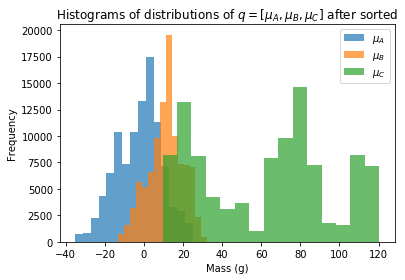

In [153]:
n = q_traj_noise.shape[0]  # get number of time steps
q_traj_sorted = q_traj_noise.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj_noise[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()